# microCOSM Model ensemble

<img src="microCOSM_schematic.png" width="1200" />

The _microCOSM_ (micro-Carbon/Climate/Ocean Science Model) model has six boxes representing the Surface Atlantic (SA), Surface Southern (SS), Surface Pacific (SP), Deep Atlantic (DA), Deep Southern (DS), and Deep Pacific (DP) Oceans. (A) Two interconnected pathways of the largescale ocean circulation are represented:
Upwelling in the Southern Ocean (SUP) brings deep waters to the surface around Antarctica. These waters are then transported throughout the ocean in the Atlantic Meridional Overturning Circulation (AMOC), representing the path of North Atlantic Deep Waters, or the Southern Ocean Meridional Overturning Circulation (SMOC), representing the path of Antarctic Bottom Waters. (B) Transports between adjacent boxes are prescribed as a fraction of Southern Ocean upwelling (highlighted in white), which is varied over a wide range of values. AMOC transport is equivalent to Southern Ocean upwelling, although note that half of AMOC transport comes from the Surface Pacific, while SMOC is equivalent to 55% of Southern Ocean upwelling. Iron-binding ligands are produced by organic matter turnover, and lost by microbial degradation (Lauderdale et al, 2020, doi:10.1073/pnas.1917277117).

In this notebook, we run two groups of simulations looking at the response of the global carbon cycle to changes in overturning circulation strength, additionally considering the effects of constant, fixed iron-ligand concentrations and dynamic ligand cycling.

In [1]:
import glob               as gb
import matplotlib         as mp
import numpy.ma           as nm
import numpy              as np
import matplotlib.pyplot  as plt
import pandas             as pd
import scipy.stats        as st
import time
import warnings           as ws

from matplotlib.ticker                     import FormatStrFormatter
from matplotlib.patches                    import Rectangle, Arc, RegularPolygon
from matplotlib.lines                      import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Some figure options for later
mp.rcParams["xtick.labelsize"] = 14
mp.rcParams["ytick.labelsize"] = 14

# Main storage dictionaries for the model runs
ensemble_fixedlig_input   = dict() 
ensemble_fixedlig_output  = dict()
ensemble_fixedlig_anomaly = dict()

ensemble_variablelig_input   = dict() 
ensemble_variablelig_output  = dict()
ensemble_variablelig_anomaly = dict()

def compile_microcosm(options=None):
    # Function to help compile the microCOSM box model
    # Supply compile options as a list of the following:
    #    FIXATMPCO2 - disable the conservative atmospheric carbon box
    #    WRITEOUTFILE - enable the textfile output.
    # NOTE: you have to restart the kernal if you change these options and recompile
    #       more than once...limitation of using f2py
    import os
    import subprocess

    # Depending on platform
    if os.sys.platform == "darwin":
        # Issue with compilation where f2py is linking to v10.9 rather than current OSX version.
        import platform

        mac_ver = ".".join(platform.mac_ver()[0].split(".")[:2])
        env     = dict(os.environ, **{"MACOSX_DEPLOYMENT_TARGET": mac_ver})
        print("setting MACOSX_DEPLOYMENT_TARGET to: " + mac_ver)
    else:
        env     = os.environ

    optdefs     = "OPTIONDEFS = "
    if options is not None:
        optdefs = optdefs + " ".join(["-D" + item for item in options])
        print("Compiling with options: " + optdefs)

    # Clean environment of previous model files
    runmake = subprocess.Popen(
        ["make", "clean"],
        stdin  = subprocess.PIPE,
        stdout = subprocess.PIPE,
        stderr = subprocess.PIPE,
        text   = True,
        env    = env,
    )
    runmake.wait()
    # Compile
    runmake = subprocess.Popen(
        ["make", "pymodel", optdefs],
        stdin  = subprocess.PIPE,
        stdout = subprocess.PIPE,
        stderr = subprocess.PIPE,
        text   = True,
        env    = env,
    )
    runmake.wait()
    print("The exit code for compilations was: {0}".format(runmake.returncode))
    return runmake.returncode


def check_parallel():
    import importlib

    spec            = importlib.util.find_spec("pandarallel")
    run_in_parallel = spec is not None
    return run_in_parallel

def label_axes(axarray,ignore=None,label_columns=False):
    import string      as st
    m=0
    
    if label_columns:
        axarray=np.transpose(axarray)
    
    for n, ax in enumerate(axarray.flat):
        if ignore is not None and n in ignore:
            m+=1
            continue
        else:
            ax.text(-0.05, 1.05, st.ascii_uppercase[n-m], transform=ax.transAxes, 
                    size=20, weight='bold')


## 1. Run ensemble to examine sensitivity of atmospheric CO$_2$ to changes in meridional overturning circulation strength
It's possible to use _microCOSM_ to perform efficient ensemble/parameter space exploration (potentially in parallel using the "Pandarallel" package's "parallel_apply" function). This separate notebook is necessary because you cannot 'reload' f2py extension modules, i.e. to make atmospheric CO$_2$ variable.

First, recompile the model to allow variable atmospheric pCO$_2$ (sometimes this seems to just hang?)

In [ ]:
ec = compile_microcosm(options=["SIXBOX"])

if ec == 0:
    import microCOSM

Define some driver functions for running the ensemble and plotting the results

In [2]:
def run_microcosm(df_input, basin_names, workers=1, Rcp=106, Rnp=16):
    """
    Run the box model:

    a) workers=1; in series using pandas' "apply" to run through rows of a data frame of inputs
    b) workers>1; in parallel using pandarallel's "parallel_apply"

    returns pandas dataframe with the results
    """
    # Define private helper function, pretty much the same as the direct model call in "run_microCOSM" notebook
    def _boxmodel(self):
        timeseries = pd.DataFrame(
            np.column_stack(
                microCOSM.mod_modelmain.model(*self.values),
                            ).T,
                   index=["time"]\
                        +["t" + name.lower() for name in basin_names]\
                        +["s" + name.lower() for name in basin_names]\
                        +["c" + name.lower() for name in basin_names]\
                        +["a" + name.lower() for name in basin_names]\
                        +["p" + name.lower() for name in basin_names]\
                        +["n" + name.lower() for name in basin_names]\
                        +["f" + name.lower() for name in basin_names]\
                        +["l" + name.lower() for name in basin_names]\
                        +["export" + name.lower() for name in basin_names]\
                        +["lim"]\
                        +["pstar"]\
                        +["pco2" + name.lower() for name in basin_names]\
                        +["atmpco2"],
                              ).transpose()

        # return the last timestep of model run, as well as input parameter values
        return pd.concat(
                [
                    self[["niter",
                          "nyrs",
                          "tout",
                          "nout",
                          "psi",
                          "dif",
                          "alphabio",  
                          "gamma",     
                          "lambda",    
                    #      "dlambdadz", 
                    #      "sourceFe",  
                    #      "wind",      
                    #      "fopen",
                         ]],
                    timeseries.iloc[-1].drop(columns=["time"]),
                    ]
                    )   

    if workers == 1:
        # Run in serial mode (avoids overhead of pandarallel if not running multiprocessor)
        df_output = df_input.apply(_boxmodel, axis=1)
    elif workers > 1:
        # Run in parallel
        from pandarallel import pandarallel

        pandarallel.initialize(nb_workers=workers, progress_bar=True)

        df_output = df_input.parallel_apply(_boxmodel, axis=1)

    # Do some post processing
    df_output = postprocessing(df_output, Rcp=Rcp)

    return df_output


# example post processing routine
def postprocessing(data_pd, Rcp=106):
    # Integrated export production (Southern Ocean + Surface Atlantic + Surface Pacific)
    data_pd["tot_export"] = data_pd["exportsa"] + data_pd["exportss"] + data_pd["exportsp"]
    return data_pd

def recalc_pstar(dictin,dictout):
    vol   = np.array(dictin['dx'].iloc[0]) * np.array(dictin['dy'].iloc[0]) * np.array(dictin['dz'].iloc[0])
    
    mean_deep_ocean_p = (dictout['nda']*vol[1]+dictout['nds']*vol[3]+dictout['ndp']*vol[5])/np.sum(vol[[1,3,5]])

    # assume preformed concentration is set in the surface Atlantic/Southern Ocean
    mean_surface_ocean_p = (dictout['nsa']*vol[0]+dictout['nss']*vol[2]+dictout['nsp']*vol[4])/np.sum(vol[[0,2,4]])

    mean_global_ocean_p = (dictout['nda']*vol[1]+dictout['nds']*vol[3]+dictout['ndp']*vol[5]+dictout['nsa']*vol[0]+dictout['nss']*vol[2]+dictout['nsp']*vol[4])/np.sum(vol)
    
    return (mean_deep_ocean_p-mean_surface_ocean_p) / mean_global_ocean_p

def get_ligand_parameters(fadd="",gamma_over_lambda=4398.0,gamma=5.0e-5,lig_conc=2.0,R_cp=106.0):
    if gamma_over_lambda > 0.0:
        # Assume this means prognostic ligand required
        fadd       = fadd + "variablelt"
        # Gamma over lambda for ligands "optimum" value (Lauderdale et al 2020)    
        # gamma input to the model is in phosphate units, not carbon units...
        # (also applies to gamma_over_lambda...lambda should be in 1/seconds)
        lig_gamma  = np.array((gamma * R_cp,))
        lig_lambda = 1.0 / ((lig_gamma / R_cp) / gamma_over_lambda)
        lig_conc   = 0.0
    else:
        fadd       = fadd + "fixedlt{0:1.0f}nm".format(lig_conc)
        lig_gamma  = np.array((0.0,))
        lig_lambda = np.array((0.0,))
    return fadd, lig_gamma, lig_lambda, lig_conc

def plot_concentrations(markers,basin_names,output,lower_bound=None,upper_bound=None,niso=0,nmax=-1,nctrl=20,x_fig=1.,y_fig=1.,suptitle_text=None):
    fig,figax = plt.subplots(figsize=(3.75 * x_fig, 6.5 * y_fig),nrows=6,ncols=3)
    fig.patch.set_facecolor("None")
    
    for s,var in enumerate(["n","f","l"]):
        if var=="n":
            varlab="Nitrate ($\mu$mol kg$^{-1}$)"
        elif var=="f":
            varlab="Iron (nmol kg$^{-1}$)"
        elif var=="l":
            varlab="Ligand (nmol kg$^{-1}$)"
            
        for ii,basin in enumerate(basin_names.keys()):
            if niso > 0:
                figax[ii,s].plot(
                    output["psi"].iloc[1:niso+1] * 1e-6,
                    output[var+basin.lower()].iloc[1:niso+1],
                    markersize      = markers['output']['markersize'],
                    marker          = markers['output']['marker'],
                    markeredgecolor = "darkgrey",
                    color           = "lightgrey",
                )  
            figax[ii,s].plot(output['psi'].iloc[niso:nmax] * 1e-6,
                             output[var+basin.lower()].iloc[niso:nmax],
                             **markers['output']
            )
            
            if lower_bound is not None:
                if niso > 0:
                    figax[ii,s].plot(
                        lower_bound["psi"].iloc[1:niso+1] * 1e-6,
                        lower_bound[var+basin.lower()].iloc[1:niso+1],
                        markersize      = markers['lower_bound']['markersize'],
                        marker          = markers['lower_bound']['marker'],
                        markeredgecolor = "darkgrey",
                        color           = "lightgrey",
                    )  
                figax[ii,s].plot(lower_bound['psi'].iloc[niso:nmax] * 1e-6,
                                 lower_bound[var+basin.lower()].iloc[niso:nmax],
                                 **markers['lower_bound']
                )
                
            if upper_bound is not None:
                if niso > 0:
                    figax[ii,s].plot(
                        upper_bound["psi"].iloc[1:niso+1] * 1e-6,
                        upper_bound[var+basin.lower()].iloc[1:niso+1],
                        markersize      = markers['upper_bound']['markersize'],
                        marker          = markers['upper_bound']['marker'],
                        markeredgecolor = "darkgrey",
                        color           = "lightgrey",
                    )                  
                figax[ii,s].plot(upper_bound['psi'].iloc[niso:nmax] * 1e-6,
                                 upper_bound[var+basin.lower()].iloc[niso:nmax],
                                 **markers['upper_bound']
                )
            
            figax[ii,s].set_title(varlab, fontsize=16)
            if ii==len(basin_names.keys())-1:
                figax[ii,s].set_xlabel("Southern Ocean upwelling strength [Sv]", fontsize=16)
            if s==0:
                figax[ii,s].set_ylabel(basin_names[basin], fontsize=16)#+"\n"+varlab)
            #else:
            #    figax[ii,s].set_ylabel(varlab)
            figax[ii,s].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))

    for ax in figax.reshape(-1):
        ax.axvline(nctrl,linestyle='--',color='black')
        ylim = ax.get_ylim()
        
        # Reasonable AMOC strengths
        ax.axvspan(
            8,25,         # Where are these numbers from
            color='#cccccc',
            zorder=-2,
        )
        ax.set_ylim(ylim)
        
    plt.suptitle(
        suptitle_text,
        fontsize=16,
    )
    plt.subplots_adjust(wspace=0.25, top=0.95)
    label_axes(figax)
    plt.show()
    return fig

def plot_export_pco2(markers,basin_names,output,lower_bound=None,upper_bound=None,niso=0,nmax=-1,nctrl=20,x_fig=1.,y_fig=1.,suptitle_text=None):
    fig, figax = plt.subplots(figsize=(3.75 * x_fig, 2.25 * y_fig), ncols=3, nrows=2)
    fig.patch.set_facecolor("None")

        # Atmospheric CO2
    if niso > 0:
        figax[0,0].plot(
            output["psi"].iloc[1:niso+1] * 1e-6,
            output["atmpco2"].iloc[1:niso+1],
            markersize      = markers['output']['markersize'],
            marker          = markers['output']['marker'],
            markeredgecolor = "darkgrey",
            color           = "lightgrey",
        )  
    figax[0,0].plot(
        output["psi"].iloc[niso:nmax] * 1e-6,
        output["atmpco2"].iloc[niso:nmax],
        **markers['output']
    )  
    if lower_bound is not None:
        if niso > 0:
            figax[0,0].plot(
                lower_bound["psi"].iloc[1:niso+1] * 1e-6,
                lower_bound["atmpco2"].iloc[1:niso+1],
                markersize      = markers['lower_bound']['markersize'],
                marker          = markers['lower_bound']['marker'],
                markeredgecolor = "darkgrey",
                color           = "lightgrey",
            )  
            figax[0,0].plot(lower_bound['psi'].iloc[niso:nmax] * 1e-6,
                lower_bound["atmpco2"].iloc[niso:nmax],
                **markers['lower_bound']
            )
            
    if upper_bound is not None:
        if niso > 0:
            figax[0,0].plot(
                upper_bound["psi"].iloc[1:niso+1] * 1e-6,
                upper_bound["atmpco2"].iloc[1:niso+1],
                markersize      = markers['upper_bound']['markersize'],
                marker          = markers['upper_bound']['marker'],
                markeredgecolor = "darkgrey",
                color           = "lightgrey",
            )                  
            figax[0,0].plot(upper_bound['psi'].iloc[niso:nmax] * 1e-6,
                upper_bound["atmpco2"].iloc[niso:nmax],
                **markers['upper_bound']
            )
    figax[0,0].set_ylabel("Atmospheric pCO$_2$ [$\mu$atm]", fontsize=16)    
    
    # Global export
    if niso > 0:
        figax[0,1].plot(
            output["psi"].iloc[1:niso+1] * 1e-6,
            output["tot_export"].iloc[1:niso+1],
            markersize      = markers['output']['markersize'],
            marker          = markers['output']['marker'],
            markeredgecolor = "darkgrey",
            color           = "lightgrey",
        )  
    figax[0,1].plot(
        output["psi"].iloc[niso:nmax] * 1e-6,
        output["tot_export"].iloc[niso:nmax],
        **markers['output']
    )  
    if lower_bound is not None:
        if niso > 0:
            figax[0,1].plot(
                lower_bound["psi"].iloc[1:niso+1] * 1e-6,
                lower_bound["tot_export"].iloc[1:niso+1],
                markersize      = markers['lower_bound']['markersize'],
                marker          = markers['lower_bound']['marker'],
                markeredgecolor = "darkgrey",
                color           = "lightgrey",
            )  
            figax[0,1].plot(lower_bound['psi'].iloc[niso:nmax] * 1e-6,
                lower_bound["tot_export"].iloc[niso:nmax],
                **markers['lower_bound']
            )
            
    if upper_bound is not None:
        if niso > 0:
            figax[0,1].plot(
                upper_bound["psi"].iloc[1:niso+1] * 1e-6,
                upper_bound["tot_export"].iloc[1:niso+1],
                markersize      = markers['upper_bound']['markersize'],
                marker          = markers['upper_bound']['marker'],
                markeredgecolor = "darkgrey",
                color           = "lightgrey",
            )                  
            figax[0,1].plot(upper_bound['psi'].iloc[niso:nmax] * 1e-6,
                upper_bound["tot_export"].iloc[niso:nmax],
                **markers['upper_bound']
            )
    figax[0,1].set_ylabel("Net export production [GtC yr$^{-1}$]", fontsize=16)
    figax[0,1].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    
    figax[0,2].axes.get_xaxis().set_visible(False)
    figax[0,2].get_yaxis().set_visible(False)
    figax[0,2].set_facecolor((1,1,1,0))
    figax[0,2].set_axis_off()
        
    for ii, name in enumerate({n: basin_names[n] for n in ["SA", "SS", "SP"] if n in basin_names}):
        if niso > 0:
            figax[1,ii].plot(
                output["psi"].iloc[1:niso+1] * 1e-6,
                output["export" + name.lower()].iloc[1:niso+1],
                markersize      = markers['output']['markersize'],
                marker          = markers['output']['marker'],
                markeredgecolor = "darkgrey",
                color           = "lightgrey",
                )  
        figax[1,ii].plot(
            output["psi"].iloc[niso:nmax] * 1e-6,
            output["export" + name.lower()].iloc[niso:nmax],
            **markers['output']
        )
        if lower_bound is not None:
            if niso > 0:
                figax[1,ii].plot(
                    lower_bound["psi"].iloc[1:niso+1] * 1e-6,
                    lower_bound["export"+name.lower()].iloc[1:niso+1],
                    markersize      = markers['lower_bound']['markersize'],
                    marker          = markers['lower_bound']['marker'],
                    markeredgecolor = "darkgrey",
                    color           = "lightgrey",
                )  
                figax[1,ii].plot(lower_bound['psi'].iloc[niso:nmax] * 1e-6,
                    lower_bound["export"+name.lower()].iloc[niso:nmax],
                    **markers['lower_bound']
                )
                
        if upper_bound is not None:
            if niso > 0:
                figax[1,ii].plot(
                    upper_bound["psi"].iloc[1:niso+1] * 1e-6,
                    upper_bound["export"+name.lower()].iloc[1:niso+1],
                    markersize      = markers['upper_bound']['markersize'],
                    marker          = markers['upper_bound']['marker'],
                    markeredgecolor = "darkgrey",
                    color           = "lightgrey",
                )                  
                figax[1,ii].plot(upper_bound['psi'].iloc[niso:nmax] * 1e-6,
                    upper_bound["export"+name.lower()].iloc[niso:nmax],
                    **markers['upper_bound']
                )
        figax[1,ii].set_ylabel("Export production [GtC yr$^{-1}$]", fontsize=16)
        figax[1,ii].set_xlabel("Southern Ocean upwelling strength [Sv]", fontsize=16)
        figax[1,ii].set_title(basin_names[name], fontsize=16)
        
    for a,ax in enumerate(figax.reshape(-1)):
        if a!=2:
            ax.axvline(nctrl,linestyle='--',color='black')
            ylim = ax.get_ylim()
            
            # Reasonable AMOC strengths
            ax.axvspan(
                8,25,         # Where are these numbers from
                color='#cccccc',
                zorder=-2,
            )
            ax.set_ylim(ylim)
               
    plt.suptitle(
        suptitle_text,
        fontsize=16,
    )
    
    plt.subplots_adjust(wspace=0.25, hspace=0.3, top=0.88)
    label_axes(figax,ignore=[2])
    plt.show()
    return fig

def plot_concentration_anomalies(basin_markers,basin_names,input,output,anomaly,lower_bound=None,upper_bound=None,niso=0,nmax=-1,x_fig=1.,y_fig=1.,suptitle_text=None):
    fig, figax = plt.subplots(figsize=(3.5 * x_fig, 3.5 * y_fig), ncols=2, nrows=4)
    fig.patch.set_facecolor("None")
    mycm = plt.cm.get_cmap("viridis_r")
    
    alpha = 0.7

    if niso > 0:
        figax[0, 0].plot(
            output["psi"].iloc[1:niso+1] * 1e-6,
            anomaly["tot_export"].iloc[1:niso+1],
            linewidth       = 3,
            markersize      = 10,
            marker          = "*",
            markeredgecolor = "darkgrey",
            color           = "lightgrey",
        )
    
    figax[0, 0].plot(
        output["psi"].iloc[niso:nmax] * 1e-6,
        anomaly["tot_export"].iloc[niso:nmax],
        linewidth       = 3,
        markersize      = 10,
        marker          = "*",
        markeredgecolor = "k",
        color           = "darkorange",
        label           = "Total Export",
    )
    
    ylim = figax[0,0].get_ylim()
    xlim = (-2, np.max(output["psi"].iloc[niso:nmax] * 1e-6)+2)
    
    figax[0, 0].fill_between(
        (8,25),         # Where are these numbers from
        np.min(ylim),
        np.max(ylim),
        color='#cccccc',
        zorder=-2,
    )
    
    figax[0,0].set(xlim=xlim,ylim=ylim)
    
    if lower_bound is not None and upper_bound is not None:
        if niso > 0:
            figax[0, 0].fill_between(
                output["psi"].iloc[1:niso+1] * 1e-6,
                np.min([lower_bound["tot_export"].iloc[1:niso+1],
                        upper_bound["tot_export"].iloc[1:niso+1],
                            anomaly["tot_export"].iloc[1:niso+1]],axis=0),
                np.max([lower_bound["tot_export"].iloc[1:niso+1],
                        upper_bound["tot_export"].iloc[1:niso+1],
                            anomaly["tot_export"].iloc[1:niso+1]],axis=0),
                alpha = alpha,
                color = "darkgrey",
            )
        figax[0, 0].fill_between(
            output["psi"].iloc[niso:nmax] * 1e-6,
            np.min([lower_bound["tot_export"].iloc[niso:nmax],
                    upper_bound["tot_export"].iloc[niso:nmax],
                        anomaly["tot_export"].iloc[niso:nmax]],axis=0),
            np.max([lower_bound["tot_export"].iloc[niso:nmax],
                    upper_bound["tot_export"].iloc[niso:nmax],
                        anomaly["tot_export"].iloc[niso:nmax]],axis=0),
            alpha = alpha,
            color = "darkorange",
        )
    for ii, name in enumerate({n: basin_names[n] for n in ["SA", "SS", "SP"] if n in basin_names}):
        if niso > 0:
            figax[0, 0].plot(
                output["psi"].iloc[1:niso+1] * 1e-6,
                anomaly["export" + name.lower()].iloc[1:niso+1],
                linewidth       = 3,
                marker          = basin_markers[name][0],
                markeredgecolor = "darkgrey",
                markersize      = basin_markers[name][2],
                color           = "lightgrey",
            )
        figax[0, 0].plot(
            output["psi"].iloc[niso:nmax] * 1e-6,
            anomaly["export" + name.lower()].iloc[niso:nmax],
            linewidth       = 3,
            marker          = basin_markers[name][0],
            markeredgecolor = basin_markers[name][1],
            markersize      = basin_markers[name][2],
            color           = mycm(ii / (len(basin_names) - 1)),
        )
        if lower_bound is not None and upper_bound is not None:
            if niso > 0:
                figax[0, 0].fill_between(
                    output["psi"].iloc[1:niso+1] * 1e-6,
                    np.min([upper_bound["export" + name.lower()].iloc[1:niso+1],
                            lower_bound["export" + name.lower()].iloc[1:niso+1],
                                anomaly["export" + name.lower()].iloc[1:niso+1]],axis=0),
                    np.max([upper_bound["export" + name.lower()].iloc[1:niso+1],
                            lower_bound["export" + name.lower()].iloc[1:niso+1],
                                anomaly["export" + name.lower()].iloc[1:niso+1]],axis=0),
                    alpha = alpha,
                    color = 'darkgrey',
                )
            figax[0, 0].fill_between(
                output["psi"].iloc[niso:nmax] * 1e-6,
                np.min([upper_bound["export" + name.lower()].iloc[niso:nmax],
                        lower_bound["export" + name.lower()].iloc[niso:nmax],
                            anomaly["export" + name.lower()].iloc[niso:nmax]],axis=0),
                np.max([upper_bound["export" + name.lower()].iloc[niso:nmax],
                        lower_bound["export" + name.lower()].iloc[niso:nmax],
                            anomaly["export" + name.lower()].iloc[niso:nmax]],axis=0),
                alpha = alpha,
                color = mycm(ii / (len(basin_names) - 1)),
            )
    figax[0, 0].legend(frameon=False, fontsize=14)
    figax[0, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    figax[0, 0].set_ylabel("$\Delta$Export Production\n[GtC yr$^{-1}$]", fontsize=14)

    if niso > 0:
        figax[0, 1].plot(
            output["psi"].iloc[1:niso+1] * 1e-6,
            anomaly["atmpco2"].iloc[1:niso+1],
            linewidth       = 3,
            markersize      = 10,
            marker          = "*",
            markeredgecolor = "darkgrey",
            color           = "lightgrey",
        )    
    figax[0, 1].plot(
        output["psi"].iloc[niso:nmax] * 1e-6,
        anomaly["atmpco2"].iloc[niso:nmax],
        linewidth       = 3,
        markersize      = 10,
        marker          = "*",
        markeredgecolor = "k",
        color           = "darkorange",
        label           = "ATM pCO$_2$",
    )
    if lower_bound is not None and upper_bound is not None:
        if niso > 0:
            figax[0, 1].fill_between(
                output["psi"].iloc[1:niso+1] * 1e-6,
                np.min([lower_bound["atmpco2"].iloc[1:niso+1],
                        upper_bound["atmpco2"].iloc[1:niso+1],
                            anomaly["atmpco2"].iloc[1:niso+1]],axis=0),
                np.max([lower_bound["atmpco2"].iloc[1:niso+1],
                        upper_bound["atmpco2"].iloc[1:niso+1],
                            anomaly["atmpco2"].iloc[1:niso+1]],axis=0),
                alpha = alpha,
                color = "lightgrey",
            )
        figax[0, 1].fill_between(
            output["psi"].iloc[niso:nmax] * 1e-6,
            np.min([lower_bound["atmpco2"].iloc[niso:nmax],
                    upper_bound["atmpco2"].iloc[niso:nmax],
                        anomaly["atmpco2"].iloc[niso:nmax]],axis=0),
            np.max([lower_bound["atmpco2"].iloc[niso:nmax],
                    upper_bound["atmpco2"].iloc[niso:nmax],
                        anomaly["atmpco2"].iloc[niso:nmax]],axis=0),
            alpha = alpha,
            color = "orange",
        )
    figax[0, 1].legend(
        bbox_transform = fig.transFigure,
        bbox_to_anchor = (0.575, 0.88),
        fontsize       = 14,
        frameon        = False,
        loc            = "upper left",
    )

    ylim=figax[0,1].get_ylim()
    xlim = (-2, np.max(output["psi"].iloc[niso:nmax] * 1e-6)+2)
        
    figax[0, 1].fill_between(
        (8,25),         # Where are these numbers from
        np.min(ylim),
        np.max(ylim),
        color='#cccccc',
        zorder=-2,
    )
    
    figax[0,1].set(xlim=xlim, ylim=ylim)
    
    figax[0, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    figax[0, 1].set_ylabel("$\Delta$Atmospheric pCO$_2$\n[$\mu$atm]", fontsize=14)
    figax01b = figax[0, 1].twinx()
    if niso > 0:
        figax01b.plot(
            output["psi"].iloc[1:niso+1] * 1e-6,
            anomaly["pstar"].iloc[1:niso+1],
            linewidth       = 3,
            markersize      = 5,
            marker          = "x",
            markeredgecolor = "darkgrey",
            color           = "lightgrey",
        )  
    figax01b.plot(
        output["psi"].iloc[niso:nmax] * 1e-6,
        anomaly["pstar"].iloc[niso:nmax],
        linewidth       = 3,
        markersize      = 5,
        marker          = "x",
        markeredgecolor = "k",
        color           = "forestgreen",
        label           = "$\Delta$P*",
    )
    if lower_bound is not None and upper_bound is not None:
        if niso > 0:
            figax01b.fill_between(
                output["psi"].iloc[1:niso+1] * 1e-6,
                np.min([lower_bound["pstar"].iloc[1:niso+1],
                        upper_bound["pstar"].iloc[1:niso+1],
                            anomaly["pstar"].iloc[1:niso+1]],axis=0),
                np.max([lower_bound["pstar"].iloc[1:niso+1],
                        upper_bound["pstar"].iloc[1:niso+1],
                            anomaly["pstar"].iloc[1:niso+1]],axis=0),
                alpha = alpha,
                color = "lightgrey",
            )
        figax01b.fill_between(
            output["psi"].iloc[niso:nmax] * 1e-6,
            np.min([lower_bound["pstar"].iloc[niso:nmax],
                    upper_bound["pstar"].iloc[niso:nmax],
                        anomaly["pstar"].iloc[niso:nmax]],axis=0),
            np.max([lower_bound["pstar"].iloc[niso:nmax],
                    upper_bound["pstar"].iloc[niso:nmax],
                        anomaly["pstar"].iloc[niso:nmax]],axis=0),
            alpha = alpha,
            color = "green",
        )
    figax01b.legend(
        bbox_transform = fig.transFigure,
        bbox_to_anchor = (0.575, 0.86),
        fontsize       = 14,
        frameon        = False,
        loc            = "upper left",
    )
    figax01b.set_ylabel("$\Delta$Efficiency [%]", fontsize=14)
    
    for c,chem in enumerate([["c","n","f"],["a","p","l"]]):
        for cc,nut in enumerate(chem):
            for nn, name in enumerate(basin_names):
                if niso > 0:
                    figax[cc+1, c].plot(
                        output["psi"].iloc[1:niso+1] * 1e-6,
                        anomaly[nut + name.lower()].iloc[1:niso+1],
                        linewidth       = 3,
                        markersize      = basin_markers[name][2],
                        marker          = basin_markers[name][0],
                        markeredgecolor = "darkgrey",
                        color           = "lightgrey",
                    )  
                figax[cc+1, c].plot(
                    output["psi"].iloc[niso:nmax] * 1e-6,
                    anomaly[nut + name.lower()].iloc[niso:nmax],
                    linewidth       = 3,
                    marker          = basin_markers[name][0],
                    markeredgecolor = basin_markers[name][1],
                    markersize      = basin_markers[name][2],
                    color           = mycm(nn / (len(basin_names) - 1)),
                    label           = basin_names[name],
                )
                if lower_bound is not None and upper_bound is not None:
                    if niso > 0:
                        figax[cc+1,c].fill_between(
                            output["psi"].iloc[1:niso+1] * 1e-6,
                            np.min([lower_bound[nut + name.lower()].iloc[1:niso+1],
                                    upper_bound[nut + name.lower()].iloc[1:niso+1],
                                        anomaly[nut + name.lower()].iloc[1:niso+1]],axis=0),
                            np.max([lower_bound[nut + name.lower()].iloc[1:niso+1],
                                    upper_bound[nut + name.lower()].iloc[1:niso+1],
                                        anomaly[nut + name.lower()].iloc[1:niso+1]],axis=0),
                            alpha = alpha,
                            color = "lightgrey",
                        )
                    figax[cc+1,c].fill_between(
                        output["psi"].iloc[niso:nmax] * 1e-6,
                        np.min([lower_bound[nut + name.lower()].iloc[niso:nmax],
                                upper_bound[nut + name.lower()].iloc[niso:nmax],
                                    anomaly[nut + name.lower()].iloc[niso:nmax]],axis=0),
                        np.max([lower_bound[nut + name.lower()].iloc[niso:nmax],
                                upper_bound[nut + name.lower()].iloc[niso:nmax],
                                    anomaly[nut + name.lower()].iloc[niso:nmax]],axis=0),
                        alpha = alpha,
                        color = mycm(nn / (len(basin_names) - 1)),
                    )
            figax[cc+1, c].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))

            ylim = figax[cc+1,c].get_ylim()
            xlim = (-2, np.max(output["psi"].iloc[niso:nmax] * 1e-6)+2)

            figax[cc+1, c].fill_between(
                (8,25),         # Where are these numbers from
                np.min(ylim),
                np.max(ylim),
                color='#cccccc',
                zorder=-2,
            )
            figax[cc+1, c].set(xlim=xlim, ylim=ylim)
        
    figax[1, 0].set_ylabel("$\Delta$Carbon\n[$\mu$mol kg$^{-1}$]", fontsize=14)
    figax[1, 1].set_ylabel("$\Delta$Alkalinity\n[$\mu$mol kg$^{-1}$]", fontsize=14)
    figax[2, 0].set_ylabel("$\Delta$Nitrate\n[$\mu$mol kg$^{-1}$]", fontsize=14)
    figax[2, 1].set_ylabel("$\Delta$Phosphate\n[$\mu$mol kg$^{-1}$]", fontsize=14)
    figax[3, 0].set_ylabel("$\Delta$Iron\n[nmol kg$^{-1}$]", fontsize=14)
    figax[3, 1].set_ylabel("$\Delta$Ligand\n[nmol kg$^{-1}$]", fontsize=14)
    figax[3, 0].set_xlabel("Southern Ocean upwelling strength [Sv]", fontsize=14)
    figax[3, 1].set_xlabel("Southern Ocean upwelling strength [Sv]", fontsize=14)
    
    plt.suptitle(
        suptitle_text,
        fontsize=16,
    )
    
    # Add global box legend at the bottom
    figax[1, 0].legend(
        ncol           = int(len(input.iloc[0]["dz"])/2),
        bbox_transform = fig.transFigure,
        bbox_to_anchor = (0.5, 0.04),
        fontsize       = 14,
        frameon        = True,
        loc="center",
    )
    
    # Can adjust the subplot size
    plt.subplots_adjust(wspace=0.3, top=0.93)
    plt.show()
    return fig

def plot_box_sections(patches, tstep, basin_names, model_output, model_anomaly, suptitle_text):
    fig, figax = plt.subplots(figsize=(15, 13), ncols=2, nrows=3)
    fig.patch.set_facecolor("None")
    figca = figax.copy()
    figcb = figax.copy()
    figpa = dict()
    
    for mm in np.arange(len(model_output)):
        for ii, chem in enumerate(plot_vars.keys()):
            figpa[chem] = dict()
            figax[ii, mm].axes.get_xaxis().set_visible(False)
            figax[ii, mm].get_yaxis().set_visible(False)
            figax[ii, mm].set_facecolor((1, 1, 1, 0))
            figax[ii, mm].set_axis_off()
    
            norm = mp.colors.BoundaryNorm(
                plot_vars[chem]["bounds"],
                plot_vars[chem]["cmap"].N,
            )
            mycmp = plt.cm.ScalarMappable(
                norm=norm,
                cmap=plot_vars[chem]["cmap"],
            )
    
            for box in basin_names.keys():
                figpa[chem][box] = Rectangle(
                        (patches[box]["x"], patches[box]["y"]),
                        patches[box]["dx"],
                        patches[box]["dy"],
                        facecolor = mycmp.to_rgba(model_output[mm].iloc[tstep][chem + box.lower()]),
                        **boxargs,
                )
                
            amocarc = Arc(
                    [patches["AMOC"]["x"], patches["AMOC"]["y"]],
                    patches["AMOC"]["dx"],
                    patches["AMOC"]["dy"],
                    angle  = patches["AMOC"]["angle"],
                    theta1 = patches["AMOC"]["start"],
                    theta2 = patches["AMOC"]["end"],
                    **arcargs,
            )
    
            aabwp1arc = Arc(
                    [patches["AABWP1"]["x"], patches["AABWP1"]["y"]],
                     patches["AABWP1"]["dx"],
                     patches["AABWP1"]["dy"],
                    angle  = patches["AABWP1"]["angle"],
                    theta1 = patches["AABWP1"]["start"],
                    theta2 = patches["AABWP1"]["end"],
                    **arcargs,
            )
            
            aabwp2arc = Arc(
                    [patches["AABWP2"]["x"], patches["AABWP2"]["y"]],
                     patches["AABWP2"]["dx"],
                     patches["AABWP2"]["dy"],
                    angle  = patches["AABWP2"]["angle"],
                    theta1 = patches["AABWP2"]["start"],
                    theta2 = patches["AABWP2"]["end"],
                    **arcargs,
            )
            
            aabwaarc = Arc(
                    [patches["AABWA"]["x"], patches["AABWA"]["y"]],
                     patches["AABWA"]["dx"],
                     patches["AABWA"]["dy"],
                    angle  = patches["AABWA"]["angle"],
                    theta1 = patches["AABWA"]["start"],
                    theta2 = patches["AABWA"]["end"],
                    **arcargs,
            )
            
            amocarrow = RegularPolygon(
                    (
                     patches["AMOC"]["x"]+(patches["AMOC"]["dx"]/2)*
                        np.cos(np.radians(patches["AMOC"]["end"]+patches["AMOC"]["angle"]+10)), 
                     patches["AMOC"]["y"]+(patches["AMOC"]["dy"]/2)*
                        np.sin(np.radians(patches["AMOC"]["end"]+patches["AMOC"]["angle"]+10))
                    ),           
                    orientation = np.radians(patches["AMOC"]["angle"]+patches["AMOC"]["end"]),     
                    radius      = patches["AMOC"]["dy"]/15,
                    numVertices = 3,
                    color       = arcargs["color"]
            )
            
            aabwparrow = RegularPolygon(
                    (
                     patches["AABWP1"]["x"]+(patches["AABWP1"]["dx"]/2)*
                         np.cos(np.radians(patches["AABWP1"]["end"]+patches["AABWP1"]["angle"]-10)), 
                     patches["AABWP2"]["y"]+(patches["AABWP1"]["dy"]/2)*
                         np.sin(np.radians(patches["AABWP1"]["end"]+patches["AABWP1"]["angle"]-10))
                    ),           
                    orientation = np.radians(patches["AABWP1"]["angle"]+patches["AABWP1"]["end"]),     
                    radius      = patches["AABWP1"]["dy"]/15,
                    numVertices = 3,
                    color       = arcargs["color"]
            )
    
            aabwaarrow = RegularPolygon(
                    (
                     patches["AABWA"]["x"]+(patches["AABWA"]["dx"]/2)*
                         np.cos(np.radians(patches["AABWA"]["start"]+patches["AABWA"]["angle"])), 
                     patches["AABWA"]["y"]+(patches["AABWA"]["dy"]/2)*
                         np.sin(np.radians(patches["AABWA"]["start"]+patches["AABWA"]["angle"]))
                    ),           
                    orientation = np.radians(patches["AABWA"]["angle"]+patches["AABWA"]["start"]+180),     
                    radius      = patches["AABWP1"]["dy"]/15,
                    numVertices = 3,
                    color       = arcargs["color"]
            )

            suparrow = RegularPolygon(
                    (patches["SS"]["x"]+3*(patches["SS"]["dx"]/6),
                     patches["SS"]["y"]+1*(patches["SS"]["dy"]/2)),          
                    orientation = 0,     
                    radius      = patches["AABWP1"]["dy"]/15,
                    numVertices = 3,
                    color       = arcargs["color"]
            )
            
            supline1 = Line2D(
                    (patches["SS"]["x"]+2*(patches["SS"]["dx"]/6),
                     patches["SS"]["x"]+2*(patches["SS"]["dx"]/6)),
                    (patches["SS"]["y"], 
                     patches["SS"]["y"]+1*patches["SS"]["dy"]/12),
                    linewidth=2,
                    color       = arcargs["color"], 
            )
            supline2 = Line2D(
                    (patches["SS"]["x"]+3*(patches["SS"]["dx"]/6),
                     patches["SS"]["x"]+3*(patches["SS"]["dx"]/6)),
                    (3*(patches["SS"]["y"]/4), 
                     patches["SS"]["y"]+1*patches["SS"]["dy"]/2),
                    linewidth=2,
                    color       = arcargs["color"], 
            )
            supline3 = Line2D(
                    (patches["SS"]["x"]+4*(patches["SS"]["dx"]/6),
                     patches["SS"]["x"]+4*(patches["SS"]["dx"]/6)),
                    (patches["SS"]["y"], 
                     patches["SS"]["y"]+1*patches["SS"]["dy"]/12),
                    linewidth=2,
                    color       = arcargs["color"], 
            )
            
            for patch in figpa[chem].keys():
                figax[ii, mm].add_patch(figpa[chem][patch])
                
            for patch in [amocarc, amocarrow, aabwaarc, aabwaarrow, aabwp1arc, aabwp2arc, aabwparrow, suparrow]:
                figax[ii, mm].add_patch(patch)

            for line in [supline1, supline2, supline3]:
                figax[ii, mm].add_line(line)
    
            figax[ii, mm].set(
                xlim = (-0.01, 1.01),
                ylim = (-0.01, 1.01),
            )

            if chem == "n":
                textcolor="w"
            else:
                textcolor="k"
            figax[ii, mm].text(patches['SA']["x"]+0.01, 0.925, r'SA', fontsize=15)
            figax[ii, mm].text(patches['SS']["x"]+0.01, 0.925, r'SS', fontsize=15)
            figax[ii, mm].text(patches['SP']["x"]+patches['SP']["dx"]-0.065, 0.925, r'SP', fontsize=15)
            figax[ii, mm].text(patches['SA']["x"]+0.01, 0.025, r'DA', fontsize=15,color=textcolor)
            figax[ii, mm].text(patches['SS']["x"]+0.01, 0.025, r'DS', fontsize=15,color=textcolor)
            figax[ii, mm].text(patches['SP']["x"]+patches['SP']["dx"]-0.065, 0.025, r'DP', fontsize=15,color=textcolor)
            
            if ii==0 and mm == 0:
                title_text = "Fixed 2nm Ligand Concentration ($\Psi=${0} Sv)\n\n" \
                    .format(model_output[mm]["psi"].iloc[tstep]*1e-6)
                figax[ii,mm].set_title(title_text, fontsize=18)
            elif ii==0 and mm==1:
                title_text = "Variable Ligand Concentration ($\Psi=${0} Sv)\n\n" \
                    .format(model_output[mm]["psi"].iloc[tstep]*1e-6)
                figax[ii,mm].set_title(title_text, fontsize=18)
    
            figax[ii, mm].text(
                0.5,
                1.05,
                plot_vars[chem]["title"],
                fontsize            = 14,
                horizontalalignment = "center",
            )
    
            # Add a colorbar to the model sections
            figca[ii, mm] = inset_axes(
                figax[ii, mm],
                width          = "4%",
                height         = "100%",
                bbox_to_anchor = (0.05, 0, 1, 1),
                bbox_transform = figax[ii, mm].transAxes,
                borderpad      = 0,
            )
            
            figcb[ii, mm] = fig.colorbar(
                mycmp,
                cax         = figca[ii, mm],
                orientation = "vertical",
                ticks       = plot_vars[chem]["bounds"][::2],
            )
            
            figcb[ii, mm].solids.set_edgecolor("face")
            
    label_axes(figax,label_columns=True)
    plt.suptitle(suptitle_text,fontsize=18)
    plt.show()
    return fig

Set up the model ensemble investigating how the strength of the overturning circulation affects atmospheric CO$_2$ levels. First, we'll start with fixed and homogenous ligand concentrations.

In [3]:
# Box names
basin_names={"SA":"Surface Atlantic",
             "DA":"Deep Atlantic",
             "SS":"Surface Southern Ocean",
             "DS":"Deep Southern Ocean",
             "SP":"Surface Pacific",
             "DP":"Deep Pacific"}

# Name mangling to get the right pickup
fadd    = "6box"
fnadd   = fadd + "fixedlt2nm"

load_previous_results=True

cntrl_psi = 20e6

# Set psi max
psi_max=40.

# Number of experiments to run
niters = 41

niter   = np.arange(niters)

# change overturning circulation by 1Sv between 0 and psi_max Sv
psi_var = np.linspace(0.0, psi_max, niters) * 1e6

if load_previous_results:
    ensemble_fixedlig_input['cntrl'] = pd.read_json(
        "run_microCOSM_{0}_psi_{1:.0f}Sv_input.json".format(fnadd,psi_max), 
    )
else:   
    # Load steady state values from before
    model_input = pd.read_json(
        "run_microCOSM_{0}_pickup.json".format(fnadd), 
        typ='series'
    ).to_frame()
    
    # repeat the input parameters and adjust for the ensemble run
    ensemble_fixedlig_input['cntrl'] = pd.concat([model_input.T] * niters, ignore_index=True, copy=True)
    
    ensemble_fixedlig_input['cntrl']["nyrs"]   = 1e4
    ensemble_fixedlig_input['cntrl']["tout"]   = 1e2
    ensemble_fixedlig_input['cntrl']["nout"]   = int(ensemble_fixedlig_input['cntrl']["nyrs"].iloc[0]/ensemble_fixedlig_input['cntrl']["tout"].iloc[0])
    ensemble_fixedlig_input['cntrl']["psi"]    = psi_var
    ensemble_fixedlig_input['cntrl']["niter"]  = niter
    
    ensemble_fixedlig_input['cntrl'].to_json(
        "run_microCOSM_{0}_psi_{1:.0f}Sv_input.json".format(fnadd,psi_max),
    )

ensemble_fixedlig_input['cntrl'].iloc[0]

niter                                                         0
nyrs                                                      10000
tout                                                        100
nout                                                        100
dx            [17000000.0, 17000000.0, 17000000.0, 17000000....
dy            [4000000.0, 4000000.0, 2000000.0, 2000000.0, 8...
dz                [100.0, 3900.0, 100.0, 3900.0, 100.0, 3900.0]
depth                [50.0, 2050.0, 50.0, 2050.0, 50.0, 2050.0]
latitude               [-30.0, -30.0, -70.0, -70.0, 10.0, 10.0]
Kmix          [[[0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0...
Rremin        [[-1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0...
Pcir          [[0.0, 0.35000000000000003, 0.15, 0.0, 0.5, 0....
psi                                                           0
dif                                                           0
alphabio                                               0.000006
gamma                                   

Run the experiment

In [4]:
if load_previous_results:
    print(
        "Loading output from: run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(
            fnadd, psi_max
        )
    )
    ensemble_fixedlig_output['cntrl'] = pd.read_json(
        "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(fnadd, psi_max),
    )
else:
    # Check to see if the pandarallel package is available?
    run_in_parallel = check_parallel()
    # run_in_parallel=False

    start = time.time()
    if run_in_parallel:  # about 40s on 8 core late 2013 iMac i7 3.5Ghz
        # Run in parallel using pkg/pandarallel's "parallel_apply"
        import multiprocessing

        ensemble_fixedlig_output['cntrl'] = run_microcosm(
            ensemble_fixedlig_input['cntrl'], basin_names, workers=multiprocessing.cpu_count()
        )
    else:  # about 3 mins in serial
        # OR in series using pandas' "apply" to run through rows of a data frame of inputs
        ensemble_fixedlig_output['cntrl'] = run_microcosm(ensemble_fixedlig_input['cntrl'], basin_names, workers=1)
    end = time.time()
    print("{0} seconds".format((end - start)))

    ensemble_fixedlig_output['cntrl']["pstar"] = recalc_pstar(ensemble_fixedlig_input['cntrl'],ensemble_fixedlig_output['cntrl'])

    # save the output
    print(
        "Saving output to: run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(
            fnadd, psi_max
        )

    )
    ensemble_fixedlig_output['cntrl'].to_json(
        "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(fnadd, psi_max)
    )

ensemble_fixedlig_anomaly["cntrl"] = ensemble_fixedlig_output["cntrl"].subtract(
                                        ensemble_fixedlig_output["cntrl"].loc[
                                        ensemble_fixedlig_output["cntrl"].psi == cntrl_psi
                                       ].values
                                     )

Loading output from: run_microCOSM_6boxfixedlt2nm_psi_40Sv_output.json


## 2. Plot the model timeseries

In [5]:
# Some details for figure plotting
len_xaxis, len_yaxis = 4, 4      # fix here your numbers
xspace, yspace       = 0.9, 0.9  # change the size of the void border here.
x_fig, y_fig         = len_xaxis / xspace, len_yaxis / yspace

# At 6 Sv SOUP/AMOC:
# 55% of upwelling is compensated by downwelling in the Southern Ocean, so only 3 Sv net
# 35% compensation of downwelling in the North Atlantic (so 3.9./2.1 Sv)
# only 20% net upwells in the indopacific, so that's 1.2 Sv
# 
# Different perspective, the residence time in the deep indopacific is:
# 9474 years @ 8 Sv MOC 
# 12180 years @ 6 Sv MOC
niso = ensemble_fixedlig_input['cntrl'].loc[ensemble_fixedlig_output['cntrl'].psi == 8e6].index[0]
nmax = ensemble_fixedlig_input['cntrl'].loc[ensemble_fixedlig_output['cntrl'].psi == 40e6].index[0]+1

basin_markers = dict(
       SA = ["o", "k", 5],
       DA = ["X", "k", 5],
       SS = ["s", "k", 5],
       DS = ["D", "k", 5],
       SP = ["^", "k", 5],
       DP = ["v", "k", 5],
)

perturbation_markers = dict(
            output=dict(
                  linestyle  = '-',
                  marker     = 'o',
                  markersize = 5,
                  color      = '#ff9300',
                  ),
            upper_bound=dict(
                  linestyle  = '--',
                  marker     = '+',
                  markersize = 10,
                  color      = '#ee220d',
                  ),
            lower_bound=dict(
                  linestyle  = '--',
                  marker     = '$-$',
                  markersize = 10,
                  color      = '#00a2ff'
                  ),
        )

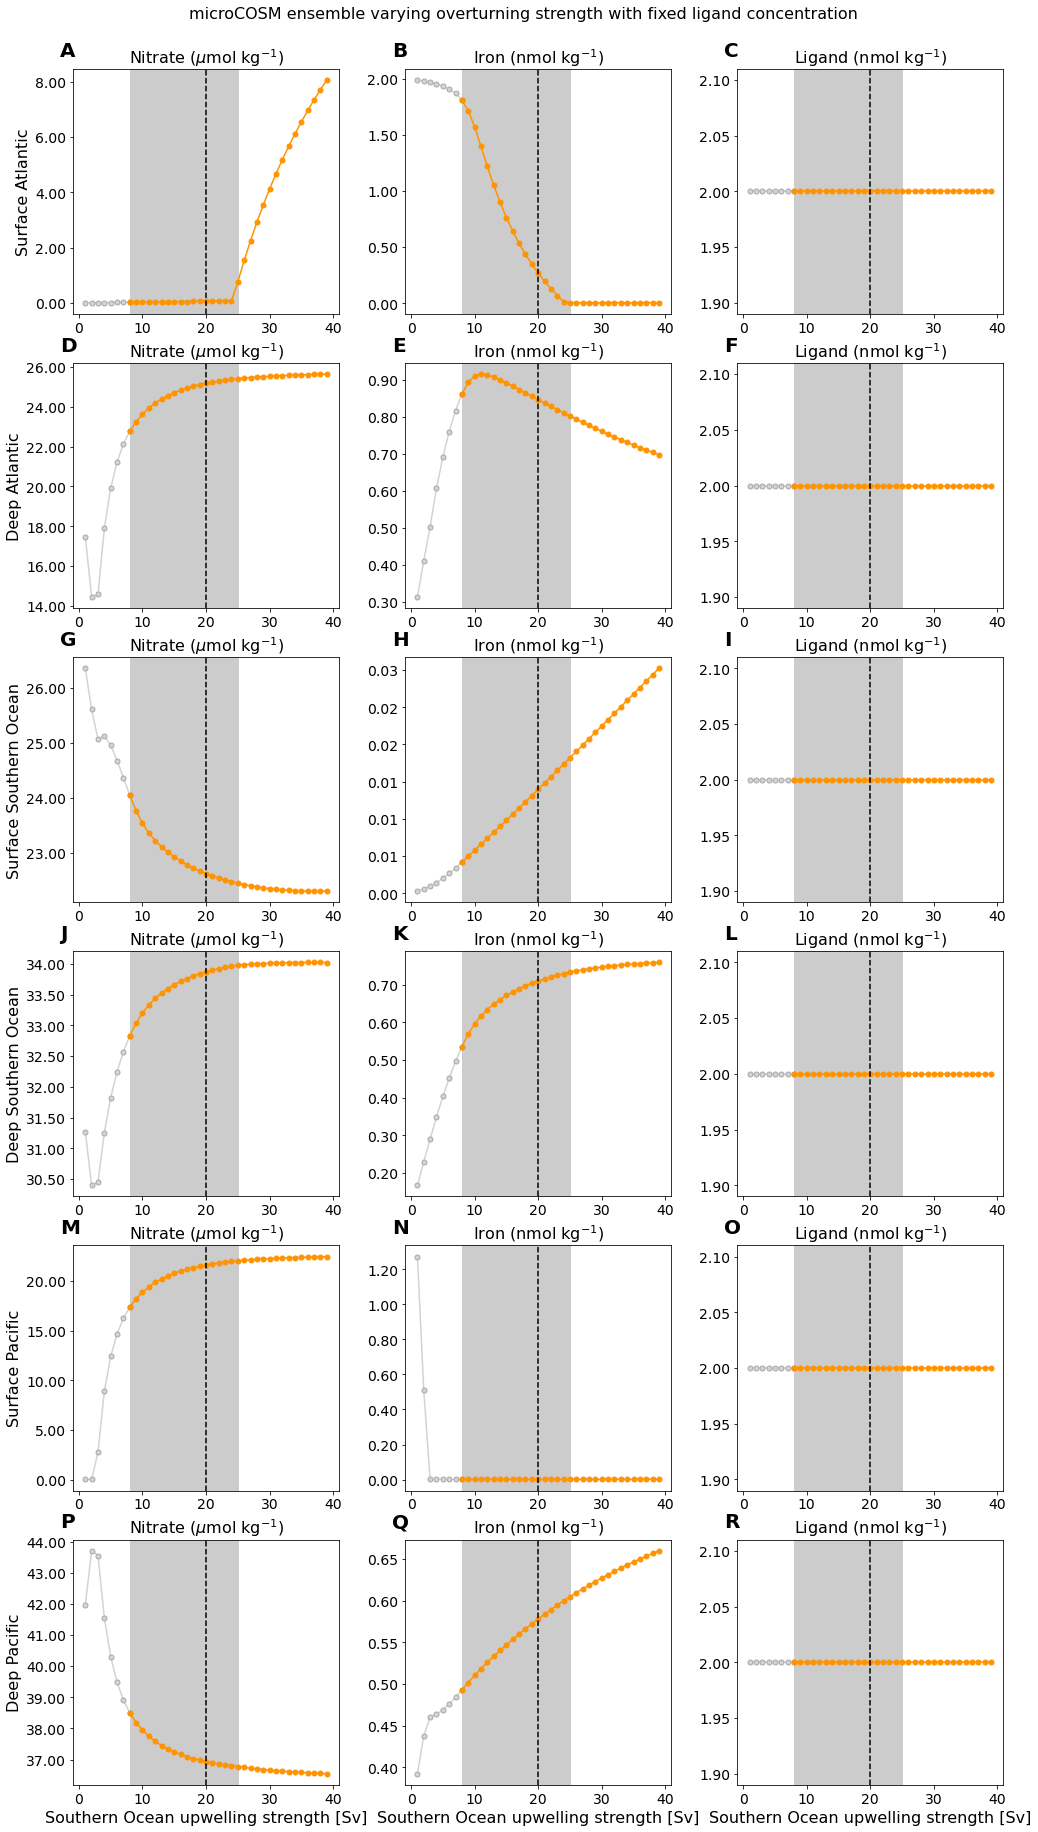

In [7]:
f1a = plot_concentrations(perturbation_markers,
                          basin_names,
                          ensemble_fixedlig_output['cntrl'],
                          lower_bound=None,
                          upper_bound=None,
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text="microCOSM ensemble varying overturning strength with fixed ligand concentration"
                         )
f1a.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_control_concentrations.pdf".format(fnadd,psi_max),
        facecolor   = f1a.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

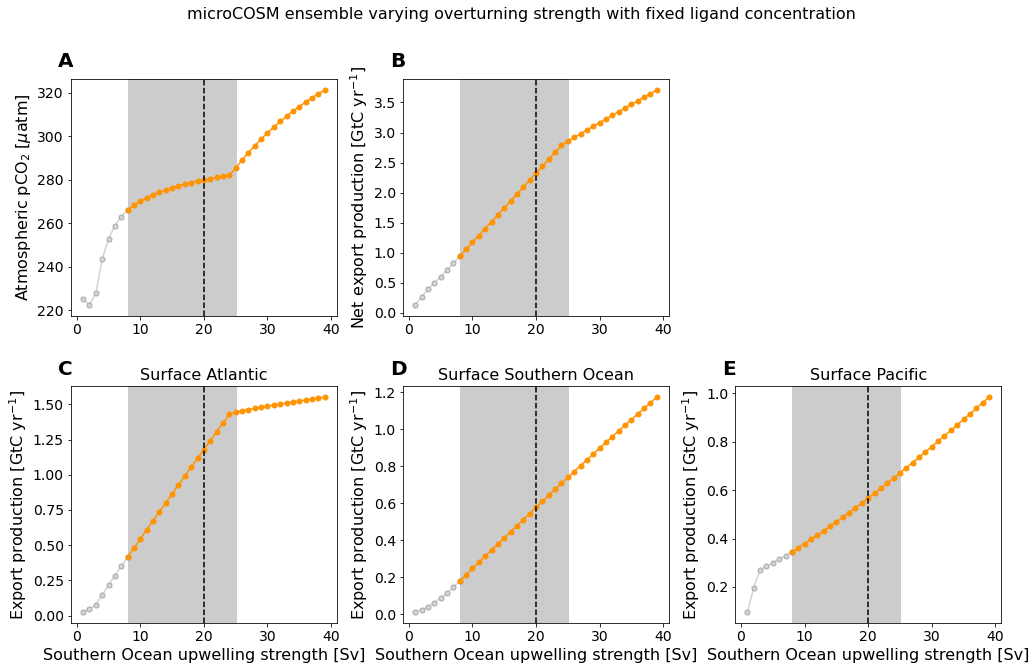

In [8]:
f1b = plot_export_pco2(perturbation_markers,
                          basin_names,
                          ensemble_fixedlig_output['cntrl'],
                          lower_bound=None,
                          upper_bound=None,
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text="microCOSM ensemble varying overturning strength with fixed ligand concentration"
                         )
f1b.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_control_exportpco2.pdf".format(fnadd,psi_max),
        facecolor   = f1b.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

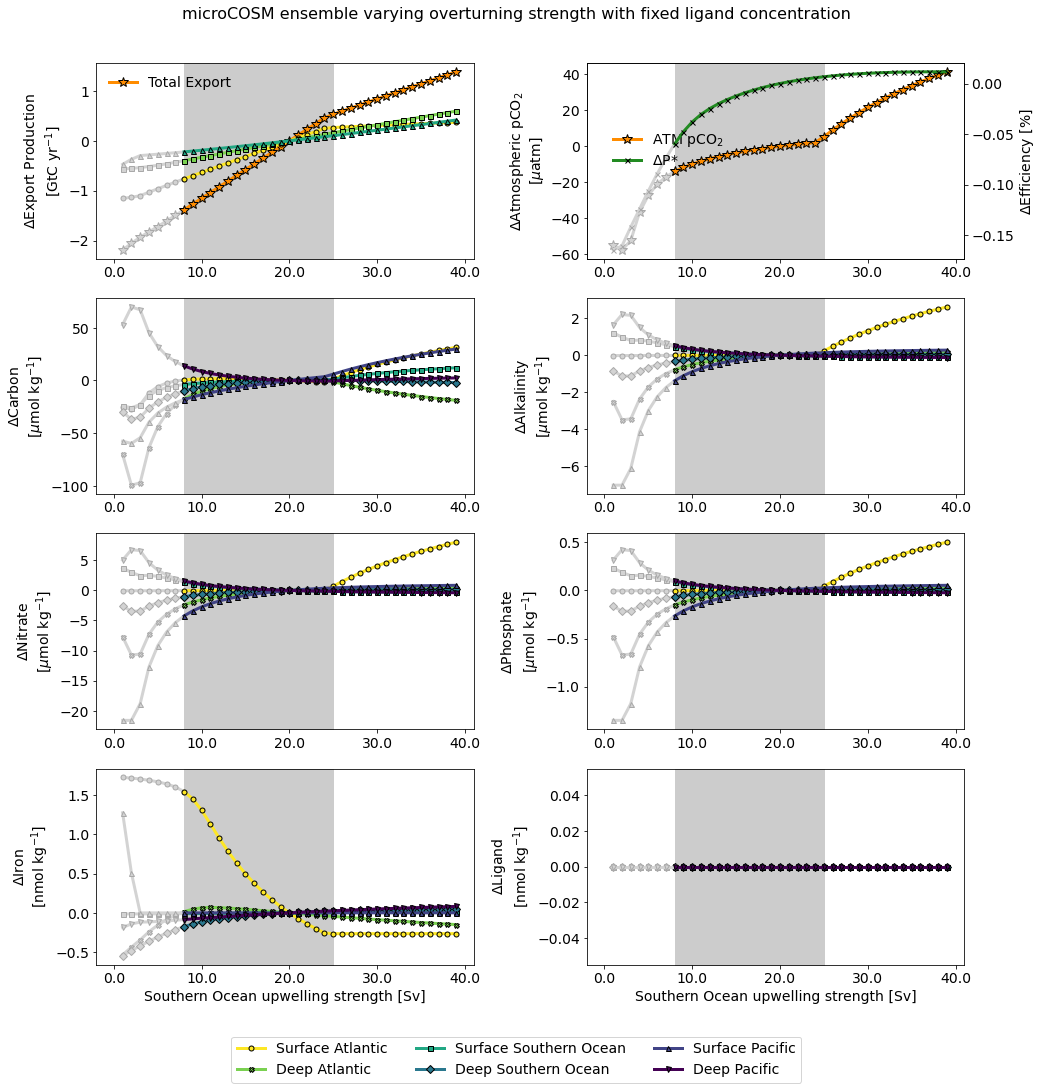

In [9]:
f1c = plot_concentration_anomalies(basin_markers, basin_names,
                         ensemble_fixedlig_input['cntrl'],
                         ensemble_fixedlig_output['cntrl'],
                         ensemble_fixedlig_anomaly['cntrl'],
                         lower_bound=None,
                         upper_bound=None,
                         x_fig = x_fig,
                         y_fig = y_fig,
                         niso  = niso,
                         suptitle_text="microCOSM ensemble varying overturning strength with fixed ligand concentration")

# save the graph
f1c.savefig(
    "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_control_anomalies.pdf".format(fnadd,psi_max),
    facecolor   = f1c.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)
plt.close()

## 3. Sensitivity experiment control runs

In [10]:
# Run control run for senitivity experiments from the standard control pickup (do this here for variable atmospheric CO2)
# Save time by running all experiments at once in parallel.
sensexpt = ["deca","inca","decd","incd","incmld","incmix"]

if not load_previous_results:    
    # Load steady state values from standard control pickup
    model_input = pd.concat([
        pd.read_json(
            "run_microCOSM_{0}_pickup.json".format(
                fnadd
            ), 
            typ='series'
            ).to_frame().T
        ] * len(sensexpt), ignore_index=True, copy=True)

    nsiter   = np.arange(len(sensexpt))
    model_input['niter'] = nsiter
    
    # Alter the input parameters as needed for each experiment
    model_input.at[0, 'alphabio'] = 3e-6
    model_input.at[1, 'alphabio'] = 9e-6
    fetmp                      =  model_input.loc[2, 'sourceFe'].copy()
    fetmp[2]                   =  fetmp[2]/20
    model_input.at[2, 'sourceFe'] = fetmp
    fetmp                      =  model_input.loc[3, 'sourceFe'].copy()
    fetmp[2]                   =  fetmp[2]*20
    model_input.at[3, 'sourceFe'] = fetmp
    newdz = np.array([ 2000.0, 2000.0, 100.0, 3900.0, 100.0, 3900.0])
    model_input.at[4, 'dz']       = newdz
    model_input.at[5, 'dif']      = 3.0e6

    # Check to see if the pandarallel package is available?
    run_in_parallel = check_parallel()
    # run_in_parallel=False

    start = time.time()
    if run_in_parallel:  # about 40s on 8 core late 2013 iMac i7 3.5Ghz
        # Run in parallel using pkg/pandarallel's "parallel_apply"
        import multiprocessing

        model_output = run_microcosm(
            model_input, basin_names, workers=multiprocessing.cpu_count()
        )
    else:  # about 3 mins in serial
        # OR in series using pandas' "apply" to run through rows of a data frame of inputs
        model_output = run_microcosm(model_input, basin_names, workers=1)
    end = time.time()
    print("{0} seconds".format((end - start)))

    # output array such that it could be used to restart the next simulation
    parms=['niter', 'nyrs', 'tout', 'nout', 'dx', 'dy', 'dz', 'depth', 'latitude',
           'Kmix', 'Rremin', 'Pcir', 'psi', 'dif', 'alphabio', 'gamma', 'lambda',
           'dlambdadz', 'sourceFe', 'wind', 'fopen']

    for si,sens in enumerate(sensexpt):
        pd.concat(
            [
            model_input.loc[si,parms],
            pd.Series({
                  "theta"     : model_output.loc[si,["t" + name.lower() for name in basin_names]].to_numpy(),
                  "salt"      : model_output.loc[si,["s" + name.lower() for name in basin_names]].to_numpy(),
                  "carbon"    : model_output.loc[si,["c" + name.lower() for name in basin_names]].to_numpy(),
                  "alkalinity": model_output.loc[si,["a" + name.lower() for name in basin_names]].to_numpy(),
                  "phosphate" : model_output.loc[si,["p" + name.lower() for name in basin_names]].to_numpy(),
                  "nitrate"   : model_output.loc[si,["n" + name.lower() for name in basin_names]].to_numpy(),
                  "iron"      : model_output.loc[si,["f" + name.lower() for name in basin_names]].to_numpy(),
                  "ligand"    : model_output.loc[si,["l" + name.lower() for name in basin_names]].to_numpy(),
                  "atmpco2"   : model_output.loc[si,'atmpco2'],
                      }),
            ]
            ).transpose().to_json("run_microCOSM_" + fnadd.replace(fnadd,fnadd+sens) + "_pickup.json")

### Now run the ensemble varying MOC strength

In [11]:
for sens in sensexpt:
    if load_previous_results:
        print(
            "Loading output from: run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(
                fnadd.replace(fnadd,fnadd+sens), psi_max,
            )
        )
    
        ensemble_fixedlig_input[sens] = pd.read_json(
            "run_microCOSM_{0}_psi_{1:.0f}Sv_input.json".format(
                fnadd.replace(fnadd,fnadd+sens), psi_max,
            )
        )
        
        ensemble_fixedlig_output[sens] = pd.read_json(
            "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(
                fnadd.replace(fnadd,fnadd+sens), psi_max,
            )
        )
    else:
        print(
            "Generating new output for microCOSM_{0}".format(
                fnadd.replace(fnadd,fnadd+sens),
            )
        )
        
        # repeat the input parameters and adjust for the ensemble run
        ensemble_fixedlig_input[sens] = pd.concat([
            pd.read_json(
            "run_microCOSM_{0}_pickup.json".format(
                fnadd.replace(fnadd,fnadd+sens)
            ), 
            typ='series'
            ).to_frame().T
        ] * niters, ignore_index=True, copy=True)
        
        ensemble_fixedlig_input[sens]["nyrs"]   = 1e4
        ensemble_fixedlig_input[sens]["tout"]   = 1e1
        ensemble_fixedlig_input[sens]["nout"]   = int(ensemble_fixedlig_input[sens]["nyrs"].iloc[0]/ensemble_fixedlig_input[sens]["tout"].iloc[0])
        ensemble_fixedlig_input[sens]["psi"]    = psi_var
        ensemble_fixedlig_input[sens]["niter"]  = niter
        
        ensemble_fixedlig_input[sens].to_json(
            "run_microCOSM_{0}_psi_{1:.0f}Sv_input.json".format(
                fnadd.replace(fnadd,fnadd+sens), psi_max,
            ),
        )
        
        # Check to see if the pandarallel package is available?
        run_in_parallel = check_parallel()
        # run_in_parallel=False
    
        start = time.time()
        if run_in_parallel:  # about 40s on 8 core late 2013 iMac i7 3.5Ghz
            # Run in parallel using pkg/pandarallel's "parallel_apply"
            import multiprocessing
    
            ensemble_fixedlig_output[sens] = run_microcosm(
                ensemble_fixedlig_input[sens], basin_names, workers=multiprocessing.cpu_count()
            )
        else:  # about 3 mins in serial
            # OR in series using pandas' "apply" to run through rows of a data frame of inputs
            ensemble_fixedlig_output[sens] = run_microcosm(ensemble_fixedlig_input[sens], basin_names, workers=1)
        end = time.time()
        print("{0} seconds".format((end - start)))

        ensemble_fixedlig_output[sens]["pstar"] = recalc_pstar(ensemble_fixedlig_input[sens],ensemble_fixedlig_output[sens])
        
        # save the output
        print(
            "Saving output to: run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(
                fnadd.replace(fnadd,fnadd+sens), psi_max,
            )
    
        )
        ensemble_fixedlig_output[sens].to_json(
            "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(
                fnadd.replace(fnadd,fnadd+sens), psi_max,
            )
        )
    ensemble_fixedlig_anomaly[sens] = ensemble_fixedlig_output[sens].subtract(
                                      ensemble_fixedlig_output[sens].loc[
                                      ensemble_fixedlig_output[sens].psi == cntrl_psi
                                     ].values
    )

Loading output from: run_microCOSM_6boxfixedlt2nmdeca_psi_40Sv_output.json
Loading output from: run_microCOSM_6boxfixedlt2nminca_psi_40Sv_output.json
Loading output from: run_microCOSM_6boxfixedlt2nmdecd_psi_40Sv_output.json
Loading output from: run_microCOSM_6boxfixedlt2nmincd_psi_40Sv_output.json
Loading output from: run_microCOSM_6boxfixedlt2nmincmld_psi_40Sv_output.json
Loading output from: run_microCOSM_6boxfixedlt2nmincmix_psi_40Sv_output.json


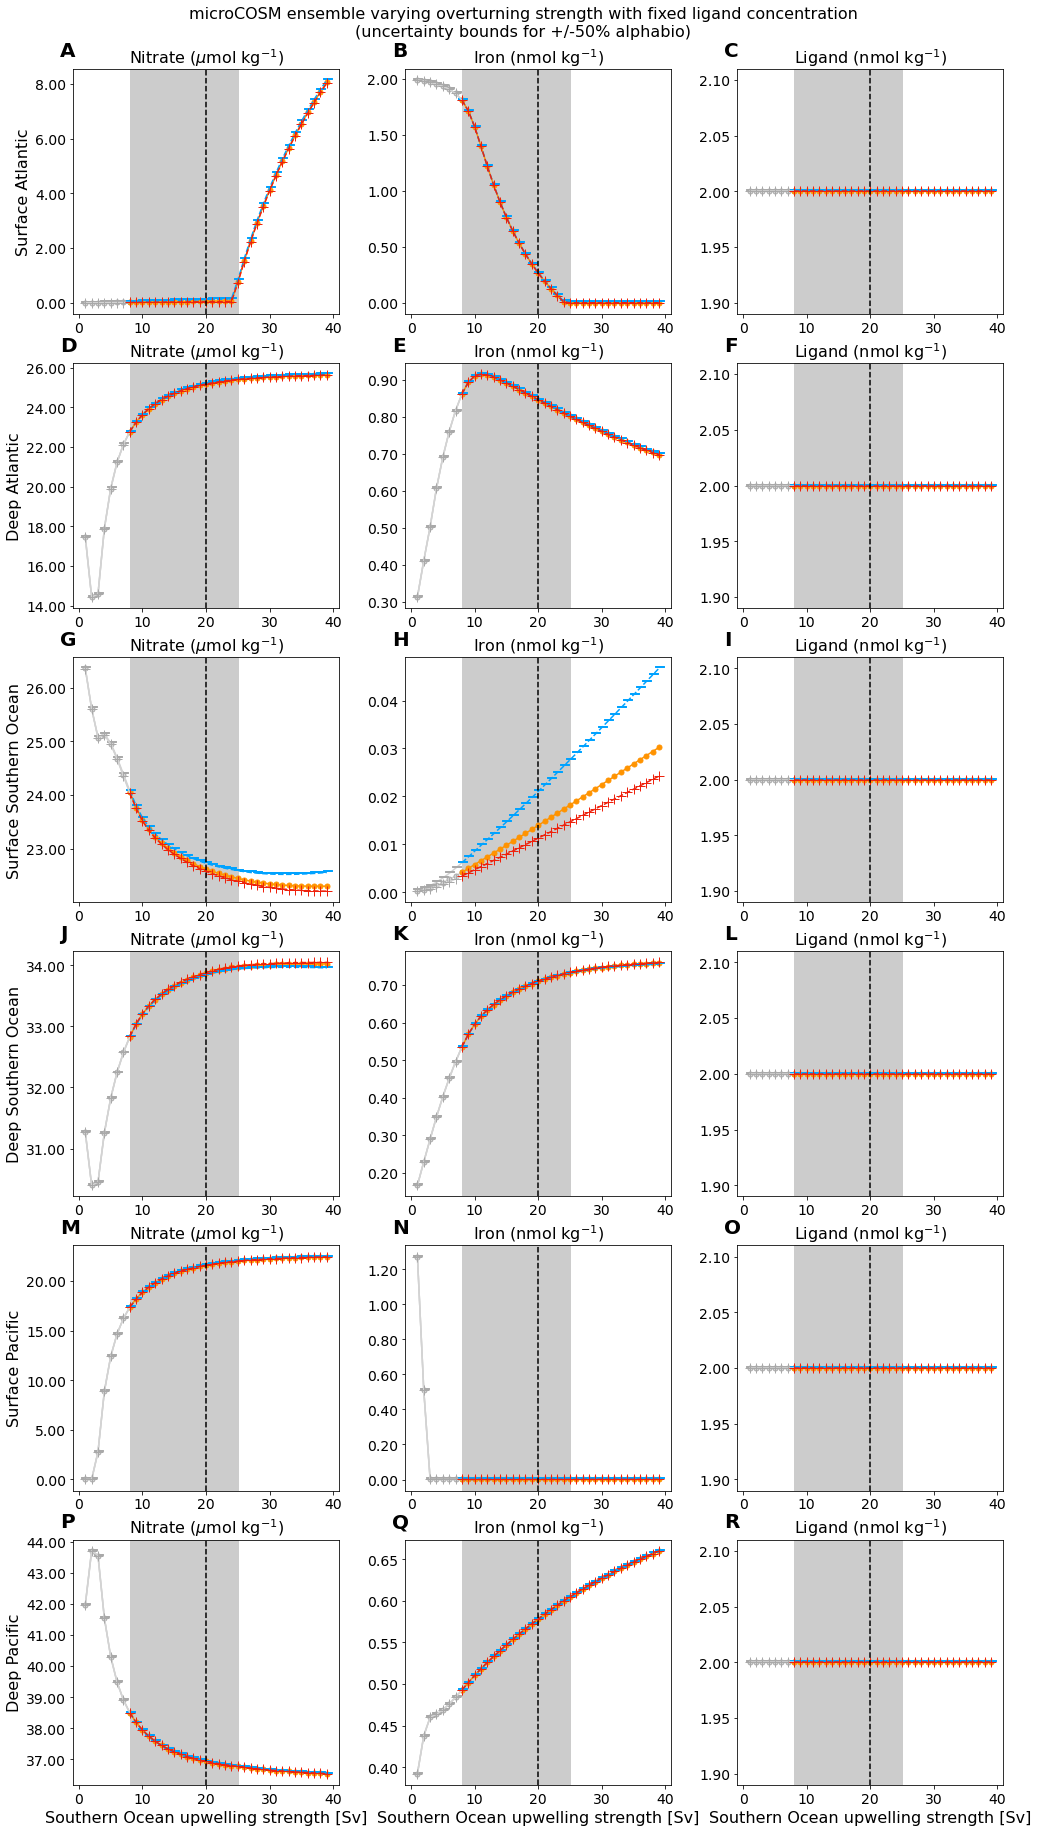

In [12]:
f2a = plot_concentrations(perturbation_markers,
                          basin_names,
                          ensemble_fixedlig_output['cntrl'],
                          lower_bound=ensemble_fixedlig_output["deca"],
                          upper_bound=ensemble_fixedlig_output["inca"],
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text="microCOSM ensemble varying overturning strength with fixed ligand concentration\n(uncertainty bounds for +/-50% alphabio)",
                         )
f2a.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_abio_uncertainty_concentrations.pdf".format(fnadd,psi_max),
        facecolor   = f2a.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

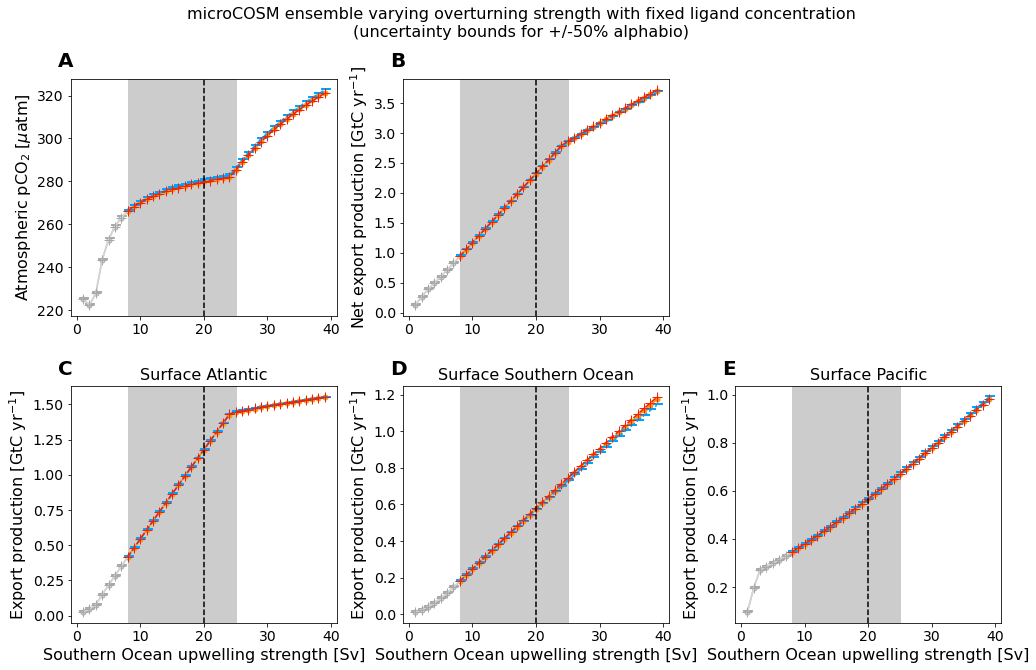

In [13]:
f2b = plot_export_pco2(perturbation_markers,
                          basin_names,
                          ensemble_fixedlig_output['cntrl'],
                          lower_bound=ensemble_fixedlig_output["deca"],
                          upper_bound=ensemble_fixedlig_output["inca"],
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text="microCOSM ensemble varying overturning strength with fixed ligand concentration\n(uncertainty bounds for +/-50% alphabio)",
                         )
f2b.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_abio_uncertainty_exportpco2.pdf".format(fnadd,psi_max),
        facecolor   = f2b.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

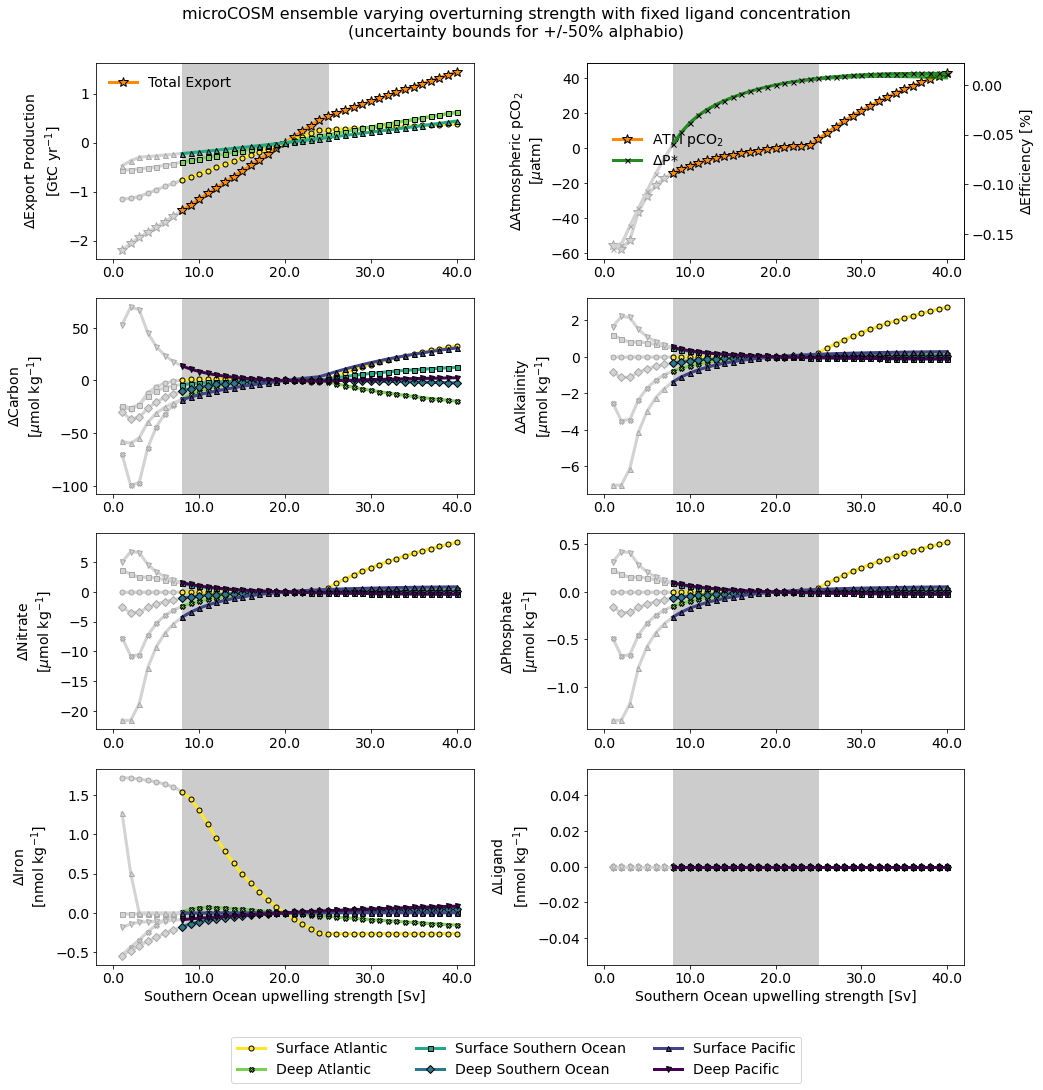

In [14]:
f2c = plot_concentration_anomalies(basin_markers, basin_names,
                         ensemble_fixedlig_input['cntrl'],
                         ensemble_fixedlig_output['cntrl'],
                         ensemble_fixedlig_anomaly['cntrl'],
                         lower_bound=ensemble_fixedlig_anomaly["deca"],
                         upper_bound=ensemble_fixedlig_anomaly["inca"],
                         x_fig = x_fig,
                         y_fig = y_fig,
                         niso  = niso, nmax = nmax,
                         suptitle_text="microCOSM ensemble varying overturning strength with fixed ligand concentration\n(uncertainty bounds for +/-50% alphabio)")

# save the graph
f2c.savefig(
    "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_abio_uncertainty_anomalies.pdf".format(fnadd,psi_max),
    facecolor   = f2c.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)
plt.close()

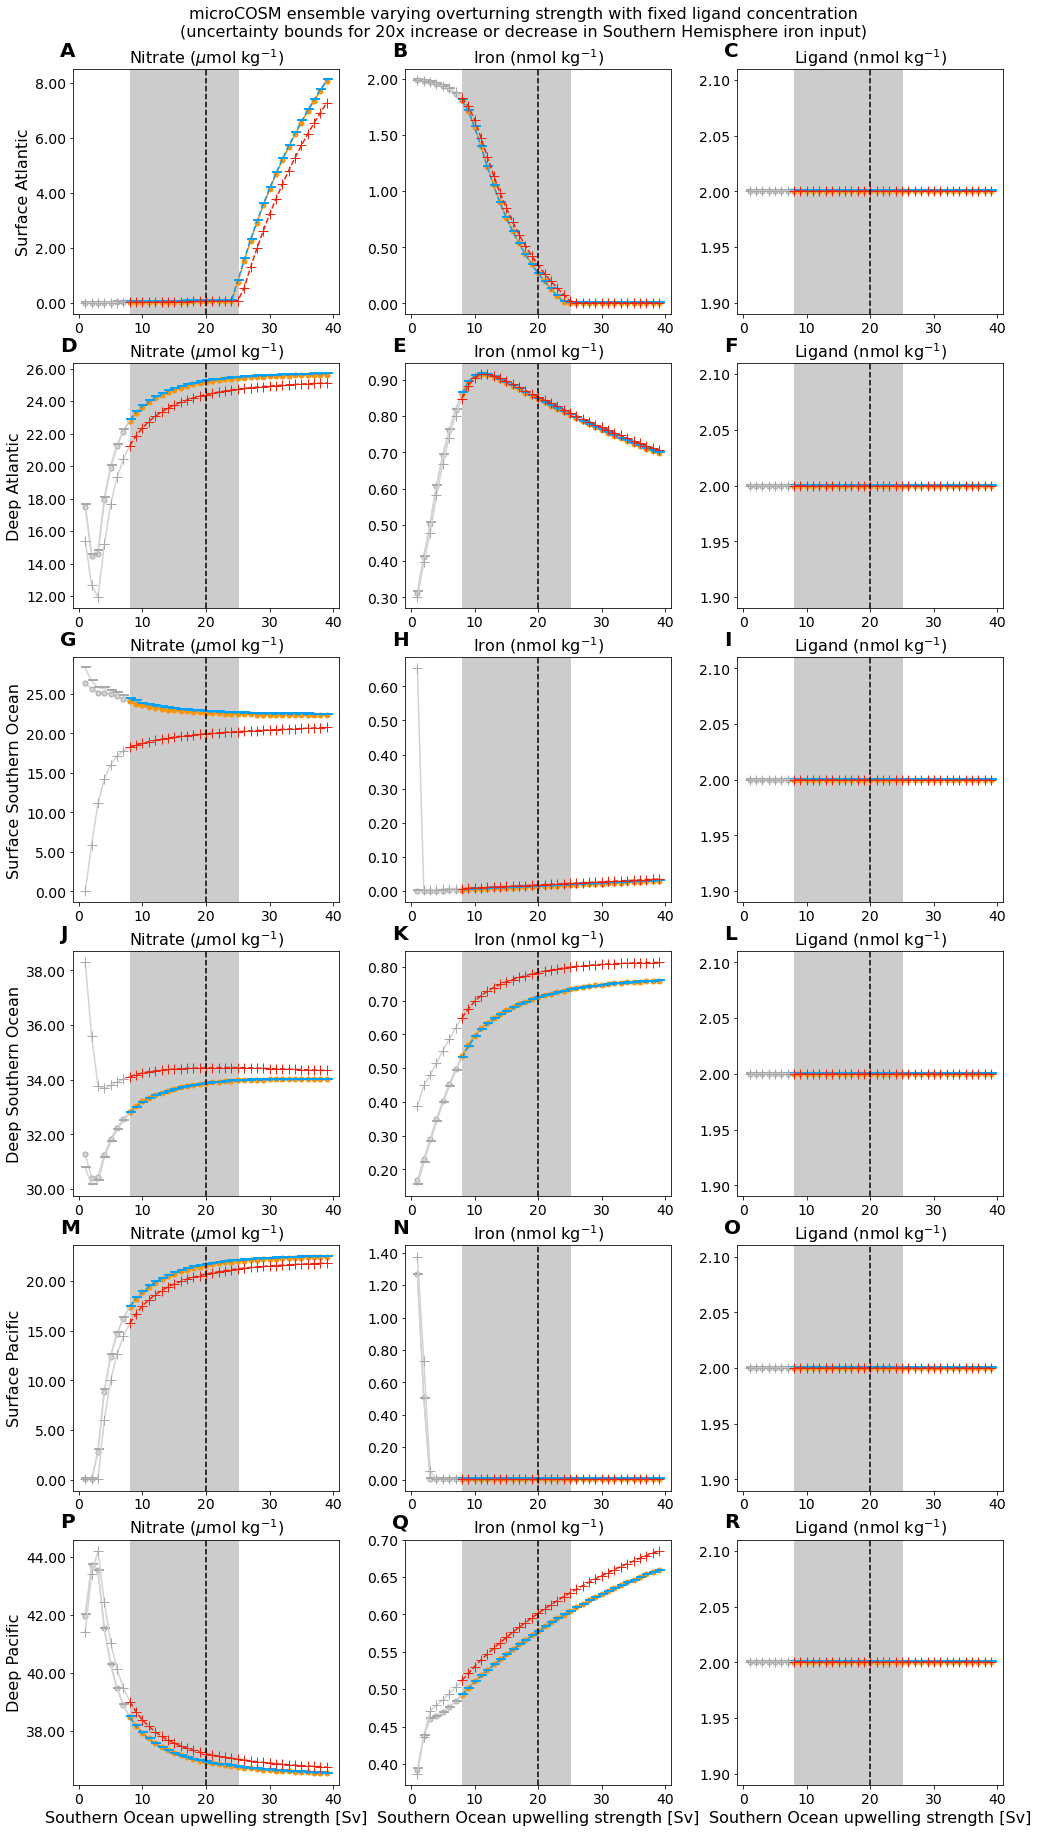

In [15]:
f3a = plot_concentrations(perturbation_markers,
                          basin_names,
                          ensemble_fixedlig_output['cntrl'],
                          lower_bound=ensemble_fixedlig_output["decd"],
                          upper_bound=ensemble_fixedlig_output["incd"],
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text = "microCOSM ensemble varying overturning strength with fixed ligand concentration\n(uncertainty bounds for 20x increase or decrease in Southern Hemisphere iron input)",
                         )
f3a.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_dust_uncertainty_concentrations.pdf".format(fnadd,psi_max),
        facecolor   = f3a.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

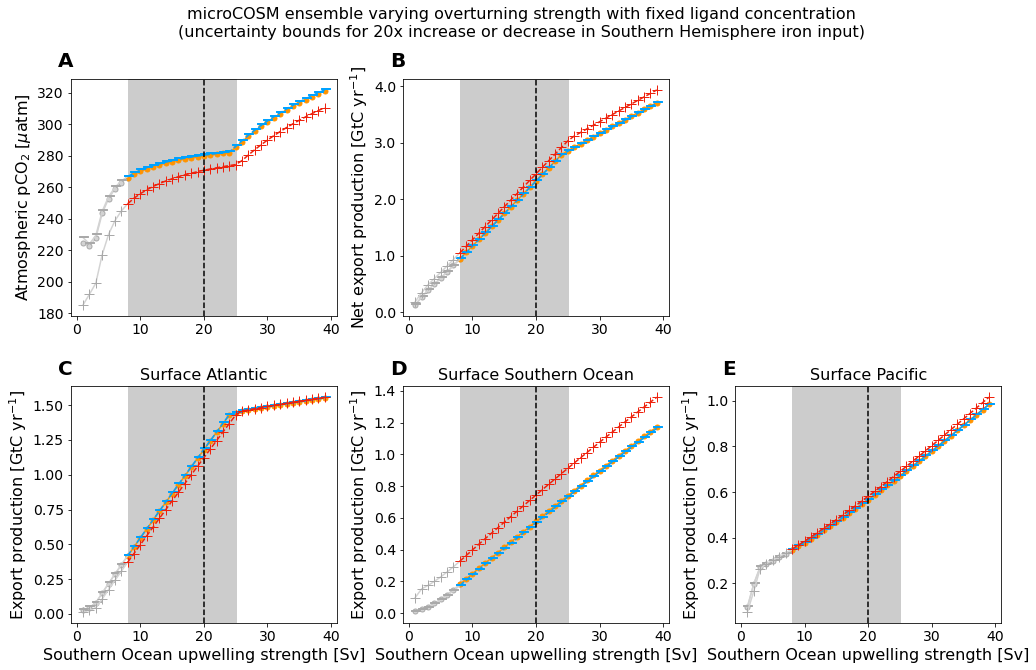

In [16]:
f3b = plot_export_pco2(perturbation_markers,
                          basin_names,
                          ensemble_fixedlig_output['cntrl'],
                          lower_bound=ensemble_fixedlig_output["decd"],
                          upper_bound=ensemble_fixedlig_output["incd"],
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text = "microCOSM ensemble varying overturning strength with fixed ligand concentration\n(uncertainty bounds for 20x increase or decrease in Southern Hemisphere iron input)",
                         )
f3b.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_dust_uncertainty_exportpco2.pdf".format(fnadd,psi_max),
        facecolor   = f3b.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

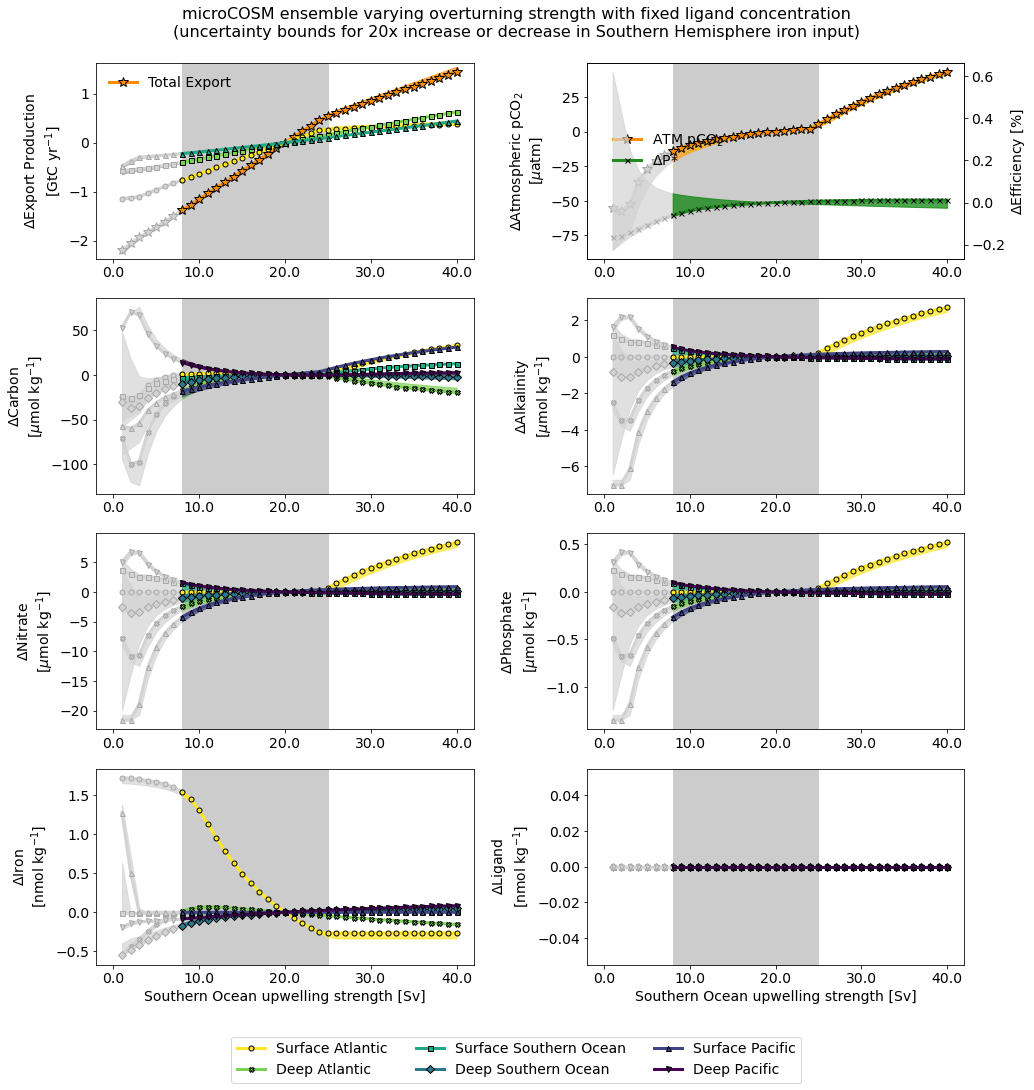

In [17]:
f3c = plot_concentration_anomalies(basin_markers, basin_names,
                         ensemble_fixedlig_input['cntrl'],
                         ensemble_fixedlig_output['cntrl'],
                         ensemble_fixedlig_anomaly['cntrl'],
                         lower_bound=ensemble_fixedlig_anomaly["decd"],
                         upper_bound=ensemble_fixedlig_anomaly["incd"],
                         x_fig = x_fig,
                         y_fig = y_fig,
                         niso  = niso, nmax = nmax,
                         suptitle_text = "microCOSM ensemble varying overturning strength with fixed ligand concentration\n(uncertainty bounds for 20x increase or decrease in Southern Hemisphere iron input)")

# save the graph
f3c.savefig(
    "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_dust_uncertainty_anomalies.pdf".format(fnadd,psi_max),
    facecolor   = f3c.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)
plt.close()

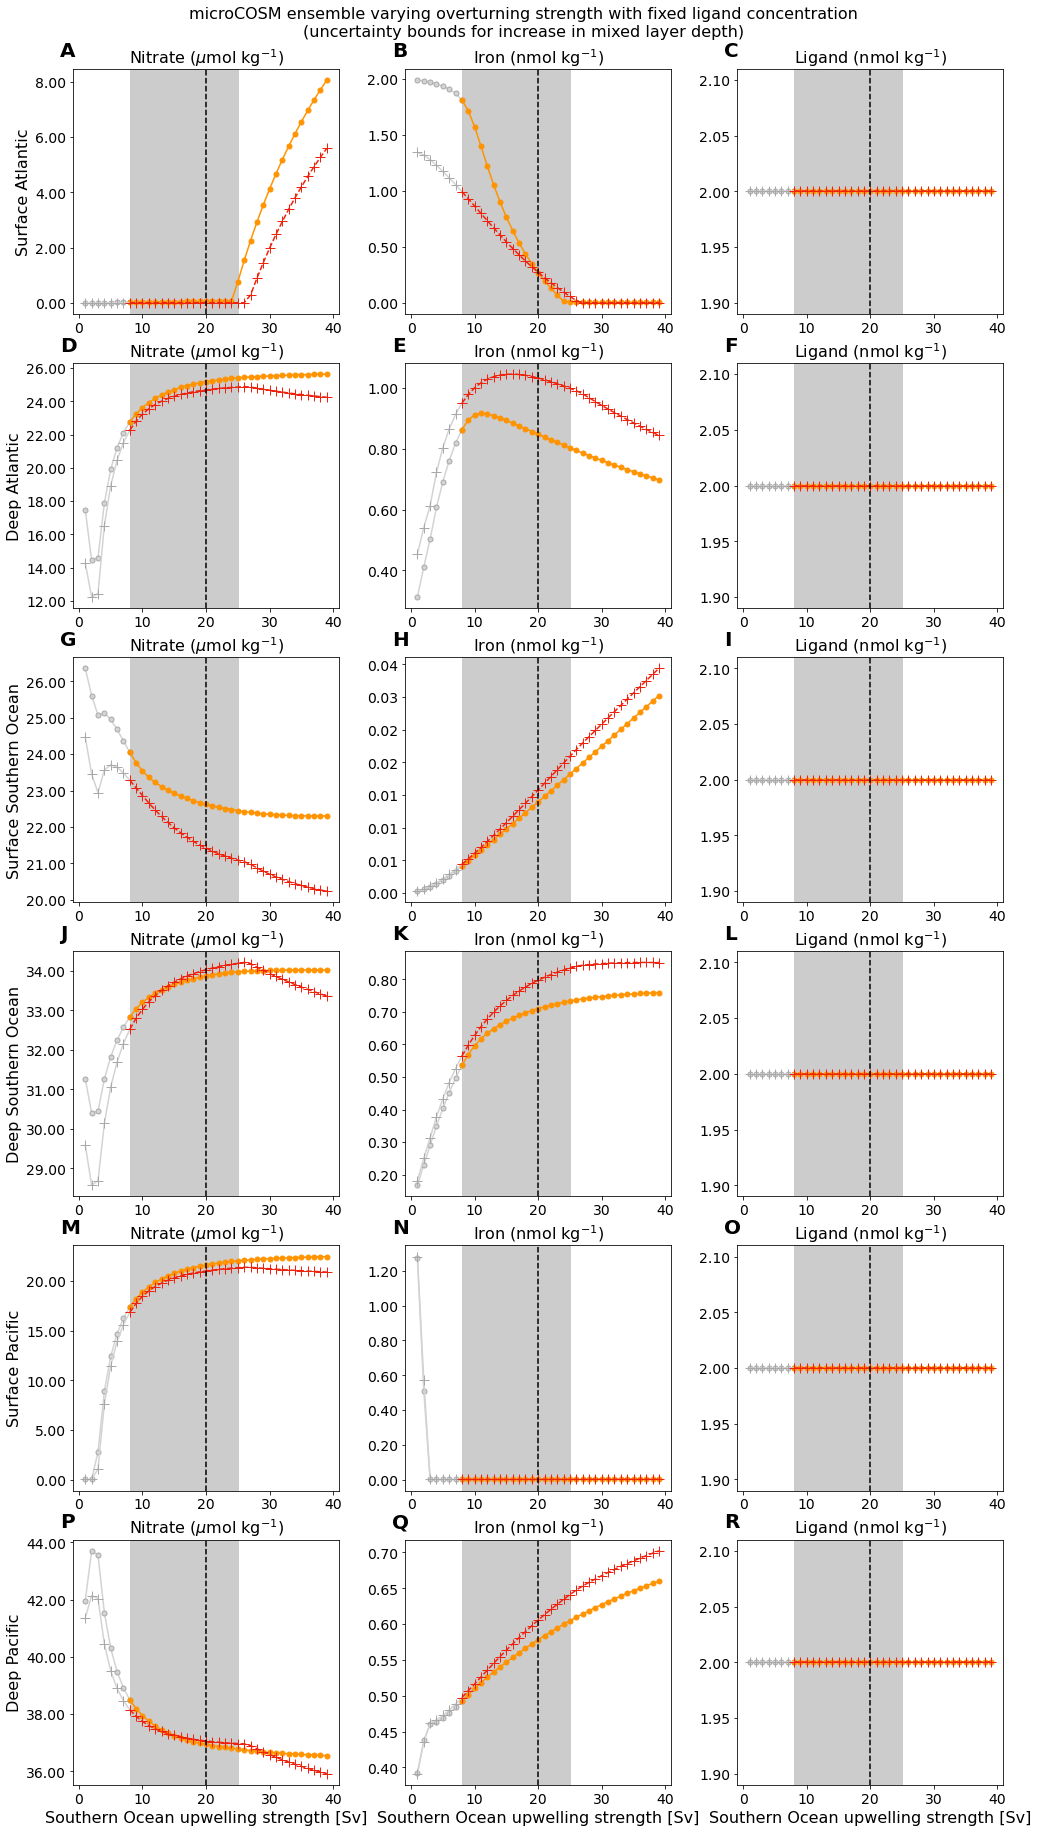

In [18]:
f4a = plot_concentrations(perturbation_markers,
                          basin_names,
                          ensemble_fixedlig_output['cntrl'],
                          lower_bound=None,
                          upper_bound=ensemble_fixedlig_output["incmld"],
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text = "microCOSM ensemble varying overturning strength with fixed ligand concentration\n(uncertainty bounds for increase in mixed layer depth)",
                         )
f4a.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_mld2k_uncertainty_concentrations.pdf".format(fnadd,psi_max),
        facecolor   = f4a.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

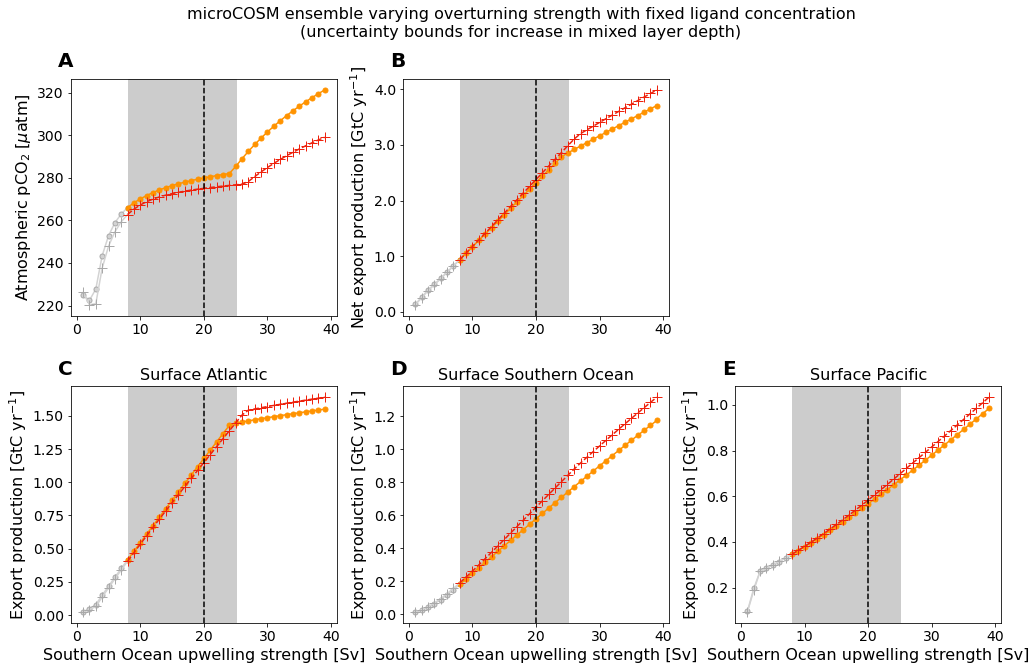

In [19]:
f4b = plot_export_pco2(perturbation_markers,
                          basin_names,
                          ensemble_fixedlig_output['cntrl'],
                          lower_bound=None,
                          upper_bound=ensemble_fixedlig_output["incmld"],
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text = "microCOSM ensemble varying overturning strength with fixed ligand concentration\n(uncertainty bounds for increase in mixed layer depth)",
                         )
f4b.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_mld2k_uncertainty_exportpco2.pdf".format(fnadd,psi_max),
        facecolor   = f4b.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

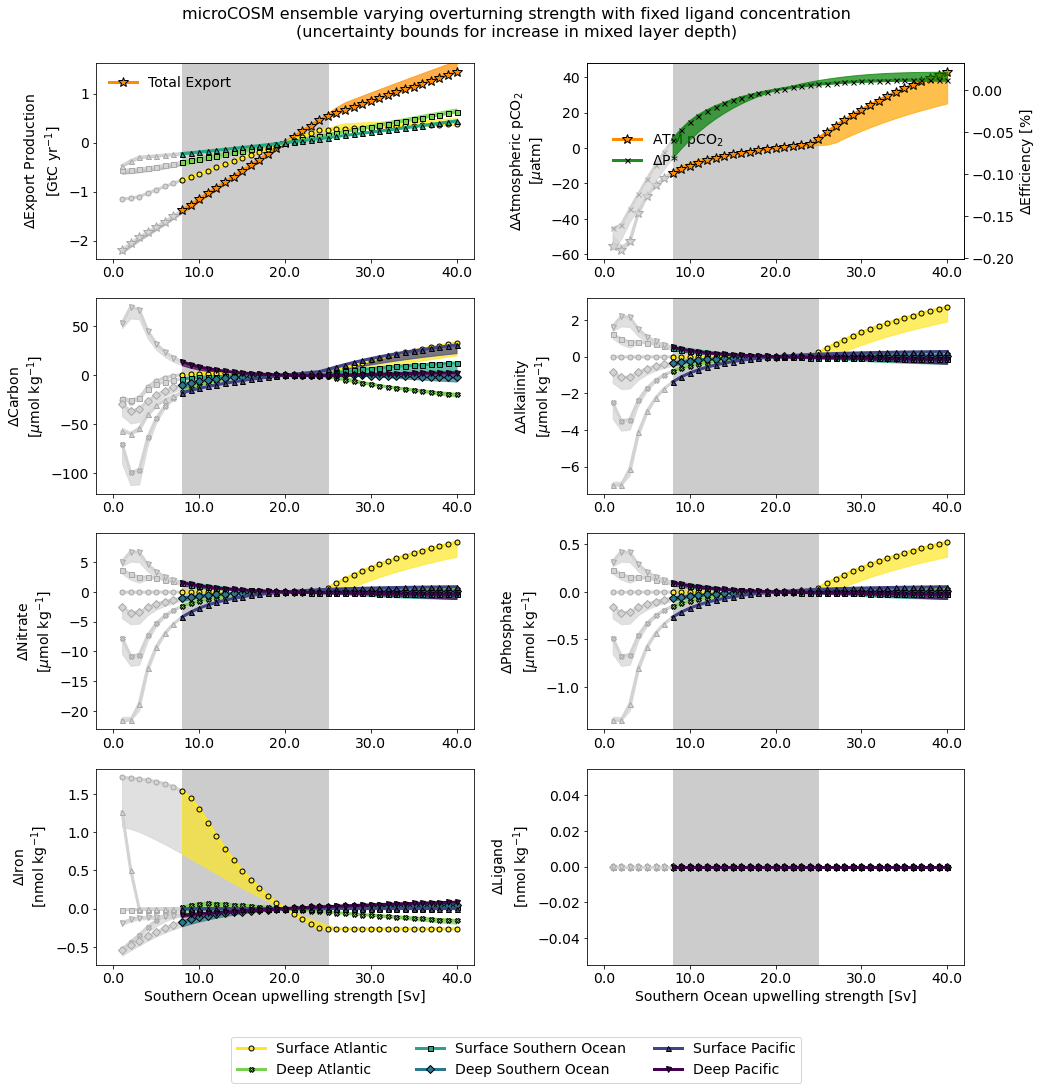

In [20]:
f4c = plot_concentration_anomalies(basin_markers, basin_names,
                         ensemble_fixedlig_input['cntrl'],
                         ensemble_fixedlig_output['cntrl'],
                         ensemble_fixedlig_anomaly['cntrl'],
                         lower_bound=ensemble_fixedlig_anomaly["cntrl"],
                         upper_bound=ensemble_fixedlig_anomaly["incmld"],
                         x_fig = x_fig,
                         y_fig = y_fig,
                         niso  = niso, nmax = nmax,
                         suptitle_text = "microCOSM ensemble varying overturning strength with fixed ligand concentration\n(uncertainty bounds for increase in mixed layer depth)",
)

# save the graph
f4c.savefig(
    "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_mld2k_uncertainty_anomalies.pdf".format(fnadd,psi_max),
    facecolor   = f4c.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)
plt.close()

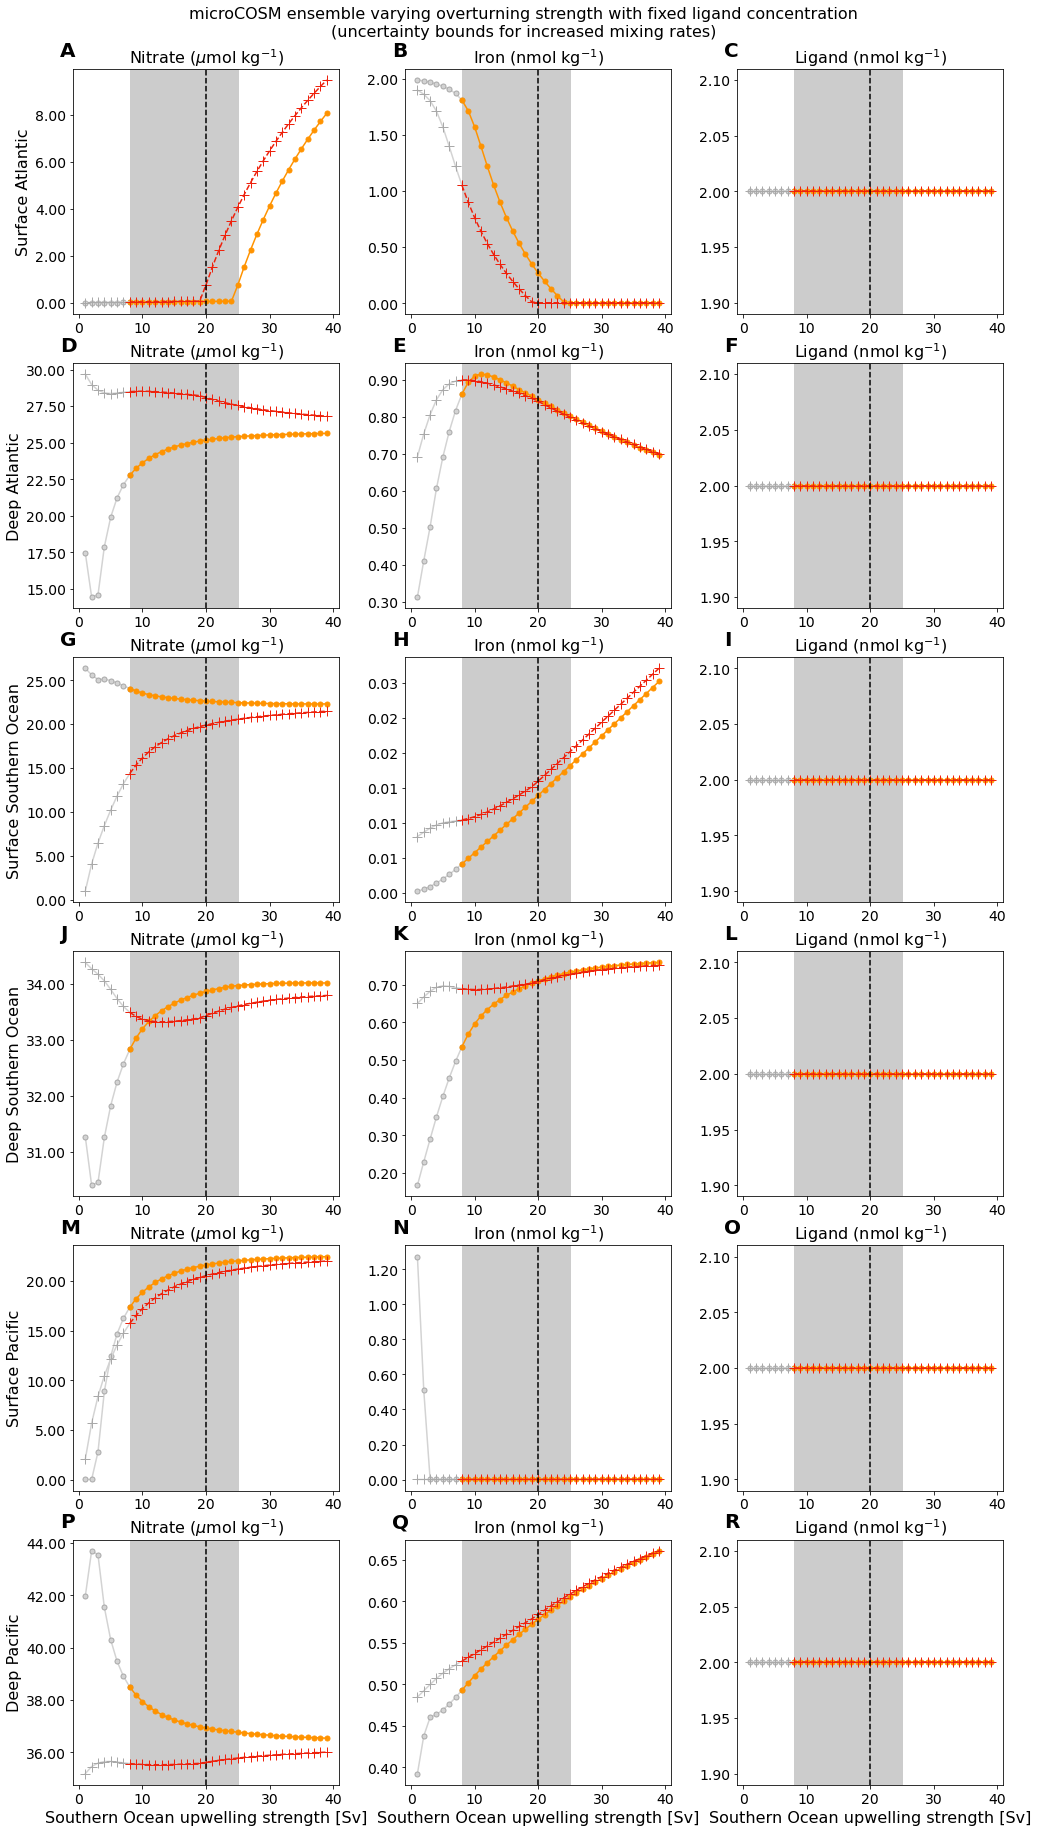

In [21]:
f5a = plot_concentrations(perturbation_markers,
                          basin_names,
                          ensemble_fixedlig_output['cntrl'],
                          lower_bound=None,
                          upper_bound=ensemble_fixedlig_output["incmix"],
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text = "microCOSM ensemble varying overturning strength with fixed ligand concentration\n(uncertainty bounds for increased mixing rates)",
                         )
f5a.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_mixing_uncertainty_concentrations.pdf".format(fnadd,psi_max),
        facecolor   = f5a.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

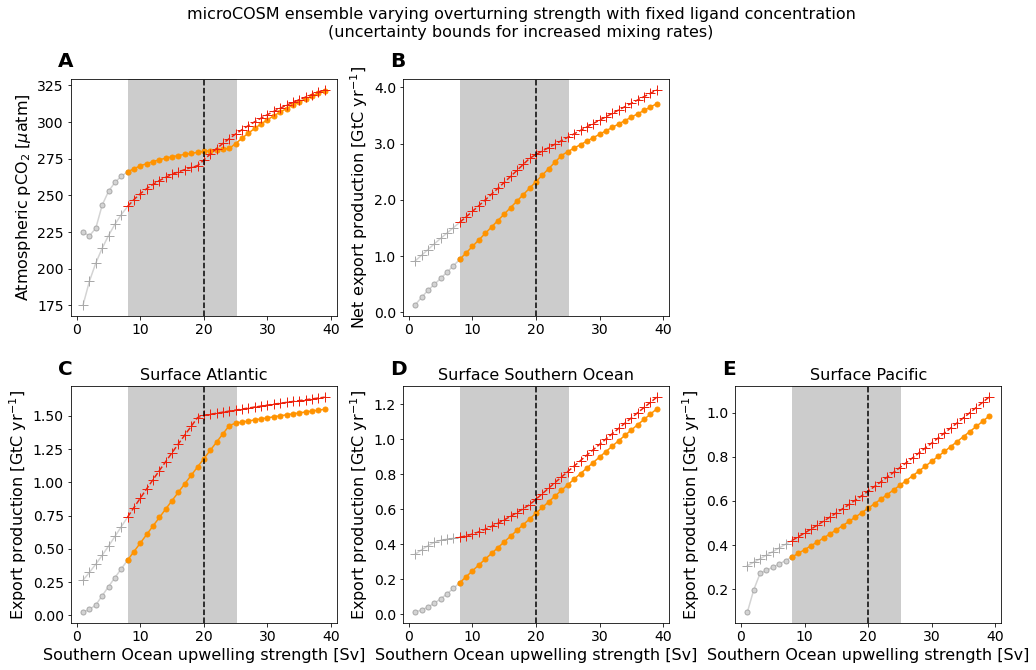

In [22]:
f5b = plot_export_pco2(perturbation_markers,
                          basin_names,
                          ensemble_fixedlig_output['cntrl'],
                          lower_bound=None,
                          upper_bound=ensemble_fixedlig_output["incmix"],
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text = "microCOSM ensemble varying overturning strength with fixed ligand concentration\n(uncertainty bounds for increased mixing rates)",
                         )
f5b.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_mixing_uncertainty_exportpco2.pdf".format(fnadd,psi_max),
        facecolor   = f5b.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

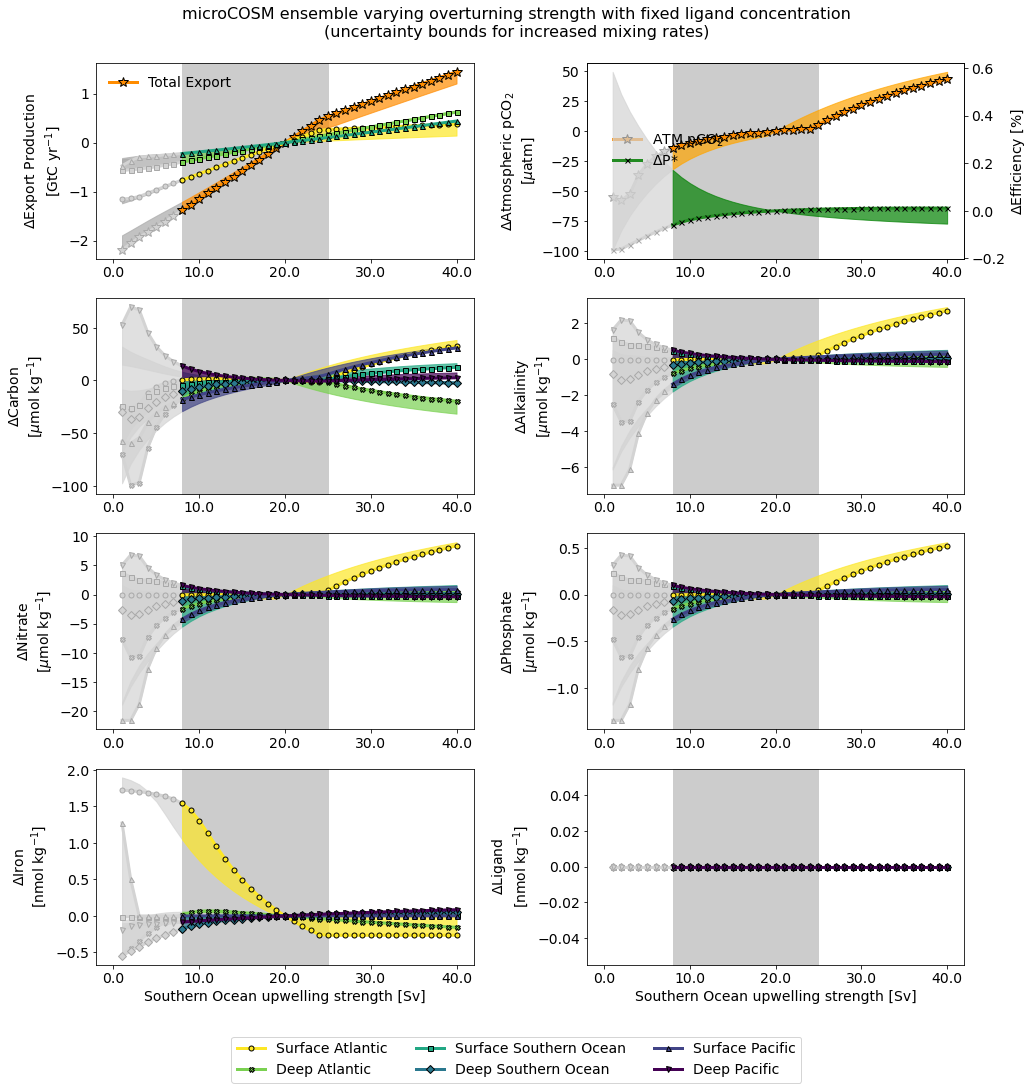

In [23]:
f5c = plot_concentration_anomalies(basin_markers, basin_names,
                         ensemble_fixedlig_input['cntrl'],
                         ensemble_fixedlig_output['cntrl'],
                         ensemble_fixedlig_anomaly['cntrl'],
                         lower_bound=ensemble_fixedlig_anomaly["cntrl"],
                         upper_bound=ensemble_fixedlig_anomaly["incmix"],
                         x_fig = x_fig,
                         y_fig = y_fig,
                         niso  = niso, nmax = 41,
                         suptitle_text = "microCOSM ensemble varying overturning strength with fixed ligand concentration\n(uncertainty bounds for increased mixing rates)",
)

# save the graph
f5c.savefig(
    "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_mixing_uncertainty_anomalies.pdf".format(fnadd,psi_max),
    facecolor   = f5c.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)
plt.close()

## 3. Now, we'll run the same ensemble but with variable ligand concentrations

In [24]:
fadd = "6box"
fnadd = fadd + "variablelt"

load_previous_results=True

if load_previous_results:
    ensemble_variablelig_input['cntrl'] = pd.read_json(
        "run_microCOSM_{0}_psi_{1:.0f}Sv_input.json".format(fnadd, psi_max),
    )
else:        
    # Load steady state values from before
    model_input = pd.read_json(
        "run_microCOSM_{0}_pickup.json".format(fnadd), typ="series"
    ).to_frame()

    # repeat the input parameters and adjust for the ensemble run
    ensemble_variablelig_input['cntrl'] = pd.concat([model_input.T] * niters, ignore_index=True, copy=True)

    ensemble_variablelig_input['cntrl']["nyrs"]  = 1e5
    ensemble_variablelig_input['cntrl']["tout"]  = 100
    ensemble_variablelig_input['cntrl']["psi"]   = psi_var
    #ensemble_variablelig_input['cntrl']["dif"]   = 1e6
    ensemble_variablelig_input['cntrl']["niter"] = niter

    ensemble_variablelig_input['cntrl'].to_json(
        "run_microCOSM_{0}_psi_{1:.0f}Sv_input.json".format(fnadd, psi_max),
    )
ensemble_variablelig_input['cntrl'].iloc[0]

niter                                                         0
nyrs                                                     100000
tout                                                        100
nout                                                       1001
dx            [17000000.0, 17000000.0, 17000000.0, 17000000....
dy            [4000000.0, 4000000.0, 2000000.0, 2000000.0, 8...
dz                [100.0, 3900.0, 100.0, 3900.0, 100.0, 3900.0]
depth                [50.0, 2050.0, 50.0, 2050.0, 50.0, 2050.0]
latitude               [-30.0, -30.0, -70.0, -70.0, 10.0, 10.0]
Kmix          [[[0.0, 1.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0...
Rremin        [[-1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0...
Pcir          [[0.0, 0.35000000000000003, 0.15, 0.0, 0.5, 0....
psi                                                           0
dif                                                           0
alphabio                                               0.000006
gamma                                   

Run the experiment

In [25]:
if load_previous_results:
    print(
        "Loading output from: run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(
            fnadd, psi_max
        )
    )
    ensemble_variablelig_output['cntrl'] = pd.read_json(
        "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(fnadd, psi_max),
    )
else:
    run_in_parallel = check_parallel()
    
    start = time.time()
    if run_in_parallel:  # about 40s on 8 core late 2013 iMac i7 3.5Ghz
        # Run in parallel using pkg/pandarallel's "parallel_apply"
        import multiprocessing
    
        ensemble_variablelig_output['cntrl'] = run_microcosm(
            ensemble_variablelig_input['cntrl'], basin_names, workers=multiprocessing.cpu_count()
        )
    else:  # about 3 mins in serial
        # OR in series using pandas' "apply" to run through rows of a data frame of inputs
        ensemble_variablelig_output['cntrl'] = run_microcosm(ensemble_variablelig_input['cntrl'], basin_names, workers=1)
    end = time.time()
    print("{0} seconds".format((end - start)))

    ensemble_variablelig_output['cntrl']["pstar"] = recalc_pstar(ensemble_variablelig_input['cntrl'],ensemble_variablelig_output['cntrl'])

# save the output
    print(
        "Saving output to: run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(
            fnadd, psi_max
        )
    )
    ensemble_variablelig_output['cntrl'].to_json(
    "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(fnadd, psi_max)
    )

ensemble_variablelig_anomaly["cntrl"] = ensemble_variablelig_output["cntrl"].subtract(
                                        ensemble_variablelig_output["cntrl"].loc[
                                        ensemble_variablelig_output["cntrl"].psi == cntrl_psi
                                       ].values
                                     )

Loading output from: run_microCOSM_6boxvariablelt_psi_40Sv_output.json


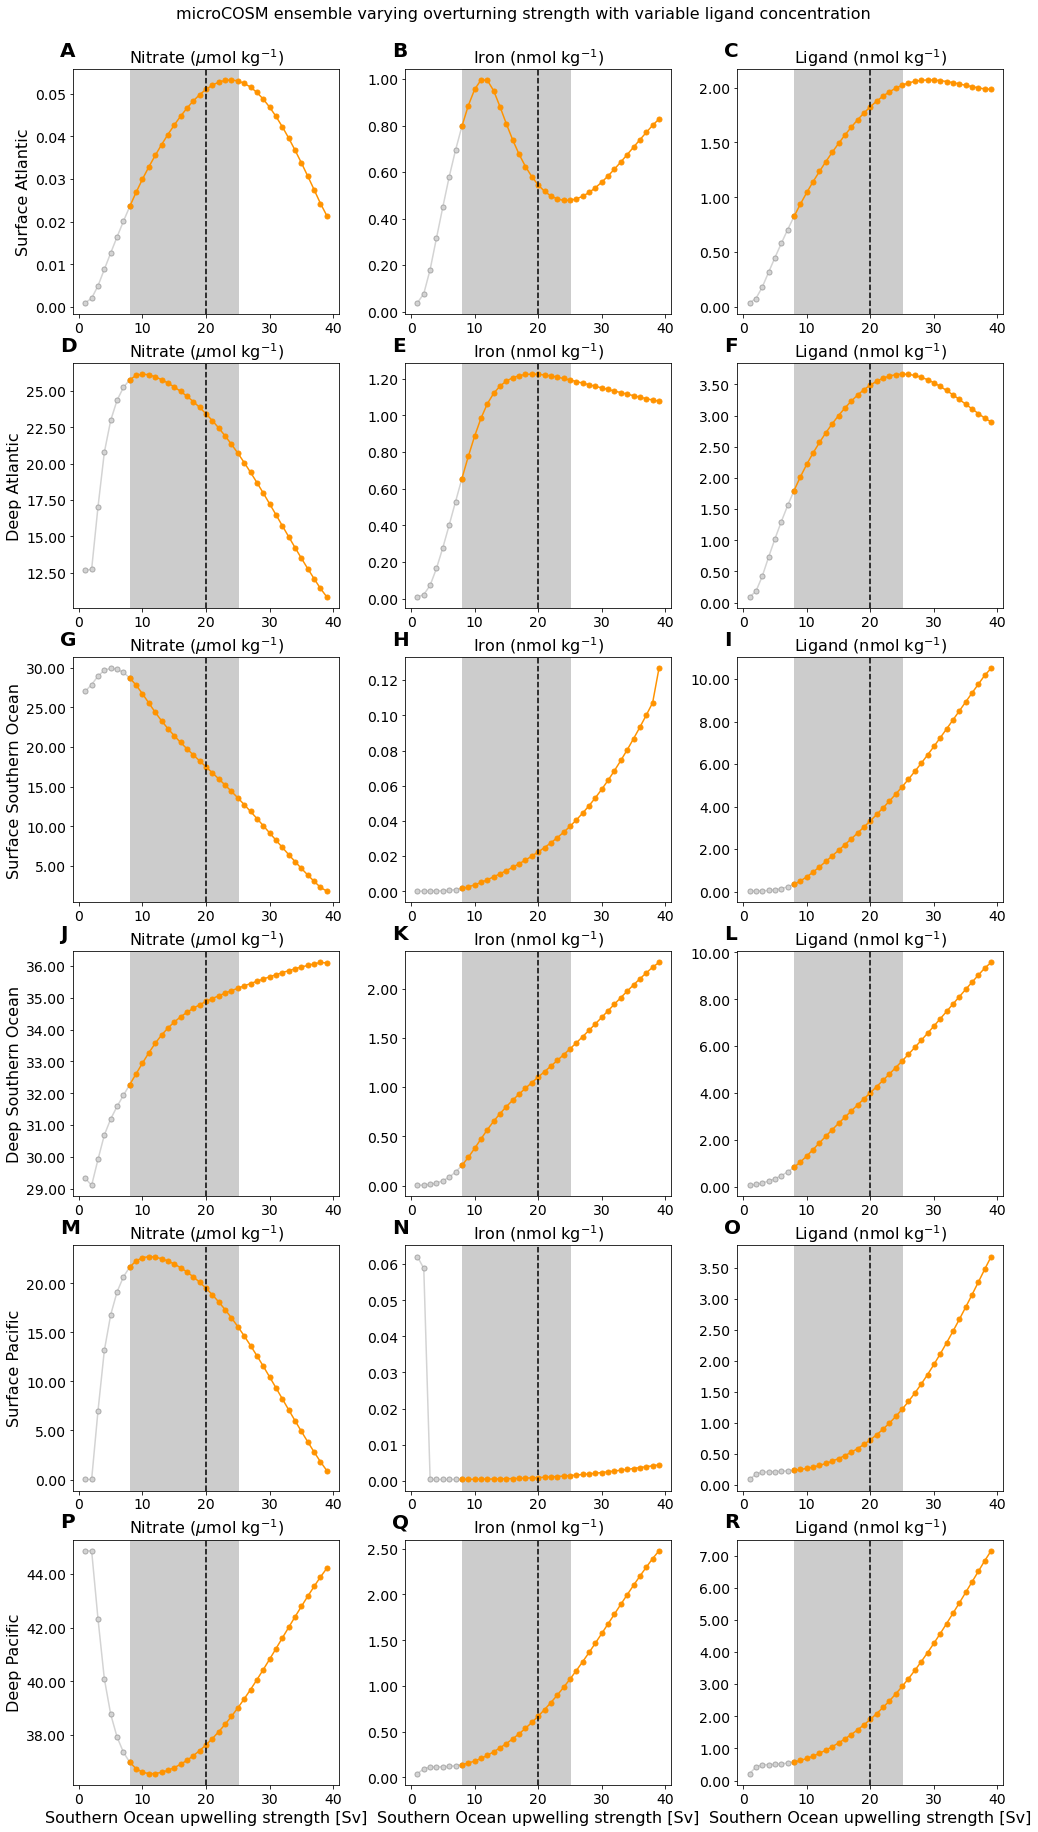

In [27]:
f6a = plot_concentrations(perturbation_markers,
                          basin_names,
                          ensemble_variablelig_output['cntrl'],
                          lower_bound=None,
                          upper_bound=None,
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text = "microCOSM ensemble varying overturning strength with variable ligand concentration",
                         )
f6a.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_control_concentrations.pdf".format(fnadd,psi_max),
        facecolor   = f6a.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

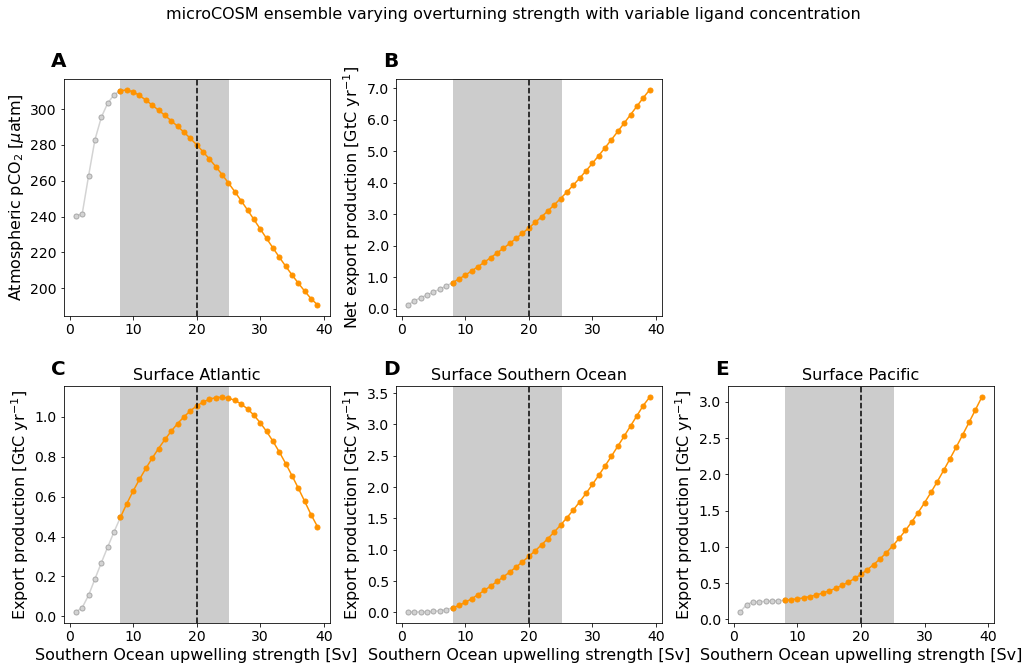

In [26]:
f6b = plot_export_pco2(perturbation_markers,
                          basin_names,
                          ensemble_variablelig_output['cntrl'],
                          lower_bound=None,
                          upper_bound=None,
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text = "microCOSM ensemble varying overturning strength with variable ligand concentration",
                         )
f6b.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_control_exportpco2.pdf".format(fnadd,psi_max),
        facecolor   = f6b.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

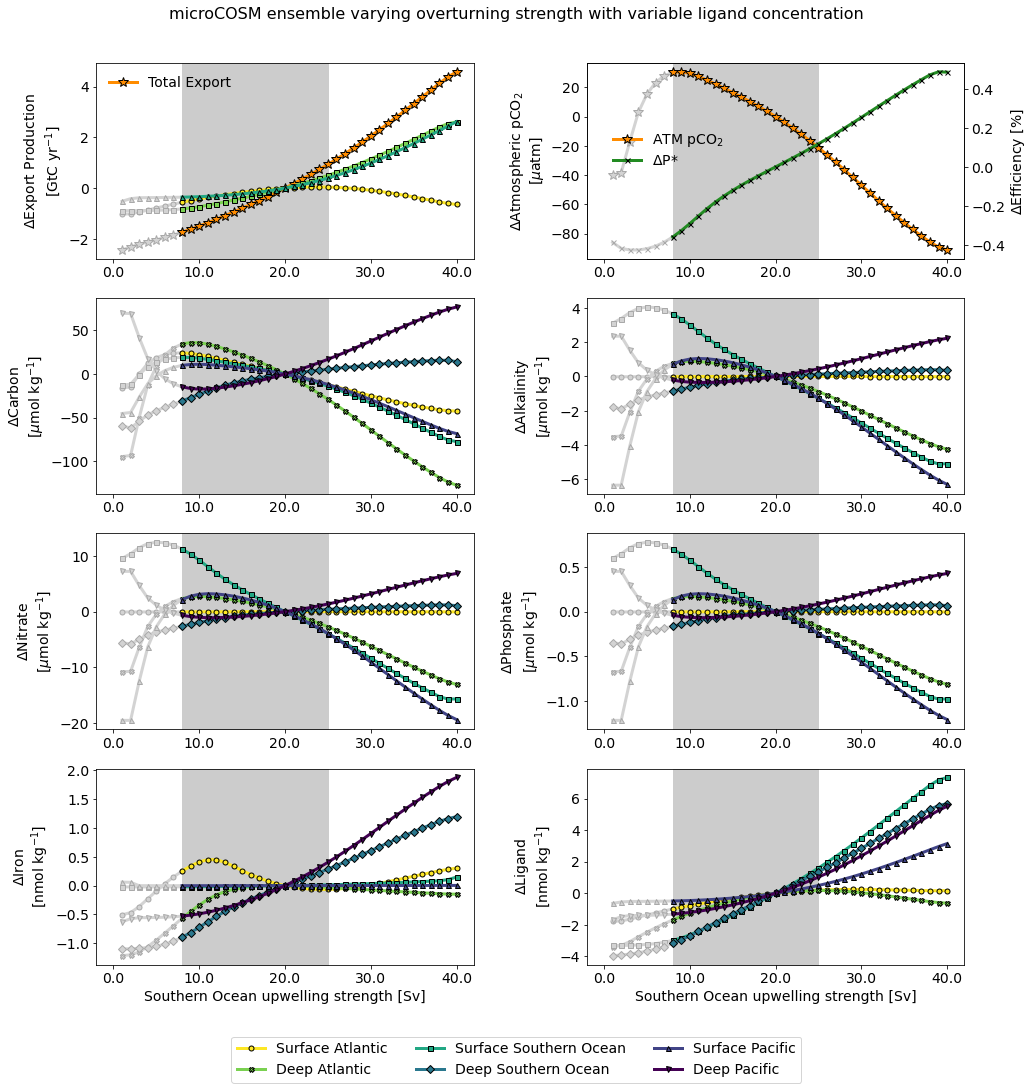

In [28]:
f6c = plot_concentration_anomalies(basin_markers, basin_names,
                         ensemble_variablelig_input['cntrl'],
                         ensemble_variablelig_output['cntrl'],
                         ensemble_variablelig_anomaly['cntrl'],
                         lower_bound=None,
                         upper_bound=None,
                         x_fig = x_fig,
                         y_fig = y_fig,
                         niso  = niso, nmax = nmax,
                         suptitle_text = "microCOSM ensemble varying overturning strength with variable ligand concentration",
)

# save the graph
f6c.savefig(
    "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_control_anomalies.pdf".format(fnadd,psi_max),
    facecolor   = f6c.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)
plt.close()

Load previous model runs and plot uncertainty

In [29]:
# Run senitivity control run from the standard control pickup (do this here for variable atmospheric CO2)
sensexpt = ["deca","inca","decd","incd","incmld","incmix","decgol","incgol"]

if not load_previous_results:    
    # Load steady state values from standard control pickup
    model_input = pd.concat([
        pd.read_json(
            "run_microCOSM_{0}_pickup.json".format(
                fnadd
            ), 
            typ='series'
            ).to_frame().T
        ] * len(sensexpt), ignore_index=True, copy=True)

    nsiter   = np.arange(len(sensexpt))
    model_input['niter'] = nsiter
    
    # Alter the input parameters as needed for each experiment
    model_input.at[0, 'alphabio'] = 3e-6
    model_input.at[1, 'alphabio'] = 9e-6
    fetmp                         = model_input.loc[2, 'sourceFe'].copy()
    fetmp[2]                      = fetmp[2]/20
    model_input.at[2, 'sourceFe'] = fetmp
    fetmp                         = model_input.loc[3, 'sourceFe'].copy()
    fetmp[2]                      = fetmp[2]*20
    model_input.at[3, 'sourceFe'] = fetmp
    newdz = np.array([ 2000.0, 2000.0, 100.0, 3900.0, 100.0, 3900.0])
    model_input.at[4, 'dz']       = newdz
    model_input.at[5, 'dif']      = 3.0e6
    fadd, lig_gamma, lig_lambda, lig_conc = get_ligand_parameters(
        fadd='6box',gamma_over_lambda=4398.0*0.75,gamma=5.0e-5,lig_conc=2.0,R_cp=106.0
    )
    model_input.at[6, 'gamma']   = lig_gamma[0]
    model_input.at[6, 'lambda']  = lig_lambda[0]
    fadd, lig_gamma, lig_lambda, lig_conc = get_ligand_parameters(
        fadd='6box',gamma_over_lambda=4398.0*1.25,gamma=5.0e-5,lig_conc=2.0,R_cp=106.0
    )
    model_input.at[7, 'gamma']   = lig_gamma[0]
    model_input.at[7, 'lambda']  = lig_lambda[0]
    fadd, lig_gamma, lig_lambda, lig_conc = get_ligand_parameters(
        fadd='6box',gamma_over_lambda=4398.0*1.25,gamma=5.0e-5,lig_conc=2.0,R_cp=106.0
    )
    
    # Check to see if the pandarallel package is available?
    run_in_parallel = check_parallel()
    # run_in_parallel=False

    start = time.time()
    if run_in_parallel:  # about 40s on 8 core late 2013 iMac i7 3.5Ghz
        # Run in parallel using pkg/pandarallel's "parallel_apply"
        import multiprocessing

        model_output = run_microcosm(
            model_input, basin_names, workers=multiprocessing.cpu_count()
        )
    else:  # about 3 mins in serial
        # OR in series using pandas' "apply" to run through rows of a data frame of inputs
        model_output = run_microcosm(model_input, basin_names, workers=1)
    end = time.time()
    print("{0} seconds".format((end - start)))

    # output array such that it could be used to restart the next simulation
    parms=['niter', 'nyrs', 'tout', 'nout', 'dx', 'dy', 'dz', 'depth', 'latitude',
           'Kmix', 'Rremin', 'Pcir', 'psi', 'dif', 'alphabio', 'gamma', 'lambda',
           'dlambdadz', 'sourceFe', 'wind', 'fopen']

    for si,sens in enumerate(sensexpt):
        pd.concat(
            [
            model_input.loc[si,parms],
            pd.Series({
                  "theta"     : model_output.loc[si,["t" + name.lower() for name in basin_names]].to_numpy(),
                  "salt"      : model_output.loc[si,["s" + name.lower() for name in basin_names]].to_numpy(),
                  "carbon"    : model_output.loc[si,["c" + name.lower() for name in basin_names]].to_numpy(),
                  "alkalinity": model_output.loc[si,["a" + name.lower() for name in basin_names]].to_numpy(),
                  "phosphate" : model_output.loc[si,["p" + name.lower() for name in basin_names]].to_numpy(),
                  "nitrate"   : model_output.loc[si,["n" + name.lower() for name in basin_names]].to_numpy(),
                  "iron"      : model_output.loc[si,["f" + name.lower() for name in basin_names]].to_numpy(),
                  "ligand"    : model_output.loc[si,["l" + name.lower() for name in basin_names]].to_numpy(),
                  "atmpco2"   : model_output.loc[si,'atmpco2'],
                      }),
            ]
            ).transpose().to_json("run_microCOSM_" + fnadd.replace(fnadd,fnadd+sens) + "_pickup.json")

In [30]:
for sens in sensexpt:
    if load_previous_results:
        print(
            "Loading output from: run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(
                fnadd.replace(fnadd,fnadd+sens), psi_max,
            )
        )
    
        ensemble_variablelig_input[sens] = pd.read_json(
            "run_microCOSM_{0}_psi_{1:.0f}Sv_input.json".format(
                fnadd.replace(fnadd,fnadd+sens), psi_max,
            )
        )
        
        ensemble_variablelig_output[sens] = pd.read_json(
            "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(
                fnadd.replace(fnadd,fnadd+sens), psi_max,
            )
        )
    else:
        print(
            "Generating new output for microCOSM_{0}".format(
                fnadd.replace(fnadd,fnadd+sens),
            )
        )
        
        # Load steady state values from before
        model_input = pd.read_json(
            "run_microCOSM_{0}_pickup.json".format(
                fnadd.replace(fnadd,fnadd+sens)
            ), 
            typ='series'
        ).to_frame()
    
        # repeat the input parameters and adjust for the ensemble run
        ensemble_variablelig_input[sens] = pd.concat([model_input.T] * niters, ignore_index=True, copy=True)
        
        ensemble_variablelig_input[sens]["nyrs"]   = 1e4
        ensemble_variablelig_input[sens]["tout"]   = 1e1
        ensemble_variablelig_input[sens]["nout"]   = int(ensemble_variablelig_input[sens]["nyrs"].iloc[0]/ensemble_variablelig_input[sens]["tout"].iloc[0])
        ensemble_variablelig_input[sens]["psi"]    = psi_var
        ensemble_variablelig_input[sens]["niter"]  = niter
        
        ensemble_variablelig_input[sens].to_json(
            "run_microCOSM_{0}_psi_{1:.0f}Sv_input.json".format(
                fnadd.replace(fnadd,fnadd+sens), psi_max,
            ),
        )
        
        # Check to see if the pandarallel package is available?
        run_in_parallel = check_parallel()
        # run_in_parallel=False
    
        start = time.time()
        if run_in_parallel:  # about 40s on 8 core late 2013 iMac i7 3.5Ghz
            # Run in parallel using pkg/pandarallel's "parallel_apply"
            import multiprocessing
    
            ensemble_variablelig_output[sens] = run_microcosm(
                ensemble_variablelig_input[sens], basin_names, workers=multiprocessing.cpu_count()
            )
        else:  # about 3 mins in serial
            # OR in series using pandas' "apply" to run through rows of a data frame of inputs
            ensemble_variablelig_output[sens] = run_microcosm(ensemble_variablelig_input[sens], basin_names, workers=1)
        end = time.time()
        print("{0} seconds".format((end - start)))

        ensemble_variablelig_output[sens]["pstar"] = recalc_pstar(ensemble_variablelig_input[sens],ensemble_variablelig_output[sens])

        # save the output
        print(
            "Saving output to: run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(
                fnadd.replace(fnadd,fnadd+sens), psi_max,
            )
    
        )
        ensemble_variablelig_output[sens].to_json(
            "run_microCOSM_{0}_psi_{1:.0f}Sv_output.json".format(
                fnadd.replace(fnadd,fnadd+sens), psi_max,
            )
        )
    ensemble_variablelig_anomaly[sens] = ensemble_variablelig_output[sens].subtract(
                                         ensemble_variablelig_output[sens].loc[
                                         ensemble_variablelig_output[sens].psi == cntrl_psi
                                        ].values
    )

Loading output from: run_microCOSM_6boxvariableltdeca_psi_40Sv_output.json
Loading output from: run_microCOSM_6boxvariableltinca_psi_40Sv_output.json
Loading output from: run_microCOSM_6boxvariableltdecd_psi_40Sv_output.json
Loading output from: run_microCOSM_6boxvariableltincd_psi_40Sv_output.json
Loading output from: run_microCOSM_6boxvariableltincmld_psi_40Sv_output.json
Loading output from: run_microCOSM_6boxvariableltincmix_psi_40Sv_output.json
Loading output from: run_microCOSM_6boxvariableltdecgol_psi_40Sv_output.json
Loading output from: run_microCOSM_6boxvariableltincgol_psi_40Sv_output.json


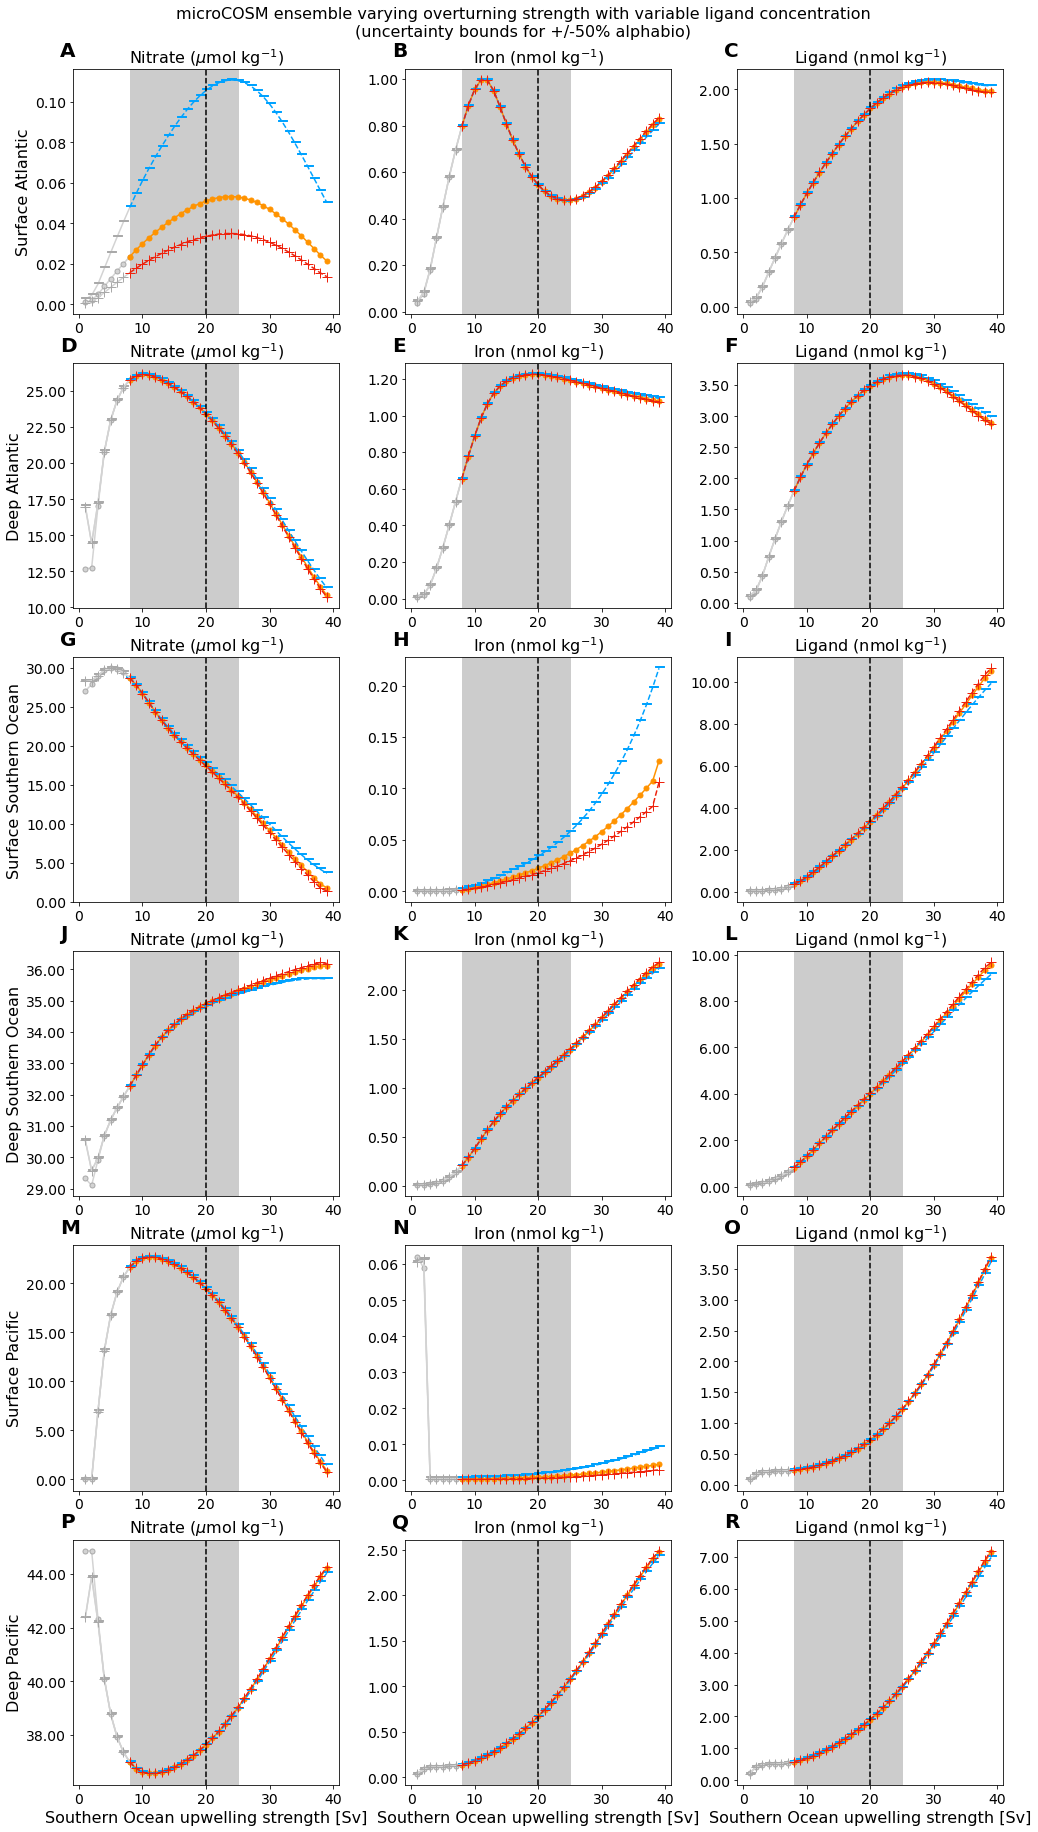

In [31]:
f7a = plot_concentrations(perturbation_markers,
                          basin_names,
                          ensemble_variablelig_output['cntrl'],
                          lower_bound=ensemble_variablelig_output["deca"],
                          upper_bound=ensemble_variablelig_output["inca"],
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text = "microCOSM ensemble varying overturning strength with variable ligand concentration\n(uncertainty bounds for +/-50% alphabio)",
                         )
f7a.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_abio_uncertainty_concentrations.pdf".format(fnadd,psi_max),
        facecolor   = f7a.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

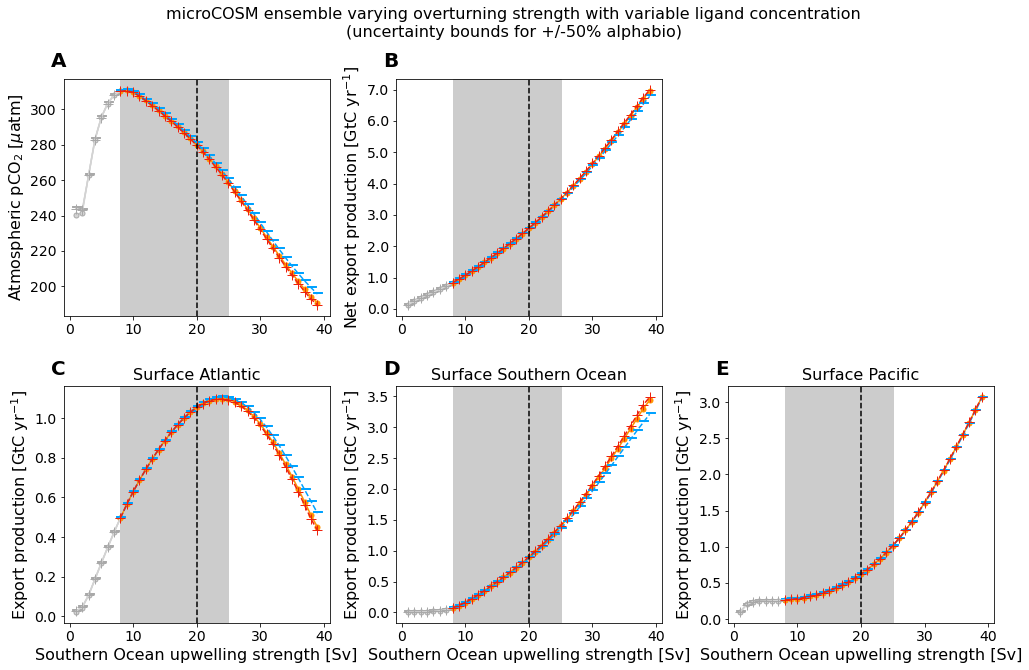

In [32]:
f7b = plot_export_pco2(perturbation_markers,
                          basin_names,
                          ensemble_variablelig_output['cntrl'],
                          lower_bound=ensemble_variablelig_output["deca"],
                          upper_bound=ensemble_variablelig_output["inca"],
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text = "microCOSM ensemble varying overturning strength with variable ligand concentration\n(uncertainty bounds for +/-50% alphabio)",
                         )
f7b.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_abio_uncertainty_exportpco2.pdf".format(fnadd,psi_max),
        facecolor   = f7b.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

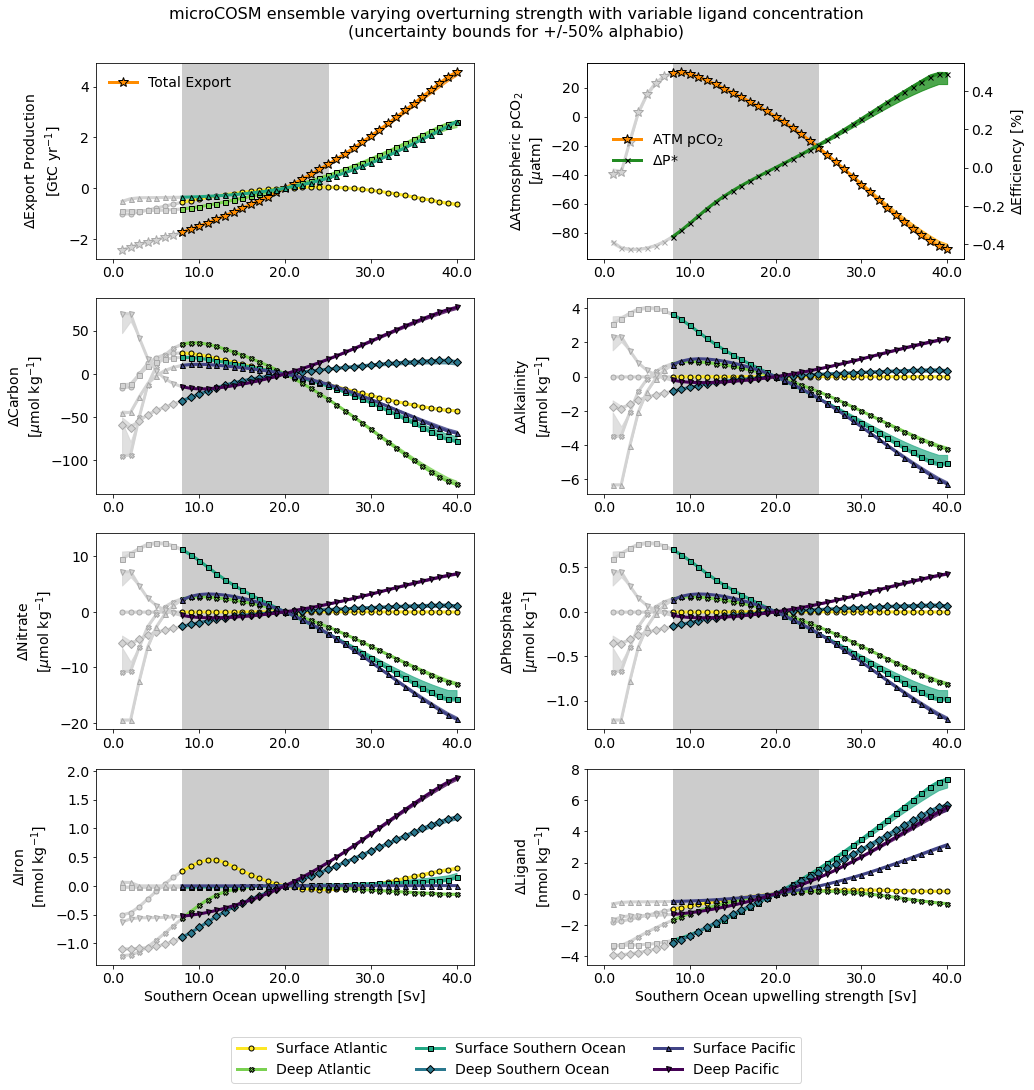

In [33]:
f7c = plot_concentration_anomalies(basin_markers, basin_names,
                         ensemble_variablelig_input['cntrl'],
                         ensemble_variablelig_output['cntrl'],
                         ensemble_variablelig_anomaly['cntrl'],
                         lower_bound=ensemble_variablelig_anomaly["deca"],
                         upper_bound=ensemble_variablelig_anomaly["inca"],
                         x_fig = x_fig,
                         y_fig = y_fig,
                         niso  = niso, nmax = nmax,
                         suptitle_text = "microCOSM ensemble varying overturning strength with variable ligand concentration\n(uncertainty bounds for +/-50% alphabio)",
)

# save the graph
f7c.savefig(
    "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_abio_uncertainty_anomalies.pdf".format(fnadd,psi_max),
    facecolor   = f7c.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)
plt.close()

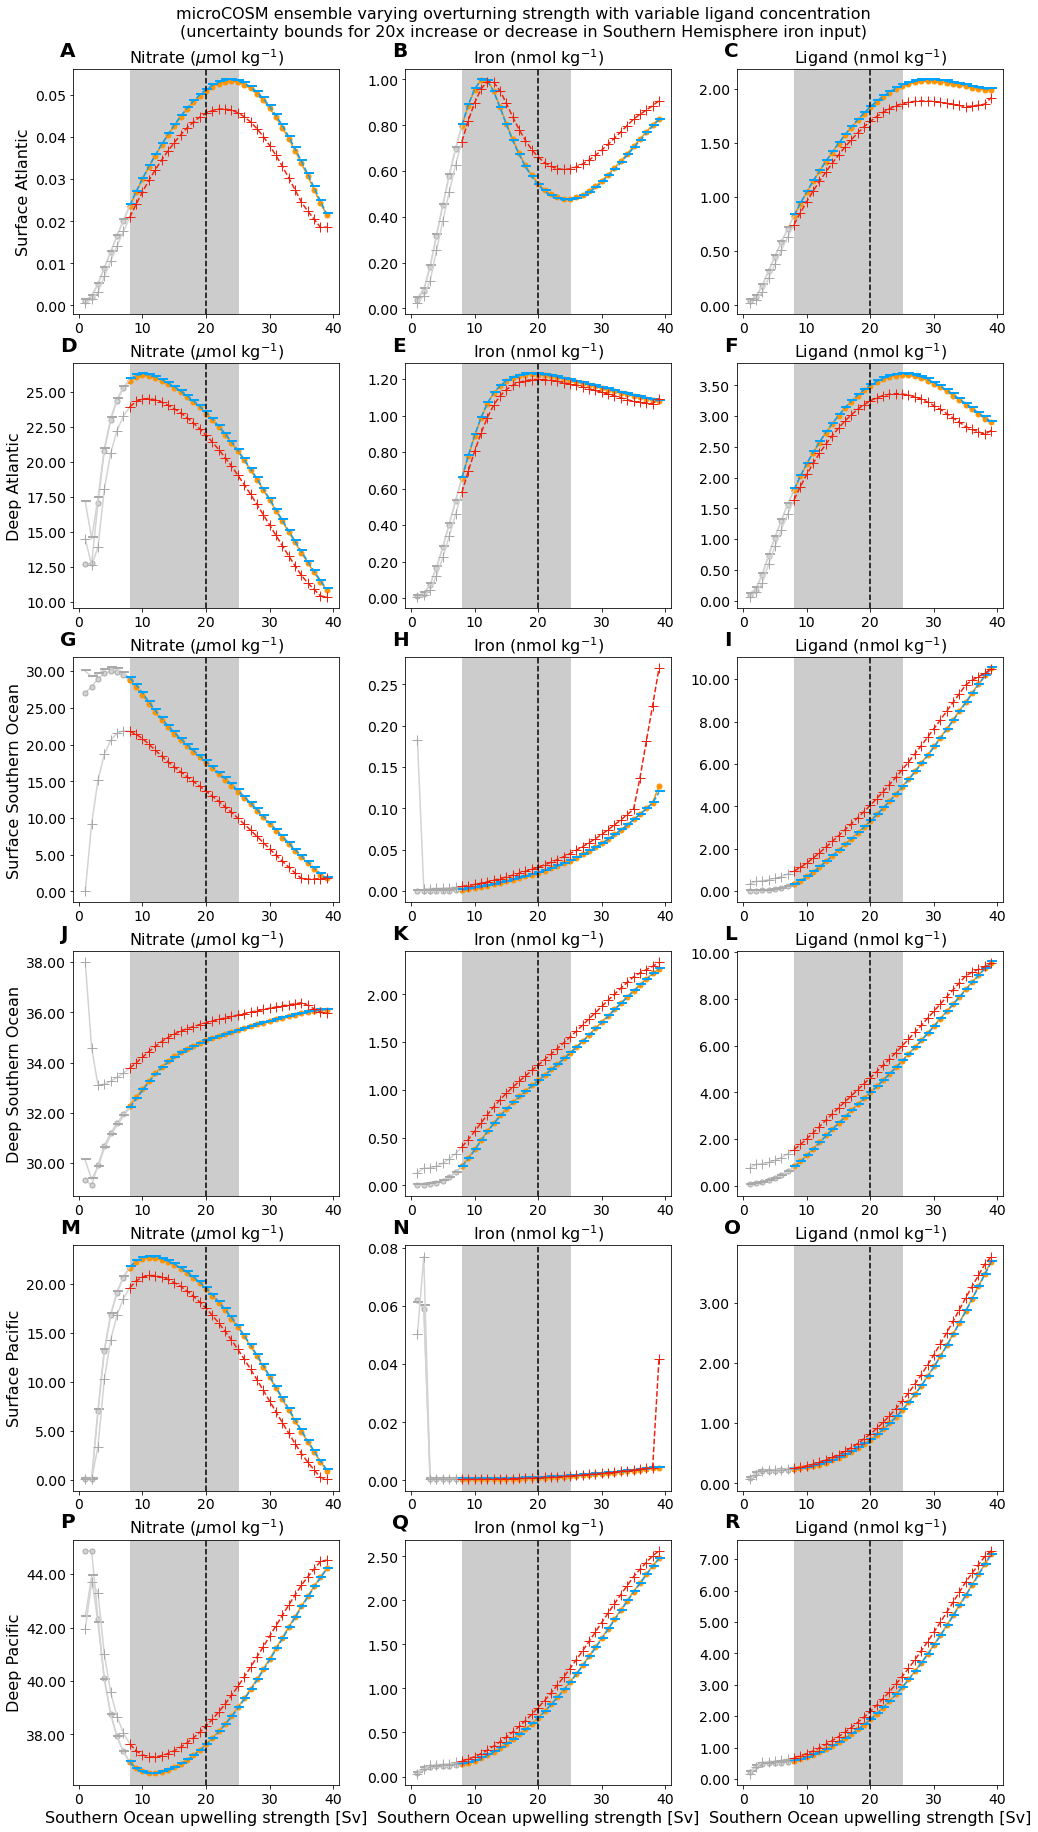

In [34]:
f8a = plot_concentrations(perturbation_markers,
                          basin_names,
                          ensemble_variablelig_output['cntrl'],
                          lower_bound=ensemble_variablelig_output["decd"],
                          upper_bound=ensemble_variablelig_output["incd"],
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text = "microCOSM ensemble varying overturning strength with variable ligand concentration\n(uncertainty bounds for 20x increase or decrease in Southern Hemisphere iron input)",
                         )
f8a.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_dust_uncertainty_concentrations.pdf".format(fnadd,psi_max),
        facecolor   = f8a.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

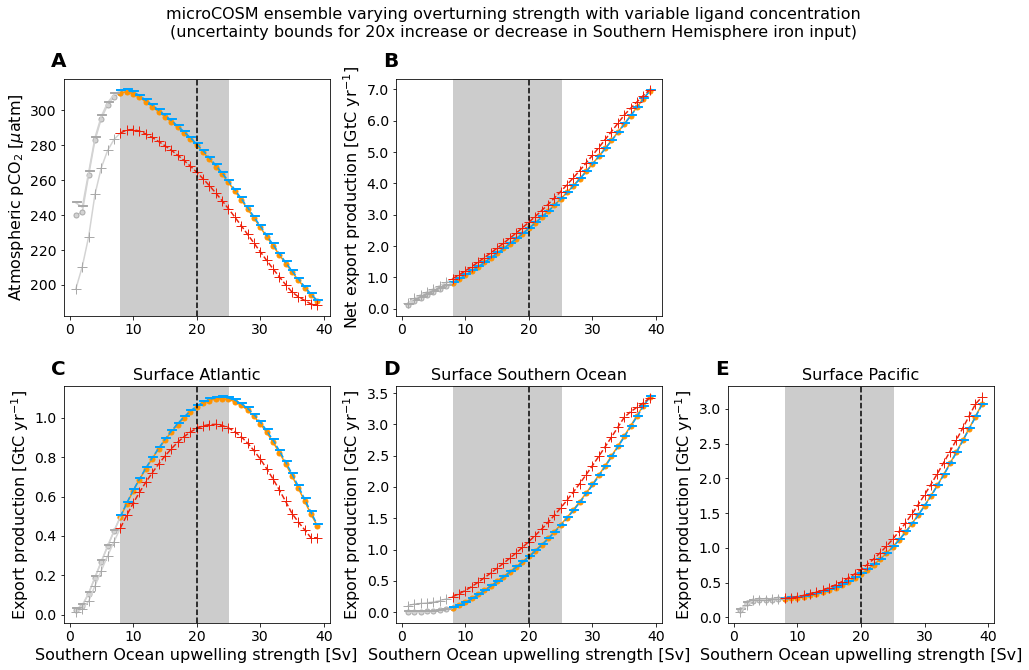

In [35]:
f8b = plot_export_pco2(perturbation_markers,
                          basin_names,
                          ensemble_variablelig_output['cntrl'],
                          lower_bound=ensemble_variablelig_output["decd"],
                          upper_bound=ensemble_variablelig_output["incd"],
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text = "microCOSM ensemble varying overturning strength with variable ligand concentration\n(uncertainty bounds for 20x increase or decrease in Southern Hemisphere iron input)",
                         )
f8b.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_dust_uncertainty_exportpco2.pdf".format(fnadd,psi_max),
        facecolor   = f8b.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

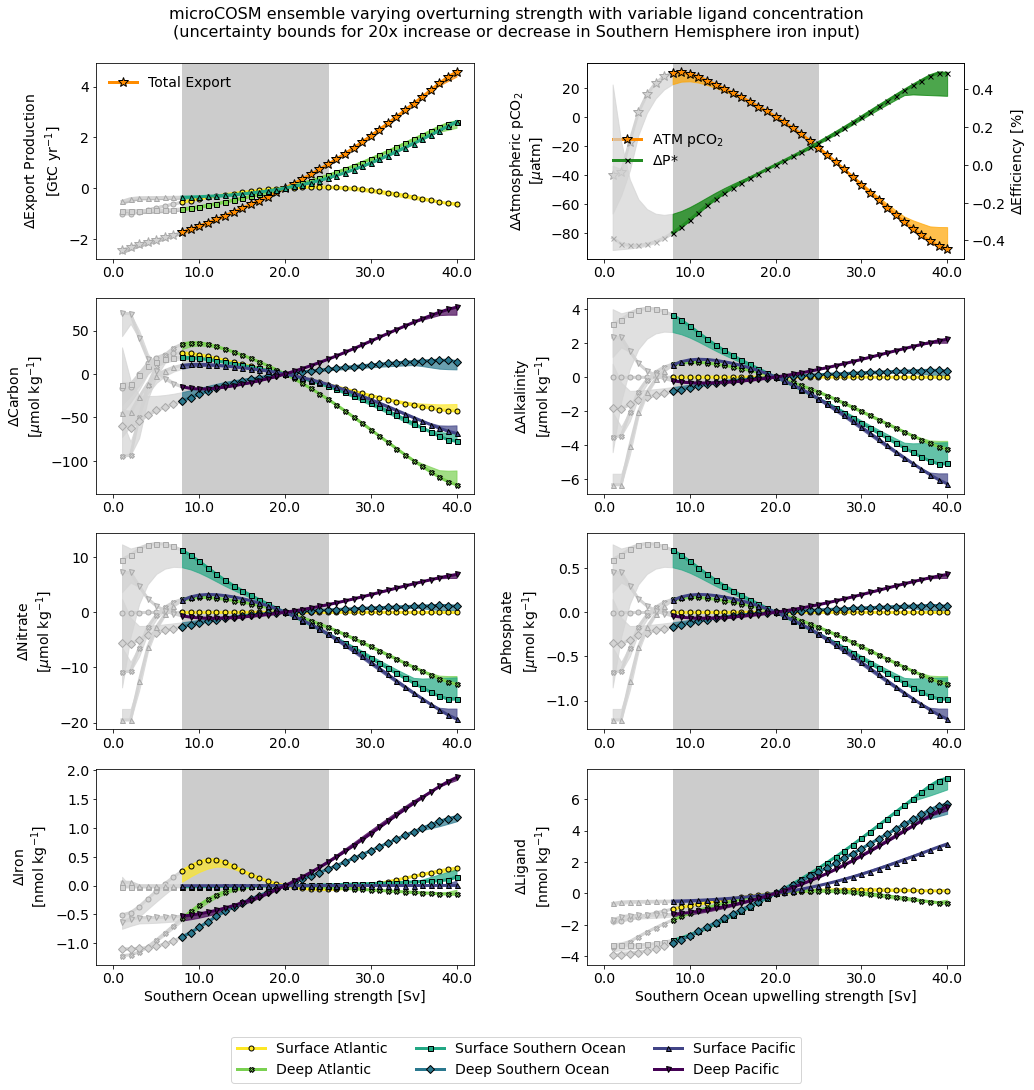

In [36]:
f8c = plot_concentration_anomalies(basin_markers, basin_names,
                         ensemble_variablelig_input['cntrl'],
                         ensemble_variablelig_output['cntrl'],
                         ensemble_variablelig_anomaly['cntrl'],
                         lower_bound=ensemble_variablelig_anomaly["decd"],
                         upper_bound=ensemble_variablelig_anomaly["incd"],
                         x_fig = x_fig,
                         y_fig = y_fig,
                         niso  = niso, nmax = nmax,
                         suptitle_text = "microCOSM ensemble varying overturning strength with variable ligand concentration\n(uncertainty bounds for 20x increase or decrease in Southern Hemisphere iron input)",
)

# save the graph
f8c.savefig(
    "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_dust_uncertainty_anomalies.pdf".format(fnadd,psi_max),
    facecolor   = f8c.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)
plt.close()

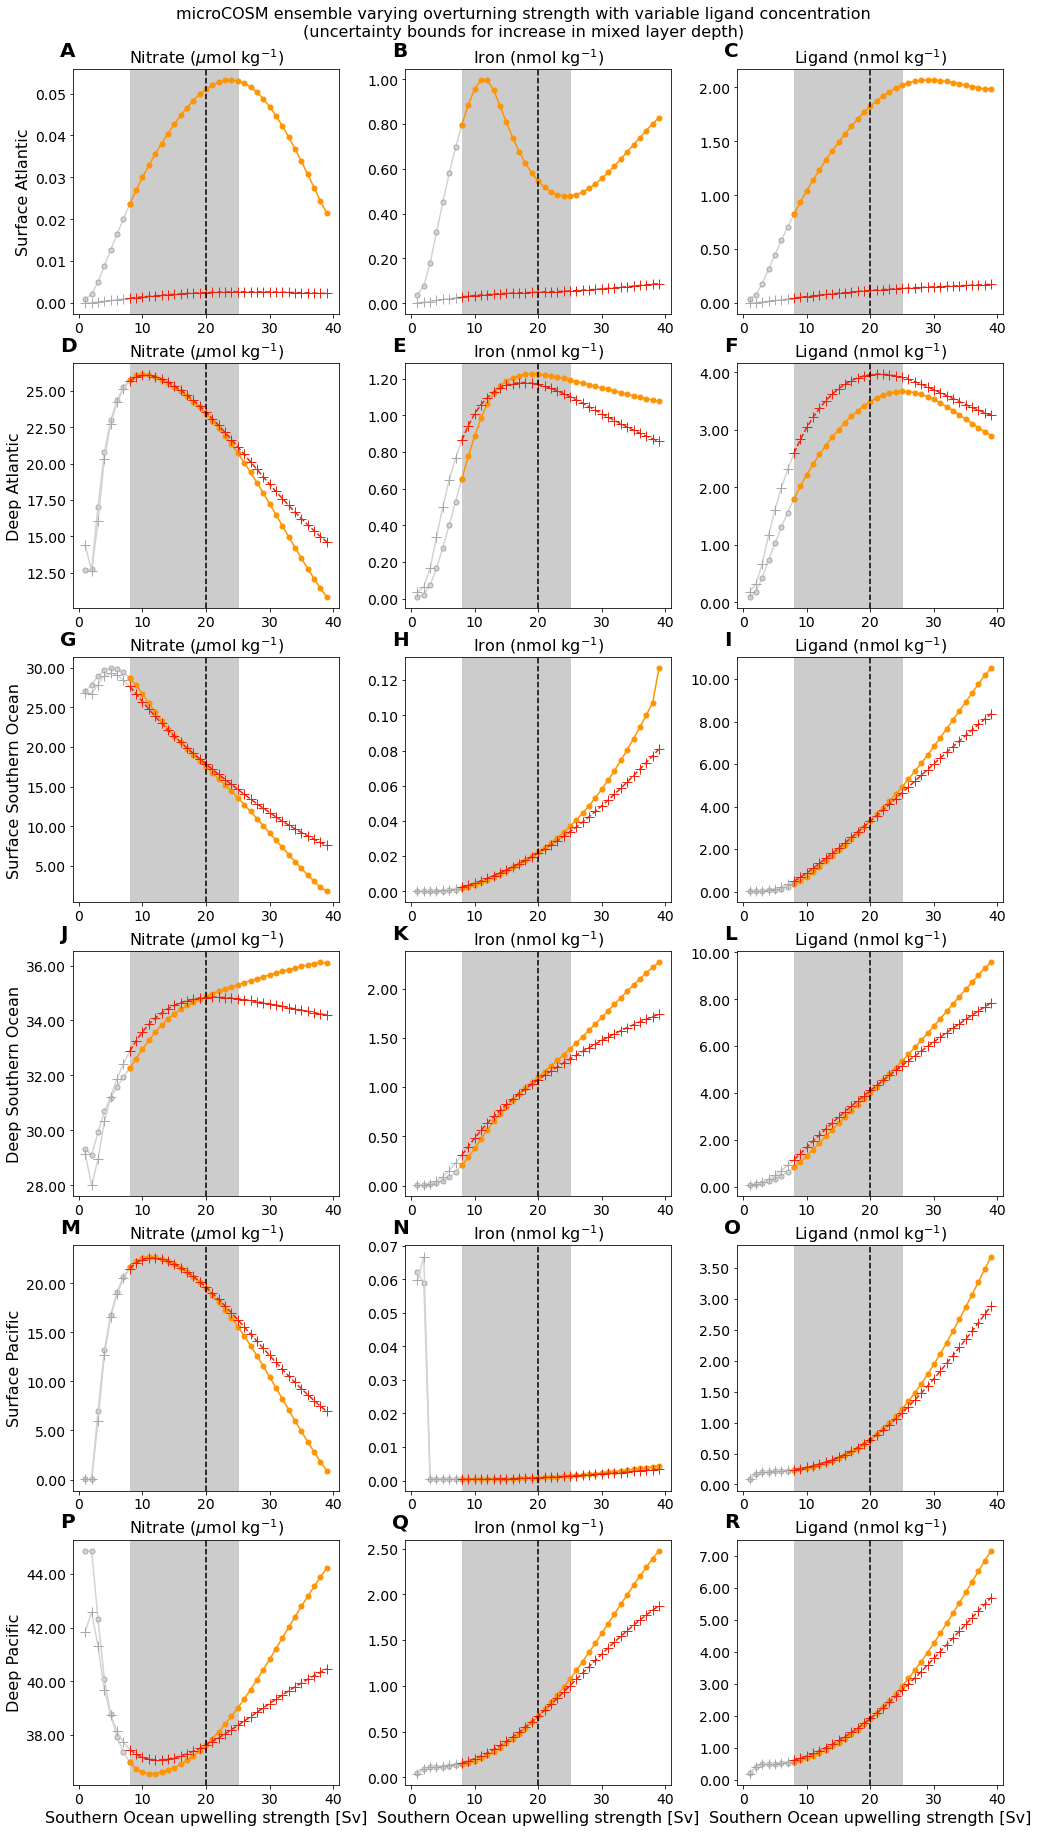

In [37]:
f9a = plot_concentrations(perturbation_markers,
                          basin_names,
                          ensemble_variablelig_output['cntrl'],
                          lower_bound=None,
                          upper_bound=ensemble_variablelig_output["incmld"],
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                         suptitle_text = "microCOSM ensemble varying overturning strength with variable ligand concentration\n(uncertainty bounds for increase in mixed layer depth)",
                         )
f9a.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_mld2k_uncertainty_concentrations.pdf".format(fnadd,psi_max),
        facecolor   = f9a.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

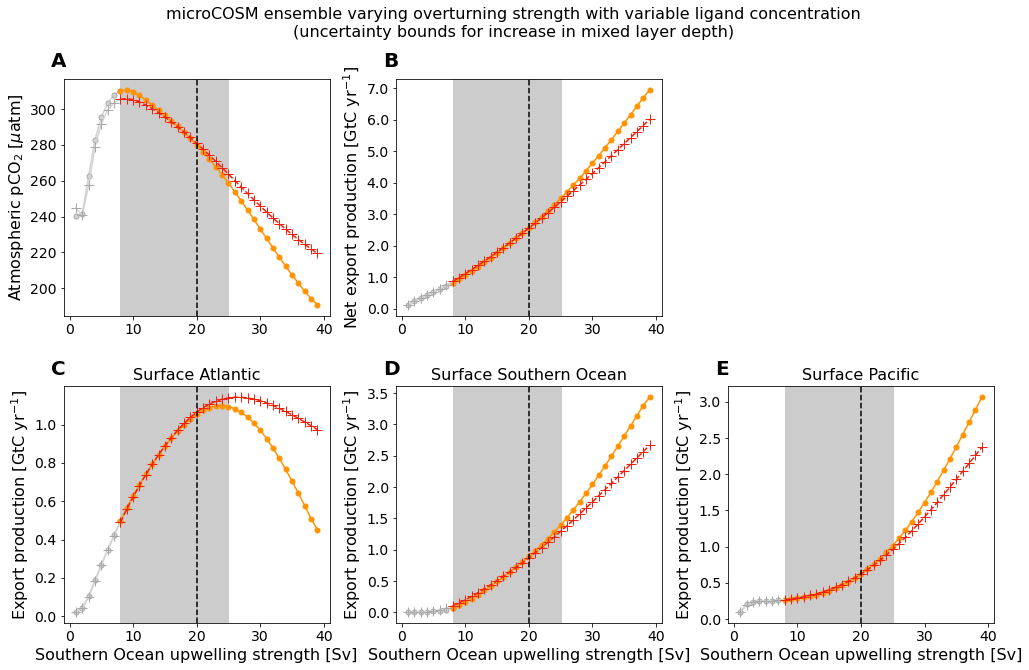

In [38]:
f9b = plot_export_pco2(perturbation_markers,
                          basin_names,
                          ensemble_variablelig_output['cntrl'],
                          lower_bound=None,
                          upper_bound=ensemble_variablelig_output["incmld"],
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                         suptitle_text = "microCOSM ensemble varying overturning strength with variable ligand concentration\n(uncertainty bounds for increase in mixed layer depth)",
                         )
f9b.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_mld2k_uncertainty_exportpco2.pdf".format(fnadd,psi_max),
        facecolor   = f9b.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

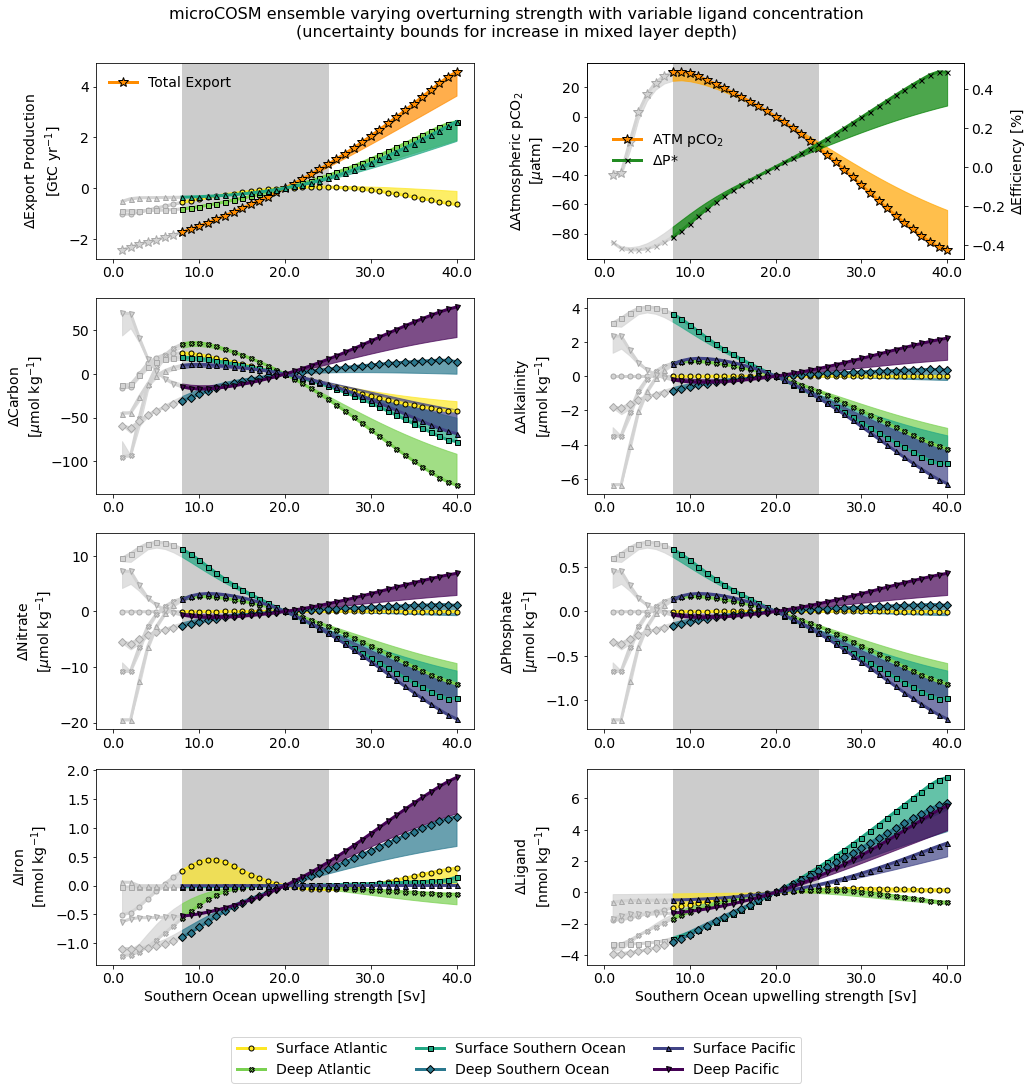

In [39]:
f9c = plot_concentration_anomalies(basin_markers, basin_names,
                         ensemble_variablelig_input['cntrl'],
                         ensemble_variablelig_output['cntrl'],
                         ensemble_variablelig_anomaly['cntrl'],
                         lower_bound=ensemble_variablelig_anomaly["cntrl"],
                         upper_bound=ensemble_variablelig_anomaly["incmld"],
                         x_fig = x_fig,
                         y_fig = y_fig,
                         niso  = niso, nmax = nmax+1,
                         suptitle_text = "microCOSM ensemble varying overturning strength with variable ligand concentration\n(uncertainty bounds for increase in mixed layer depth)",
)

# save the graph
f9c.savefig(
    "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_mld2k_uncertainty_anomalies.pdf".format(fnadd,psi_max),
    facecolor   = f9c.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)
plt.close()

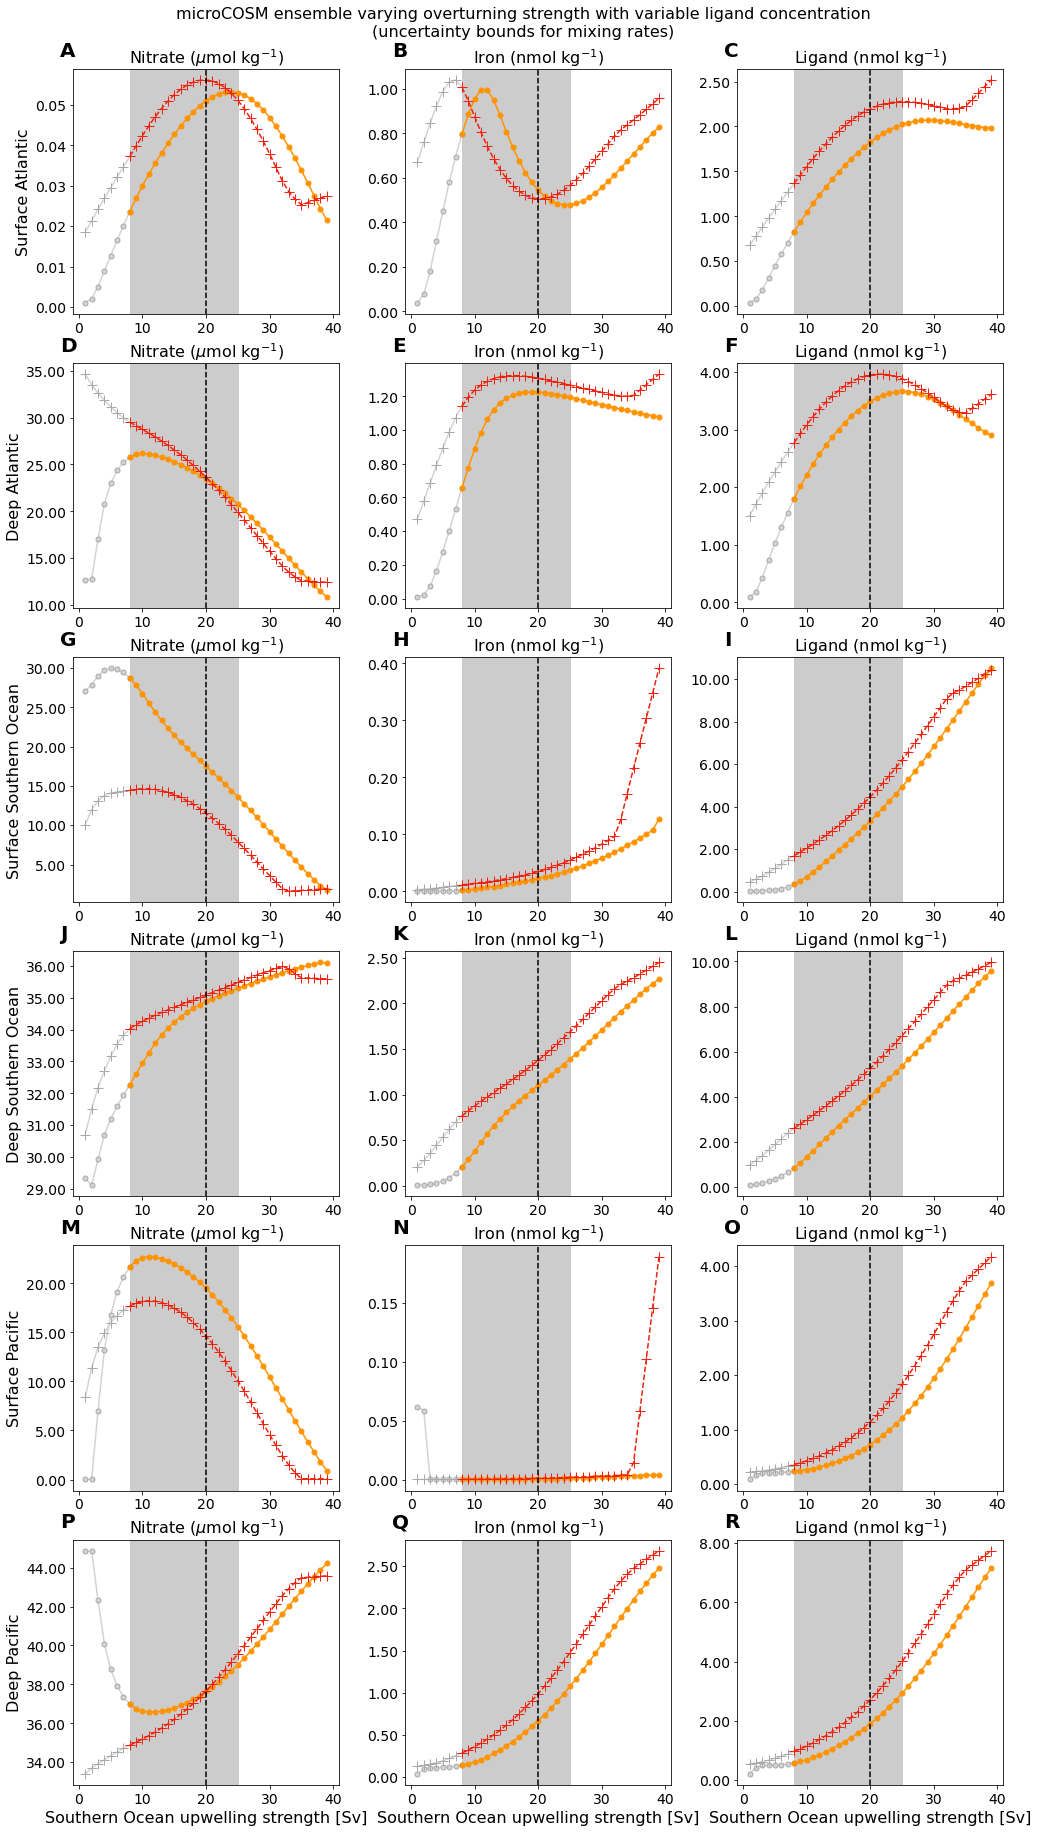

In [40]:
f10a = plot_concentrations(perturbation_markers,
                          basin_names,
                          ensemble_variablelig_output['cntrl'],
                          lower_bound=None,
                          upper_bound=ensemble_variablelig_output["incmix"],
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text = "microCOSM ensemble varying overturning strength with variable ligand concentration\n(uncertainty bounds for mixing rates)",
                         )
f10a.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_mixing_uncertainty_concentrations.pdf".format(fnadd,psi_max),
        facecolor   = f10a.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

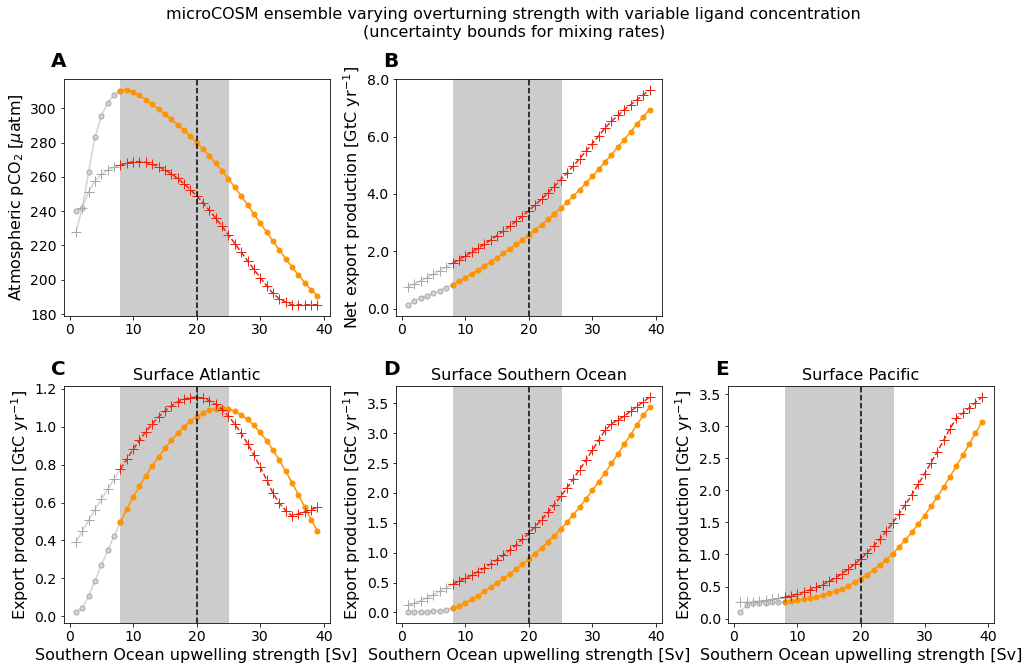

In [41]:
f10b = plot_export_pco2(perturbation_markers,
                          basin_names,
                          ensemble_variablelig_output['cntrl'],
                          lower_bound=None,
                          upper_bound=ensemble_variablelig_output["incmix"],
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text = "microCOSM ensemble varying overturning strength with variable ligand concentration\n(uncertainty bounds for mixing rates)",
                         )
f10b.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_mixing_uncertainty_exportpco2.pdf".format(fnadd,psi_max),
        facecolor   = f10b.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

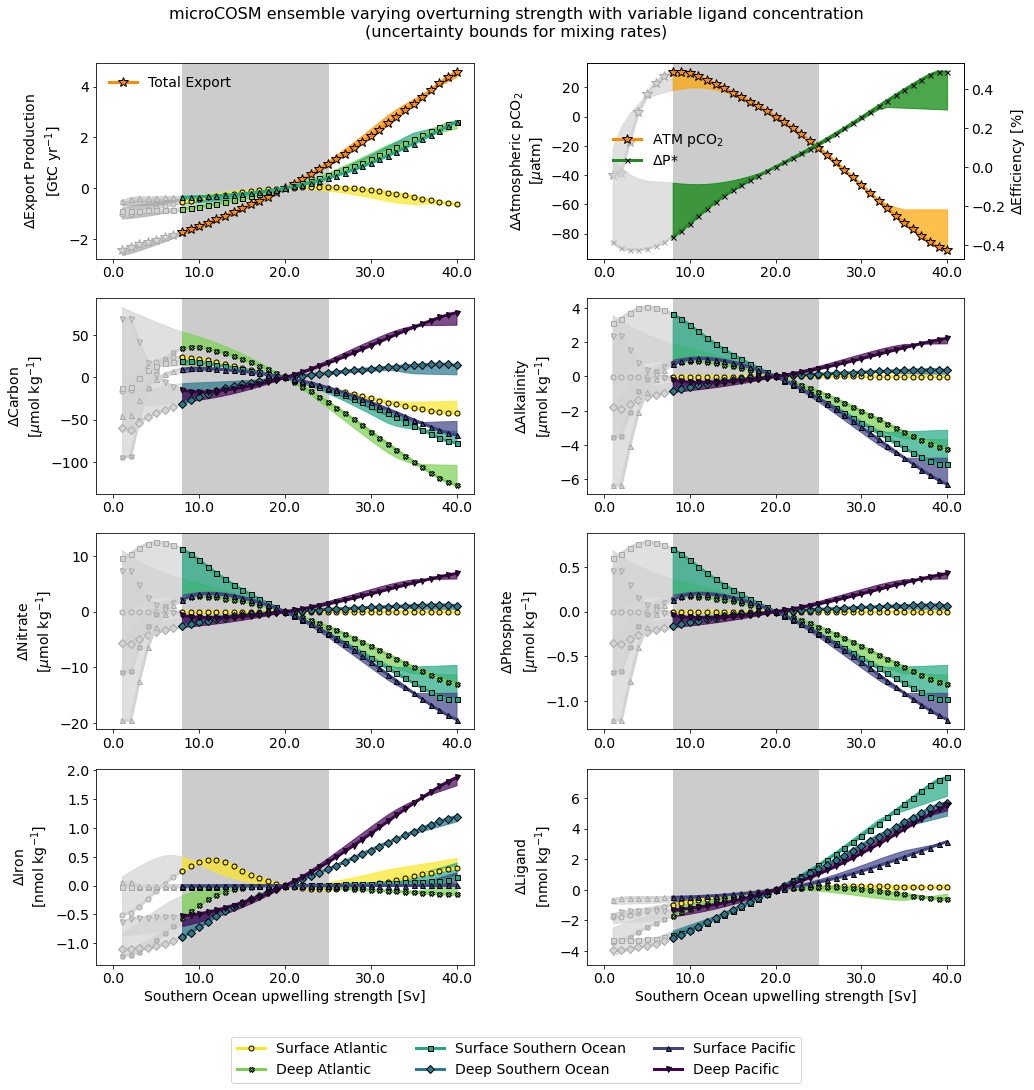

In [42]:
f10c = plot_concentration_anomalies(basin_markers, basin_names,
                         ensemble_variablelig_input['cntrl'],
                         ensemble_variablelig_output['cntrl'],
                         ensemble_variablelig_anomaly['cntrl'],
                         lower_bound=ensemble_variablelig_anomaly["cntrl"],
                         upper_bound=ensemble_variablelig_anomaly["incmix"],
                         x_fig = x_fig,
                         y_fig = y_fig,
                         niso  = niso, nmax = nmax,
                         suptitle_text = "microCOSM ensemble varying overturning strength with variable ligand concentration\n(uncertainty bounds for mixing rates)",
)

# save the graph
f10c.savefig(
    "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_mixing_uncertainty_anomalies.pdf".format(fnadd,psi_max),
    facecolor   = f10c.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)
plt.close()

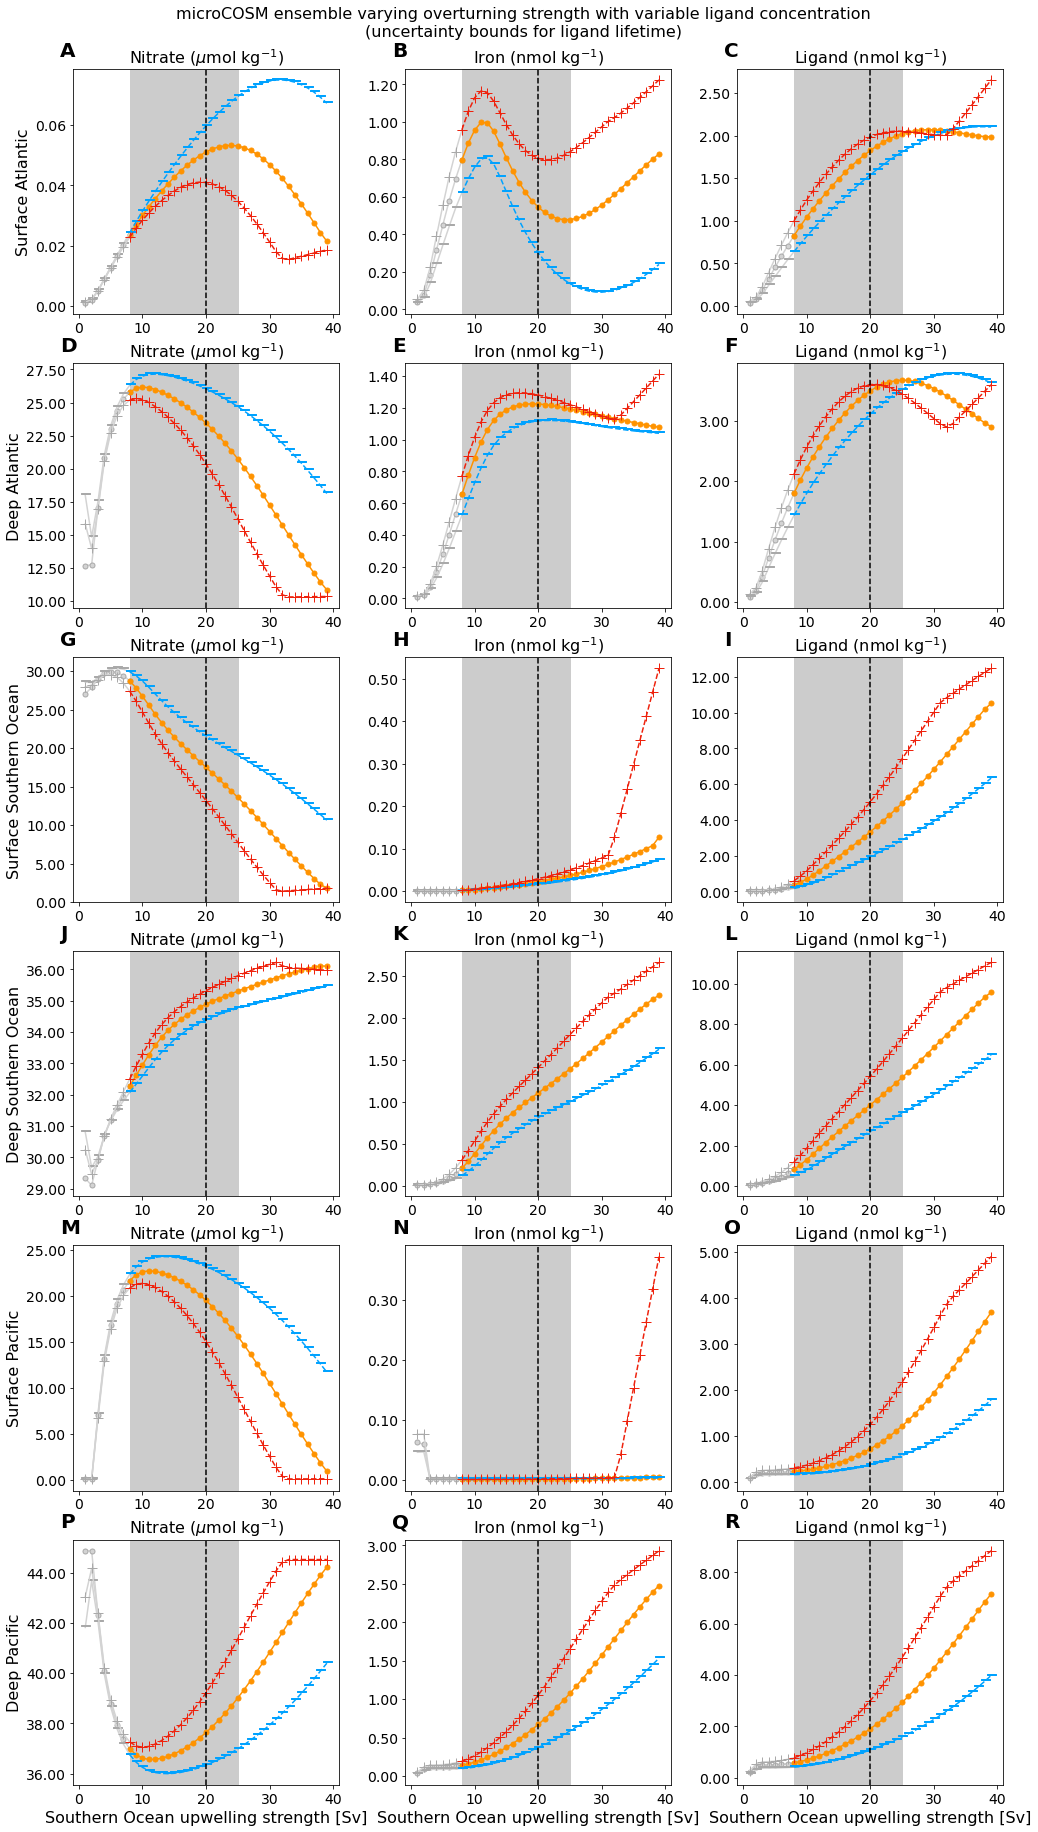

In [43]:
f11a = plot_concentrations(perturbation_markers,
                          basin_names,
                          ensemble_variablelig_output['cntrl'],
                          lower_bound=ensemble_variablelig_output["decgol"],
                          upper_bound=ensemble_variablelig_output["incgol"],
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text = "microCOSM ensemble varying overturning strength with variable ligand concentration\n(uncertainty bounds for ligand lifetime)",
                         )
f11a.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_ligparm_uncertainty_concentrations.pdf".format(fnadd,psi_max),
        facecolor   = f11a.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

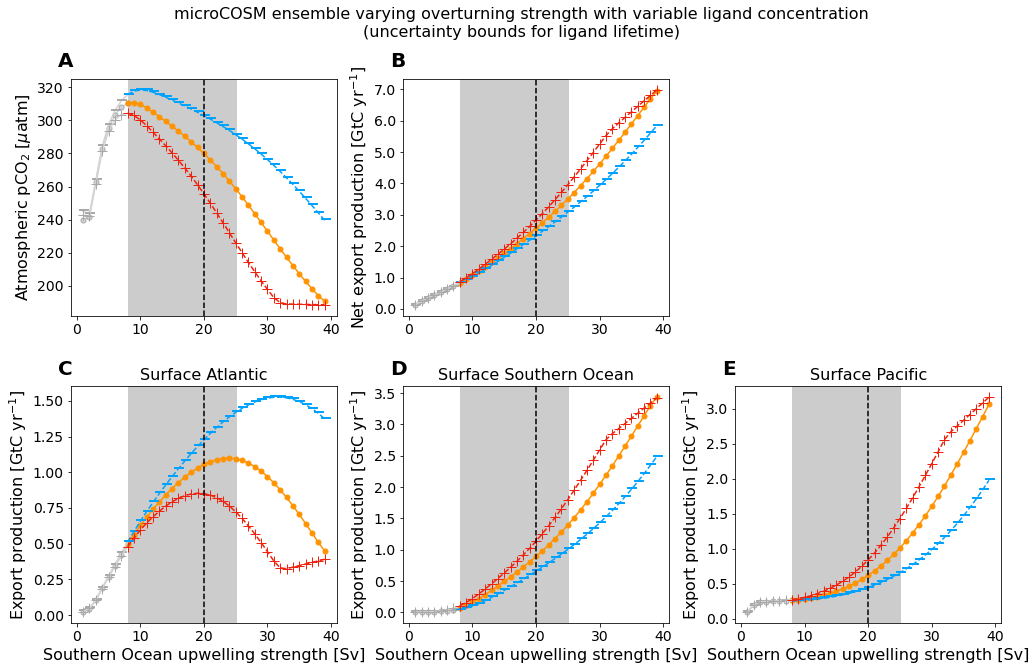

In [44]:
f11b = plot_export_pco2(perturbation_markers,
                          basin_names,
                          ensemble_variablelig_output['cntrl'],
                          lower_bound=ensemble_variablelig_output["decgol"],
                          upper_bound=ensemble_variablelig_output["incgol"],
                          niso=niso, nctrl=20,
                          x_fig=x_fig,y_fig=y_fig,
                          suptitle_text = "microCOSM ensemble varying overturning strength with variable ligand concentration\n(uncertainty bounds for ligand lifetime)",
                         )
f11b.savefig(
        "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_ligparm_uncertainty_exportpco2.pdf".format(fnadd,psi_max),
        facecolor   = f11b.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

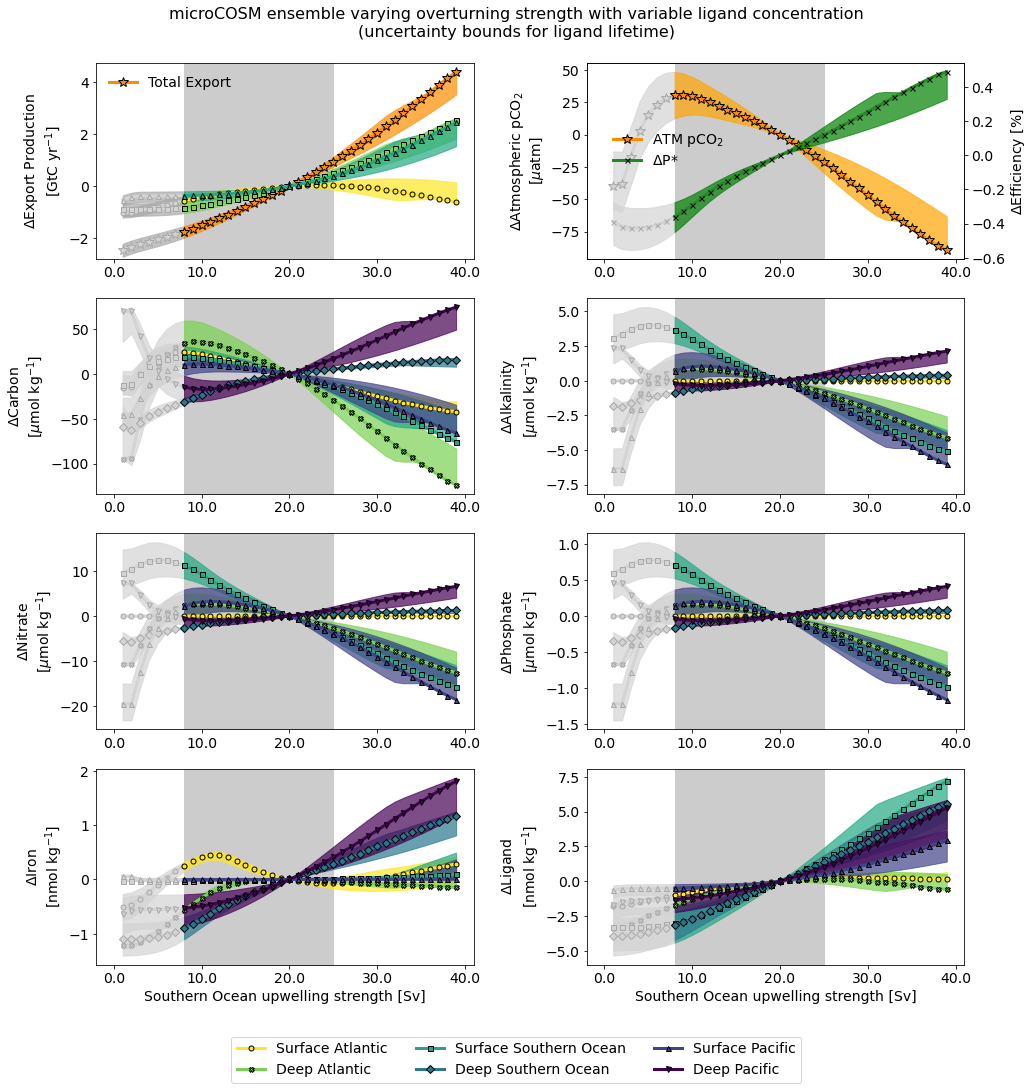

In [45]:
f11c = plot_concentration_anomalies(basin_markers, basin_names,
                         ensemble_variablelig_input['cntrl'],
                         ensemble_variablelig_output['cntrl'],
                         ensemble_variablelig_anomaly['cntrl'],
                         lower_bound=ensemble_variablelig_anomaly["decgol"],
                         upper_bound=ensemble_variablelig_anomaly["incgol"],
                         x_fig = x_fig,
                         y_fig = y_fig,
                         niso  = niso, 
                         suptitle_text = "microCOSM ensemble varying overturning strength with variable ligand concentration\n(uncertainty bounds for ligand lifetime)",
)

# save the graph
f11c.savefig(
    "microCOSM_{0}_ensemble_psi_{1:.0f}Sv_ligparm_uncertainty_anomalies.pdf".format(fnadd,psi_max),
    facecolor   = f11c.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)
plt.close()

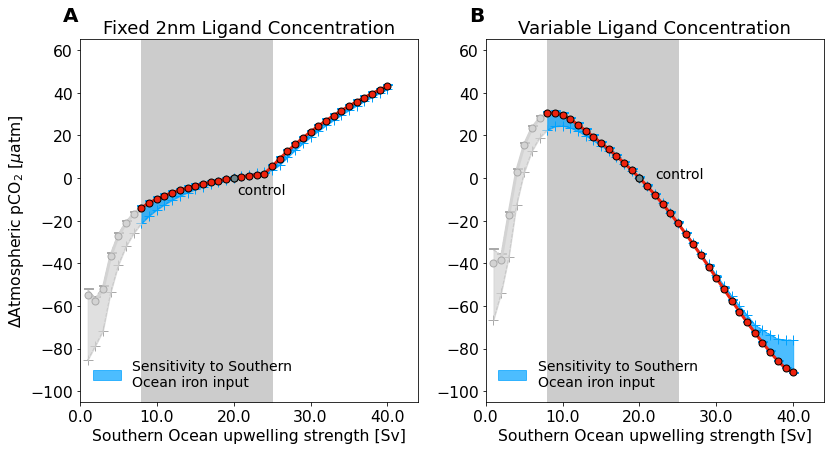

In [46]:
plt.rcParams['xtick.labelsize'] ='large'
plt.rcParams['ytick.labelsize'] ='large'
plt.rcParams['axes.labelsize' ] ='large'
plt.rcParams['legend.fontsize'] ='14'
plt.rcParams['figure.titlesize']='large'
plt.rcParams['font.size']       ='13'

colors=['#305cd0','#00a2ff','#6d868a','#fae430','#ff9300','#ee220d']
cmap = mp.colors.LinearSegmentedColormap.from_list('Zissou',[mp.colors.hex2color(x) for x in colors], N=6)

model_output  = [ensemble_fixedlig_output['cntrl'],  ensemble_variablelig_output['cntrl'] ]
model_anomaly = [ensemble_fixedlig_anomaly['cntrl'], ensemble_variablelig_anomaly['cntrl']]
model_bounds  = [ensemble_fixedlig_anomaly, ensemble_variablelig_anomaly]

[ s_pco2mocflig, 
  i_pco2mocflig, 
  r_pco2mocflig, 
  p_pco2mocflig, 
  se_pco2mocflig ] = st.linregress(
    ensemble_fixedlig_anomaly['cntrl']["psi"    ].iloc[niso:nmax] * 1e-6,
    ensemble_fixedlig_anomaly['cntrl']["atmpco2"].iloc[niso:nmax]
)

[ s_pco2mocvlig, 
  i_pco2mocvlig, 
  r_pco2mocvlig, 
  p_pco2mocvlig, 
  se_pco2mocvlig ] = st.linregress(
    ensemble_variablelig_anomaly['cntrl']["psi"    ].iloc[niso:nmax] * 1e-6,
    ensemble_variablelig_anomaly['cntrl']["atmpco2"].iloc[niso:nmax]
)


f12, f12ax = plt.subplots(figsize=(3*x_fig, 1.5*y_fig), ncols=2, nrows=1)
f12.patch.set_facecolor("None")
f12cb = f12ax.copy()
f12sh = f12ax.copy()

plotargs = {
        'linewidth'       : 3,
        'markersize'      : 7,
        'marker'          : "o",
        'markeredgecolor' : "k",
}

for mm in np.arange(len(model_output)):
    if niso > 0:
        f12ax[mm].plot(
            model_output [mm]["psi"    ].iloc[1:niso+1] * 1e-6,
            model_anomaly[mm]["atmpco2"].iloc[1:niso+1],
            linewidth       = plotargs['linewidth'],
            marker          = plotargs['marker'],
            markersize      = plotargs['markersize'],
            markeredgecolor = "darkgrey",
            color           = "lightgrey",
        )
    f12ax[mm].plot(
        model_output [mm]["psi"    ].iloc[niso:nmax] * 1e-6,
        model_anomaly[mm]["atmpco2"].iloc[niso:nmax],
        color           = cmap(6),
        label           = "ATM pCO$_2$",
        **plotargs,
    )  
    f12ax[mm].plot(
        model_output [mm]["psi"    ].loc[model_output[mm]["psi"] == cntrl_psi] * 1e-6,
        model_anomaly[mm]["atmpco2"].loc[model_output[mm]["psi"] == cntrl_psi],
        color           = cmap(2),
        **plotargs,
    )
    
    if mm == 0:
        ylim       = (-105, 65)    
        title_text = "Fixed 2nm Ligand Concentration"
        cntrl_x    =  20.5
        cntrl_y    = -7.5
    else:
        ylim       = (-105, 65)
        title_text = "Variable Ligand Concentration"
        cntrl_x    = 22.0
        cntrl_y    = 0.0
        
    f12ax[mm].text(
        cntrl_x, 
        cntrl_y,
        "control",
        fontsize            = 14,
        horizontalalignment = "left",
        )
    
    ## Plot data-based glacial AMOC constraint
    #f12ax[mm].annotate(
    #    text='', 
    #    xy=(8/0.65,np.min(ylim)), 
    #    xytext=(25/0.65,np.min(ylim)), 
    #    arrowprops=dict(
    #        color='black',
    #        arrowstyle='<|-|>,head_width=0.5,head_length=0.5', 
    #        shrinkA=0, 
    #        shrinkB=0, 
    #        linewidth=2
    #    )
    #)
    # Co limitation zone
    f12ax[mm].fill_between(
        (8,25),         # Where are these numbers from
        np.min(ylim),
        np.max(ylim),
        color='#cccccc',
        zorder=-1,
    )

    f12ax[mm].set(xlim=(-0, 44), ylim=ylim)
    f12ax[mm].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    f12ax[mm].set_xlabel("Southern Ocean upwelling strength [Sv]")
    f12ax[mm].set_title(title_text, fontsize=18)
    if mm==0:
        f12ax[mm].set_ylabel("$\Delta$Atmospheric pCO$_2$ [$\mu$atm]")

## Could compare to Lauderdale et al 2017 MOC vs pCO2
#lauderdale_2017 = pd.read_csv(
#             "/Users/jml1/Downloads/wpd_datasets.csv",header=1,
#             names=["HMM11_up","HMM11_pco2","VMHS97_up","VMHS97_pco2","FMH05_up","FMH05_pco2"]
#             )
#for gcm in ["HMM11","VMHS97","FMH05"]:
#    f12ax[0].scatter(
#        (lauderdale_2017[gcm+"_up"]),
#        (lauderdale_2017[gcm+"_pco2"] - lauderdale_2017[gcm+"_pco2"].loc[0]),
#        50,
#        color           = 'gray'
#    )

    # Draw on the sensitivity envelopes for dust
    if niso > 0:
        f12sh[mm] = f12ax[mm].fill_between(
            model_output[mm]["psi"].iloc[1:niso+1] * 1e-6,
            np.min([model_bounds [mm]['decd']["atmpco2"].iloc[1:niso+1],
                    model_bounds [mm]['incd']["atmpco2"].iloc[1:niso+1],
                    model_anomaly[mm]["atmpco2"].iloc[1:niso+1]],axis=0),
            np.max([model_bounds [mm]['decd']["atmpco2"].iloc[1:niso+1],
                    model_bounds [mm]['incd']["atmpco2"].iloc[1:niso+1],
                    model_anomaly[mm]["atmpco2"].iloc[1:niso+1]],axis=0),
            alpha = 0.7,
            color = "lightgrey",
        )
        f12ax[mm].plot(
            model_output[mm]["psi"].iloc[1:niso+1] * 1e-6,
            model_bounds[mm]['decd']["atmpco2"].iloc[1:niso+1],
            color           = 'darkgray',
            linestyle       = '--', 
            marker          = '$-$',
            zorder          = -1,
            linewidth=1,
            markersize=10,
        )
    
        f12ax[mm].plot(
            model_output[mm]["psi"].iloc[1:niso+1] * 1e-6,
            model_bounds[mm]['incd']["atmpco2"].iloc[1:niso+1],
            color           = 'darkgray',
            linestyle       = '--', 
            marker          = '+',
            zorder          = -1,
            linewidth=1,
            markersize=10,
        )
    f12sh[mm] = f12ax[mm].fill_between(
        model_output[mm]["psi"].iloc[niso:nmax] * 1e-6,
        model_bounds[mm]['decd']["atmpco2"].iloc[niso:nmax],
        model_bounds[mm]['incd']["atmpco2"].iloc[niso:nmax],
        color = cmap(1),
        alpha = 0.7,
    )
    
    f12ax[mm].plot(
        model_output[mm]["psi"].iloc[niso:nmax] * 1e-6,
        model_bounds[mm]['decd']["atmpco2"].iloc[niso:nmax],
        color           = cmap(1),
        linestyle       = '--', 
        marker          = '$-$',
        zorder          = -1,
        linewidth=1,
        markersize=10,
        )
    
    f12ax[mm].plot(
        model_output[mm]["psi"].iloc[niso:nmax] * 1e-6,
        model_bounds[mm]['incd']["atmpco2"].iloc[niso:nmax],
        color           = cmap(1),
        linestyle       = '--', 
        marker          = '+',
        zorder          = -1,
        linewidth=1,
        markersize=10,
        )
    
    f12ax[mm].legend(
        [f12sh[mm]], 
        ["Sensitivity to Southern\nOcean iron input"], 
        loc     = "lower left",
        frameon = False,
    )

label_axes(f12ax)
plt.show()
f12.savefig(
    "microCOSM_ensemble_psi_pco2_anomaly.pdf",
    facecolor   = f12.get_facecolor(),
    edgecolor   = "none",
    bbox_inches = "tight",
)

In [47]:
# Create Rectangle patches for the section plots
patches = {
    "SA" : {
        "x"  : 0.00,
        "y"  : 0.75,
        "dx" : ensemble_fixedlig_input['cntrl']["dy"].iloc[0][0] 
     / (np.sum(ensemble_fixedlig_input['cntrl']["dy"].iloc[0])/2),
        "dy" : 0.25,
    },
    "DA" : {
        "x"  : 0.0,
        "y"  : 0.0,
        "dx" : ensemble_fixedlig_input['cntrl']["dy"].iloc[0][0] 
      / (np.sum(ensemble_fixedlig_input['cntrl']["dy"].iloc[0])/2),
        "dy" : 0.75,
    },
    "SS" : {
        "x" : ensemble_fixedlig_input['cntrl']["dy"].iloc[0][0] 
    / (np.sum(ensemble_fixedlig_input['cntrl']["dy"].iloc[0])/2),
        "y"  : 0.75,
        "dx" : ensemble_fixedlig_input['cntrl']["dy"].iloc[0][2]
     / (np.sum(ensemble_fixedlig_input['cntrl']["dy"].iloc[0])/2),
        "dy" : 0.25,
    },
    "DS" : {
        "x"  : ensemble_fixedlig_input['cntrl']["dy"].iloc[0][0] 
     / (np.sum(ensemble_fixedlig_input['cntrl']["dy"].iloc[0])/2),
        "y"  : 0.0,
        "dx" : ensemble_fixedlig_input['cntrl']["dy"].iloc[0][3] 
     / (np.sum(ensemble_fixedlig_input['cntrl']["dy"].iloc[0])/2),
        "dy" : 0.75,
    },
    "SP" : {
        "x" : (ensemble_fixedlig_input['cntrl']["dy"].iloc[0][0] 
             + ensemble_fixedlig_input['cntrl']["dy"].iloc[0][2])
     / (np.sum(ensemble_fixedlig_input['cntrl']["dy"].iloc[0])/2),
        "y"  : 0.75,
        "dx" : ensemble_fixedlig_input['cntrl']["dy"].iloc[0][4]
     / (np.sum(ensemble_fixedlig_input['cntrl']["dy"].iloc[0])/2),
        "dy" : 0.25,
    },
    "DP" : {
        "x" : (ensemble_fixedlig_input['cntrl']["dy"].iloc[0][0] 
             + ensemble_fixedlig_input['cntrl']["dy"].iloc[0][2])
     / (np.sum(ensemble_fixedlig_input['cntrl']["dy"].iloc[0])/2),
        "y"  : 0.0,
        "dx" : ensemble_fixedlig_input['cntrl']["dy"].iloc[0][5]
     / (np.sum(ensemble_fixedlig_input['cntrl']["dy"].iloc[0])/2),
        "dy" : 0.75,
    },
    "AMOC" : {
        "x"     : 0.185,
        "y"     : 0.75,
        "dx"    : 0.25,
        "dy"    : 0.39,
        "angle" : 0,
#        "start" : 230,
#        "end"   : 180,
        "start" : 25,
        "end"   : 325,
    },
    "AABWA" : {
        "x"     : 0.083,
        "y"     : 0.75,
        "dx"    : 0.5,
        "dy"    : 1,
        "angle" : 0,
        "start" : 270,
        "end"   : 375-15,
    },
    "AABWP1" : {
        "x"     : 0.631,
        "y"     : 0.75,
        "dx"    : 0.5,
        "dy"    : 0.4,
        "angle" : 0,
        "start" : 0,
        "end"   : 125,
    },
    "AABWP2" : {
        "x"     : 0.631,
        "y"     : 0.75,
        "dx"    : 0.5,
        "dy"    : 1,
        "angle" : 0,
        "start" : 180,
        "end"   : 360,
    },
}

plot_vars = {
    "n" : {
        "max"    : 32,
        "min"    : 0,
        "bounds" : np.arange(0, 34, 2),
        "cmap"   : plt.cm.get_cmap("Blues").copy(),
        "title"  : "Dissolved Nitrate Concentration [$\mu$mol kg$^{-1}$]",   
        },
    "f": {
        "max"    : 3,
        "min"    : 0,
        "bounds" : np.arange(0, 4.2, 0.2),
        "cmap"   : plt.cm.get_cmap("Reds").copy(),
        "title"  : "Dissolved Iron Concentration [nmol kg$^{-1}$]",
    },
    "l": {
        "max"    : 3,
        "min"    : 0,
        "bounds" : np.arange(0, 4.2, 0.2),
        "cmap"   : mp.colors.ListedColormap( 
                        mp.cm.get_cmap("hot_r")( 
                            np.linspace( 
                                0.0, 0.2, len(np.arange(0, 4.2, 0.2))
                            ),
                        )),      
        "title"  : "Organic Ligand Concentration [nmol kg$^{-1}$]",
    },
}

boxargs = {
         "linewidth" : 1.5,
         "edgecolor" : "black",
        }

arcargs = {
         "capstyle"  : 'round',
         "linestyle" : '-',
         "linewidth" : 2,
         "color"     : "black",
        }

model_output  = [ensemble_fixedlig_output['cntrl'],  ensemble_variablelig_output['cntrl'] ]
model_anomaly = [ensemble_fixedlig_anomaly['cntrl'], ensemble_variablelig_anomaly['cntrl']]

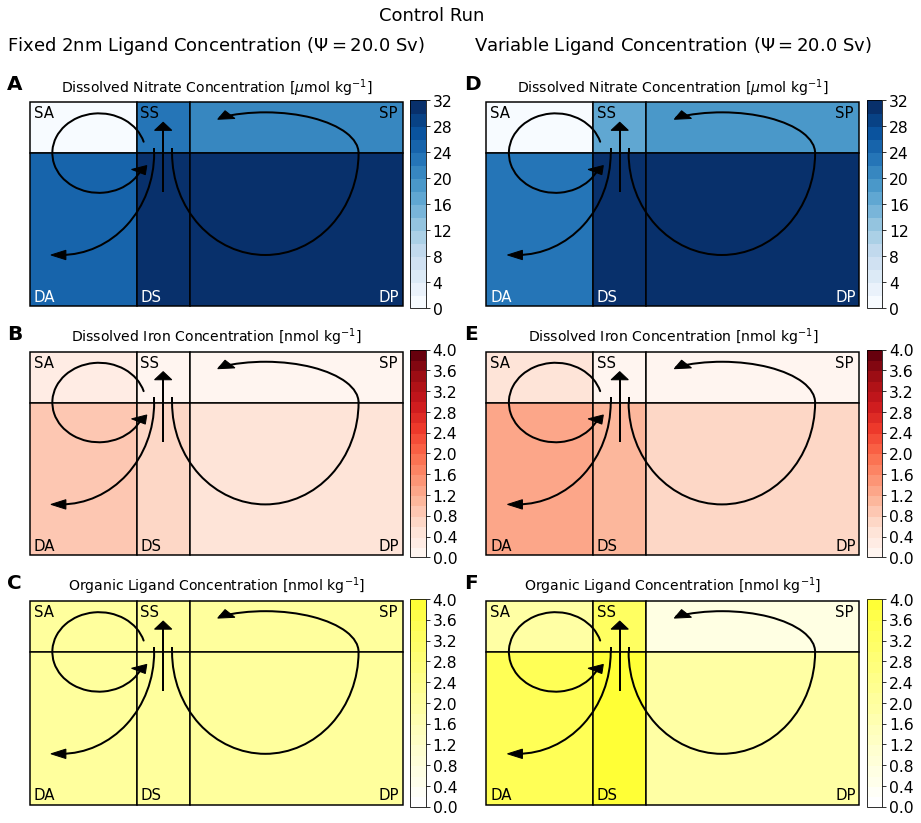

In [48]:
# Section plot for the control run
tstep = ensemble_fixedlig_output['cntrl'].index[ensemble_fixedlig_output['cntrl']["psi"] == cntrl_psi][0]
f13 = plot_box_sections(patches, 
                       tstep,
                       basin_names,
                       model_output, 
                       model_anomaly, 
                       "Control Run")

f13.savefig(
        "microCOSM_ensemble_psi_{0:.0f}Sv_anomaly_sections.pdf".format(model_output[mm]["psi"].iloc[tstep]*1e-6),
        facecolor   = f13.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

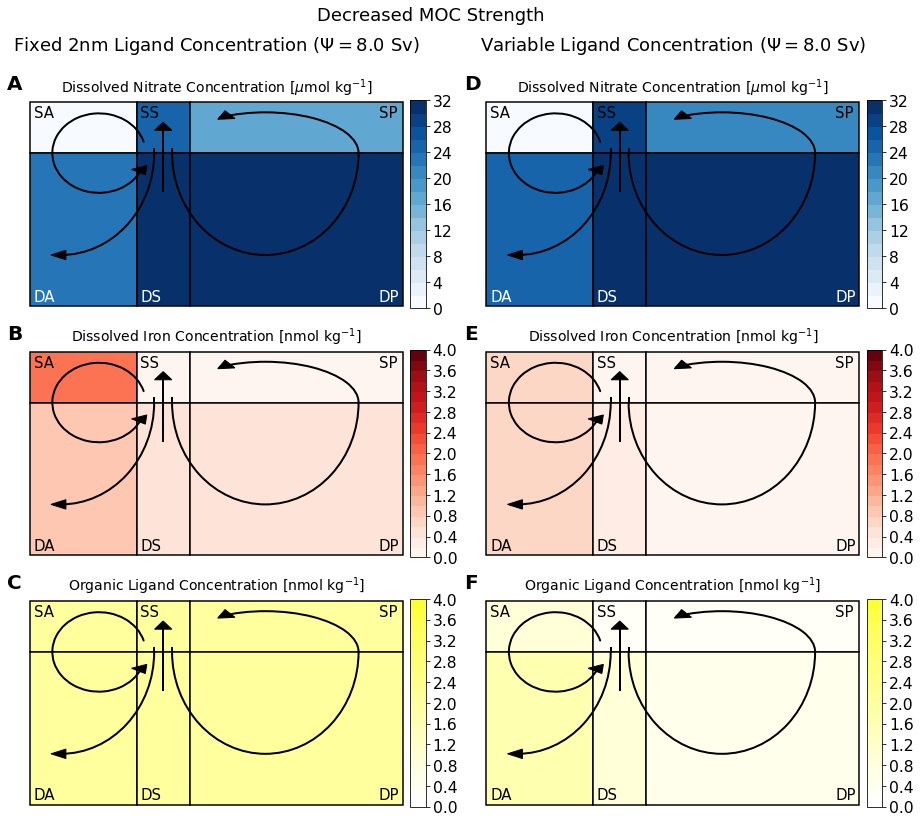

In [49]:
f14 = plot_box_sections(patches, 
                       niso, 
                       basin_names,
                       model_output, 
                       model_anomaly, 
                       "Decreased MOC Strength")

f14.savefig(
        "microCOSM_ensemble_psi_{0:.0f}Sv_anomaly_sections.pdf".format(model_output[mm]["psi"].iloc[niso]*1e-6),
        facecolor   = f14.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )

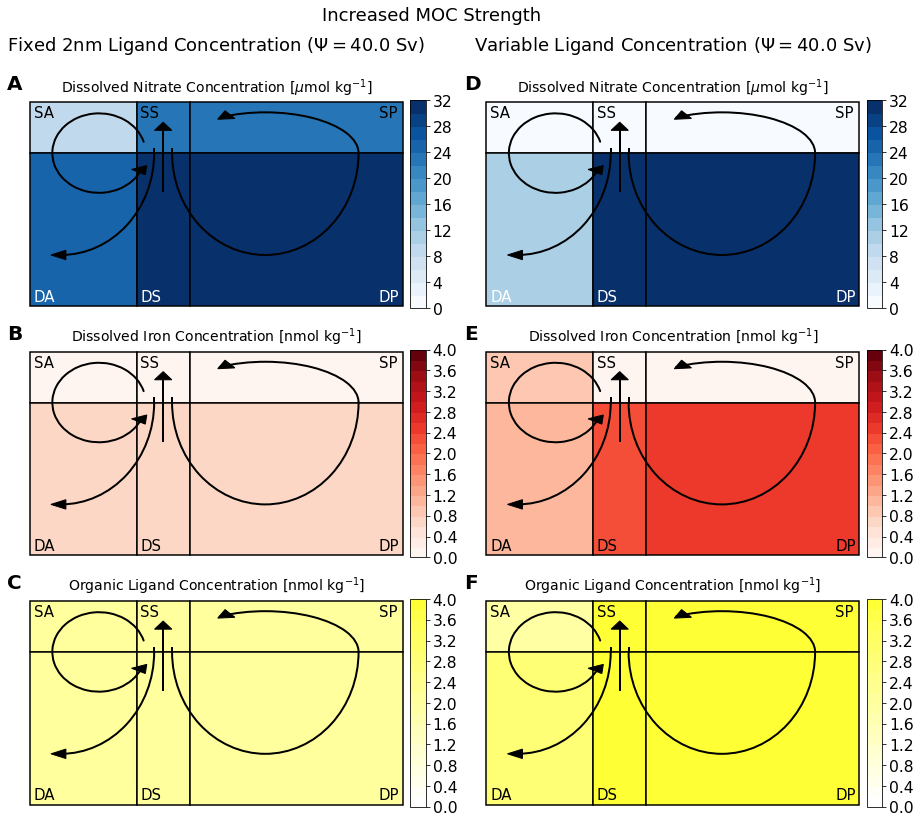

In [50]:
f15 = plot_box_sections(patches, 
                       -1, 
                       basin_names,
                       model_output, 
                       model_anomaly, 
                       "Increased MOC Strength")

f15.savefig(
        "microCOSM_ensemble_psi_{0:.0f}Sv_anomaly_sections.pdf".format(model_output[0]["psi"].iloc[-1]*1e-6),
        facecolor   = f15.get_facecolor(),
        edgecolor   = "none",
        bbox_inches = "tight",
    )